In [ ]:
!pip install kaggle --quiet

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"petal2025","key":"c88a6e1381bcb3683557de000aaecce3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lainguyn123/student-performance-factors
!kaggle datasets download -d eldarsarajlic/college-enrollment-in-the-us-20032021
!kaggle datasets download -d raymondtoo/the-world-university-rankings-2016-2024
!kaggle datasets download -d thedevastator/higher-education-predictors-of-student-retention
!kaggle datasets download -d jeromeblanchet/drivendatas-boxplots-for-education-dataset

Dataset URL: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors
License(s): CC0-1.0
  0% 0.00/93.9k [00:00<?, ?B/s]
100% 93.9k/93.9k [00:00<00:00, 232MB/s]
Dataset URL: https://www.kaggle.com/datasets/eldarsarajlic/college-enrollment-in-the-us-20032021
License(s): unknown
  0% 0.00/819 [00:00<?, ?B/s]
100% 819/819 [00:00<00:00, 3.17MB/s]
Dataset URL: https://www.kaggle.com/datasets/raymondtoo/the-world-university-rankings-2016-2024
License(s): MIT
  0% 0.00/545k [00:00<?, ?B/s]
100% 545k/545k [00:00<00:00, 471MB/s]
Dataset URL: https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention
License(s): CC0-1.0
  0% 0.00/87.2k [00:00<?, ?B/s]
100% 87.2k/87.2k [00:00<00:00, 246MB/s]
Dataset URL: https://www.kaggle.com/datasets/jeromeblanchet/drivendatas-boxplots-for-education-dataset
License(s): unknown
  0% 0.00/20.7M [00:00<?, ?B/s]
100% 20.7M/20.7M [00:00<00:00, 973MB/s]


In [ ]:
!unzip -q student-performance-factors.zip -d student_performance
!unzip -q college-enrollment-in-the-us-20032021.zip -d college_enrollment
!unzip -q the-world-university-rankings-2016-2024.zip -d university_rankings
!unzip -q higher-education-predictors-of-student-retention.zip -d retention
!unzip -q drivendatas-boxplots-for-education-dataset.zip -d education

## STUDENT PERFORMANCE


=== Training LogisticRegression ===
LogisticRegression -> MAE: 1.1172, RMSE: 2.2838, R2: 0.6310, MAPE: 1.62%, Accuracy: 98.34%
  -> Computing SHAP for LogisticRegression ...


PermutationExplainer explainer: 1323it [01:26, 14.84it/s]


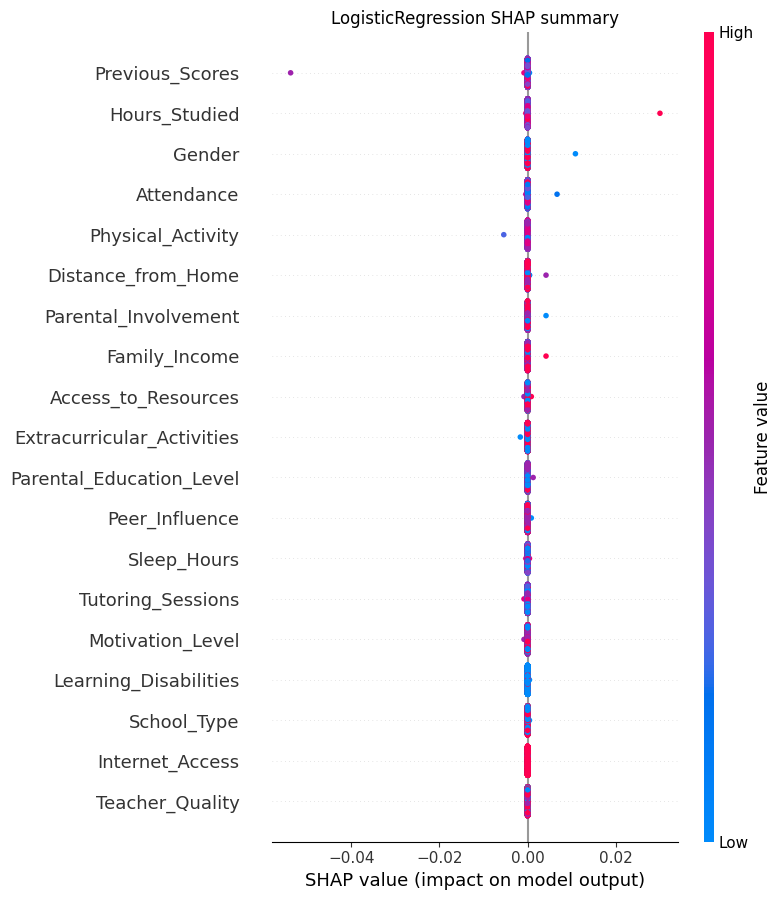

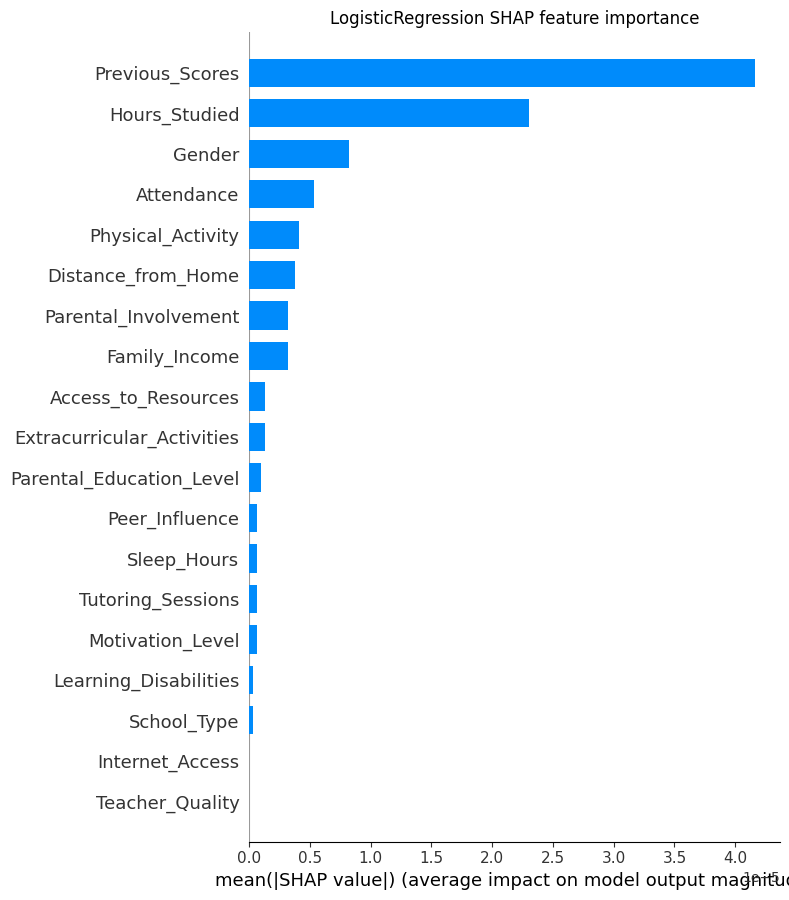


=== Training RandomForest ===
RandomForest -> MAE: 1.1197, RMSE: 2.1954, R2: 0.6590, MAPE: 1.63%, Accuracy: 98.34%
  -> Computing SHAP for RandomForest ...


PermutationExplainer explainer: 1323it [12:50,  1.70it/s]


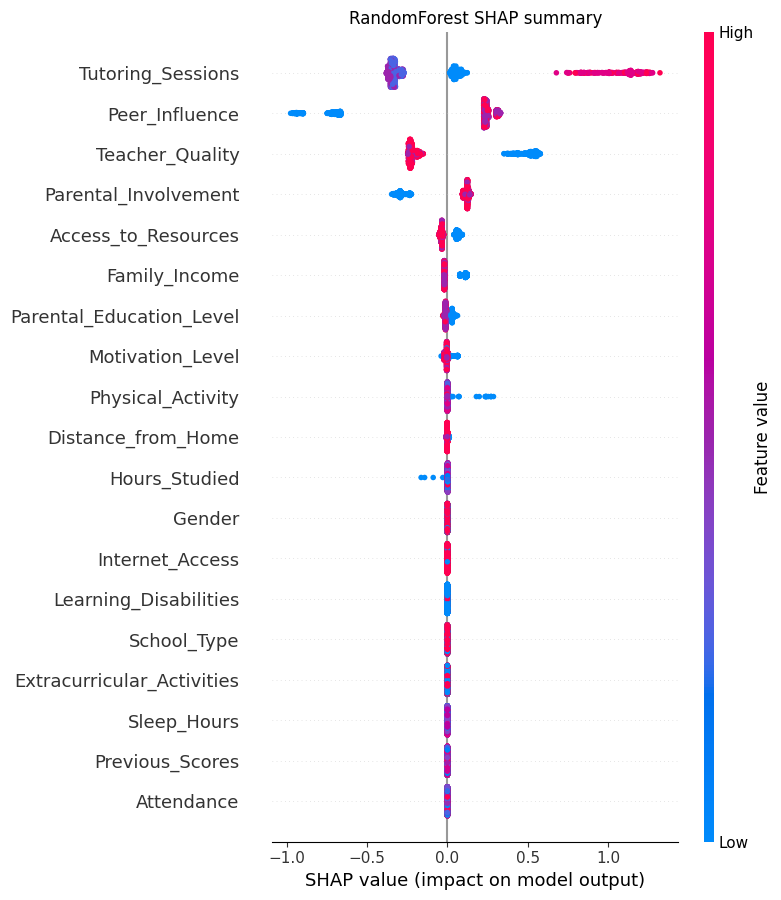

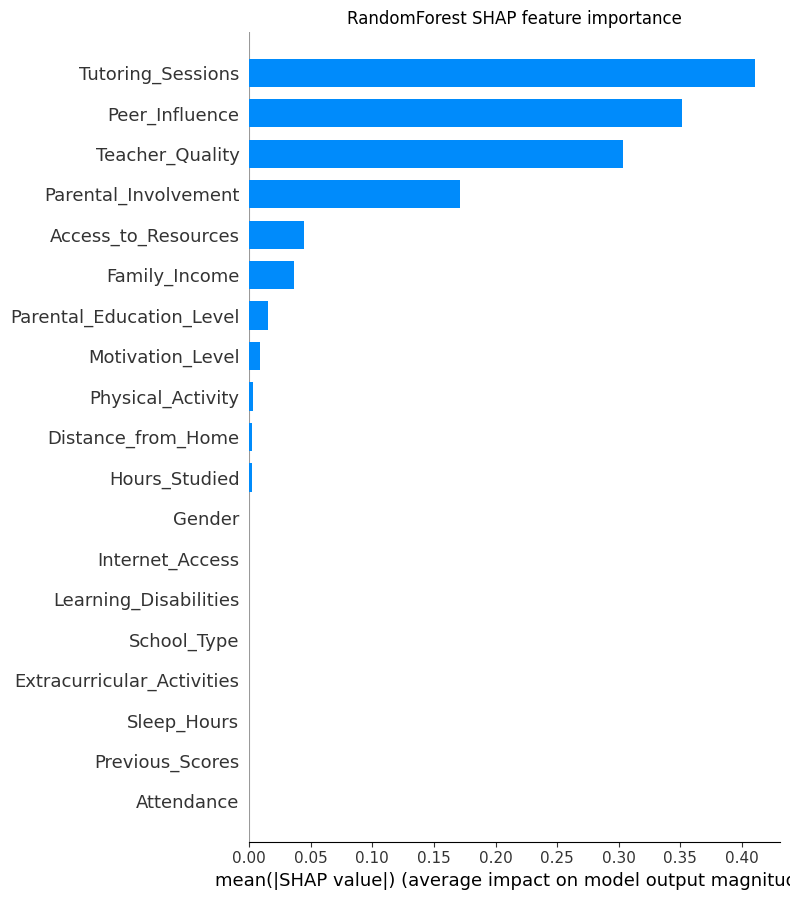


=== Training XGBoost ===
XGBoost -> MAE: 0.7274, RMSE: 1.9263, R2: 0.7375, MAPE: 1.04%, Accuracy: 98.92%
  -> Computing SHAP for XGBoost ...


PermutationExplainer explainer: 1323it [04:36,  4.60it/s]


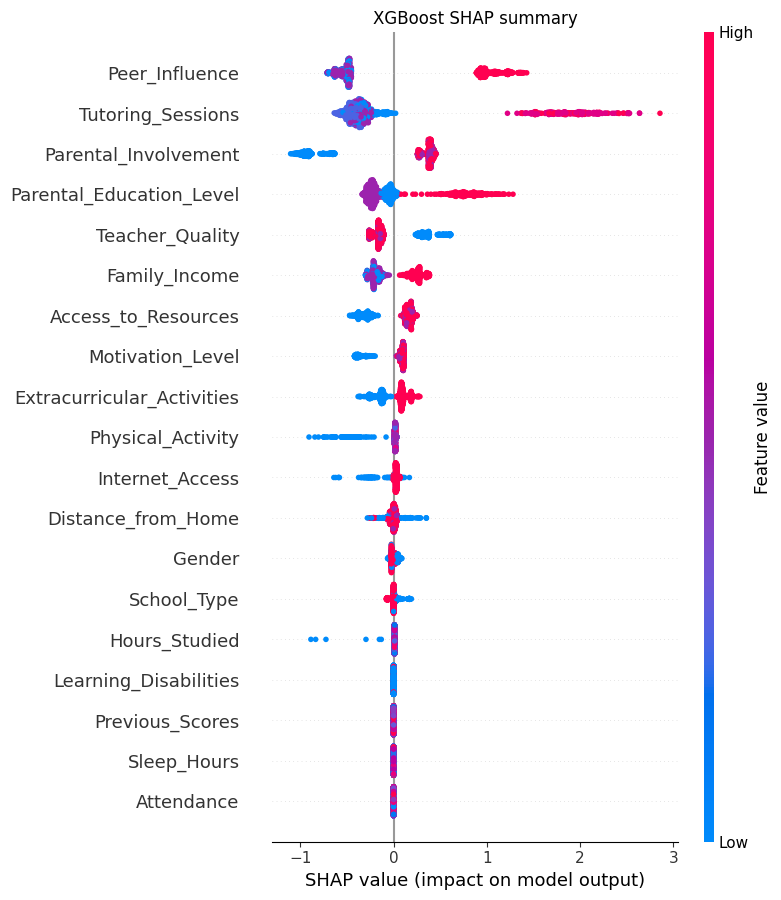

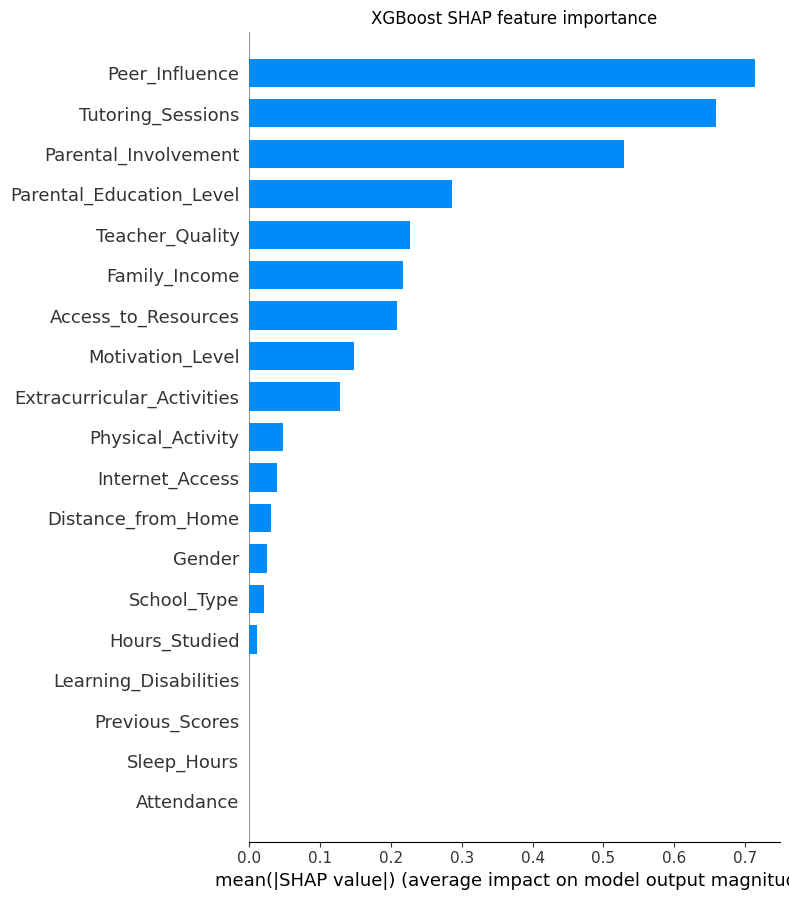


=== Training LightGBM ===
LightGBM -> MAE: 0.7314, RMSE: 1.9028, R2: 0.7439, MAPE: 1.04%, Accuracy: 98.91%
  -> Computing SHAP for LightGBM ...


PermutationExplainer explainer: 1323it [05:55,  3.61it/s]


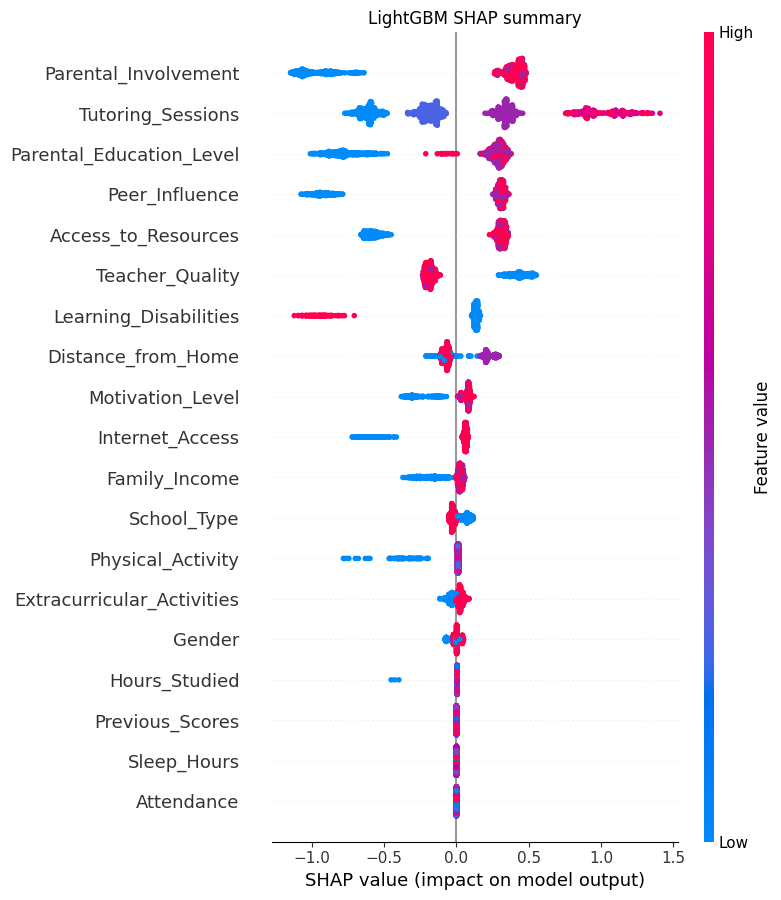

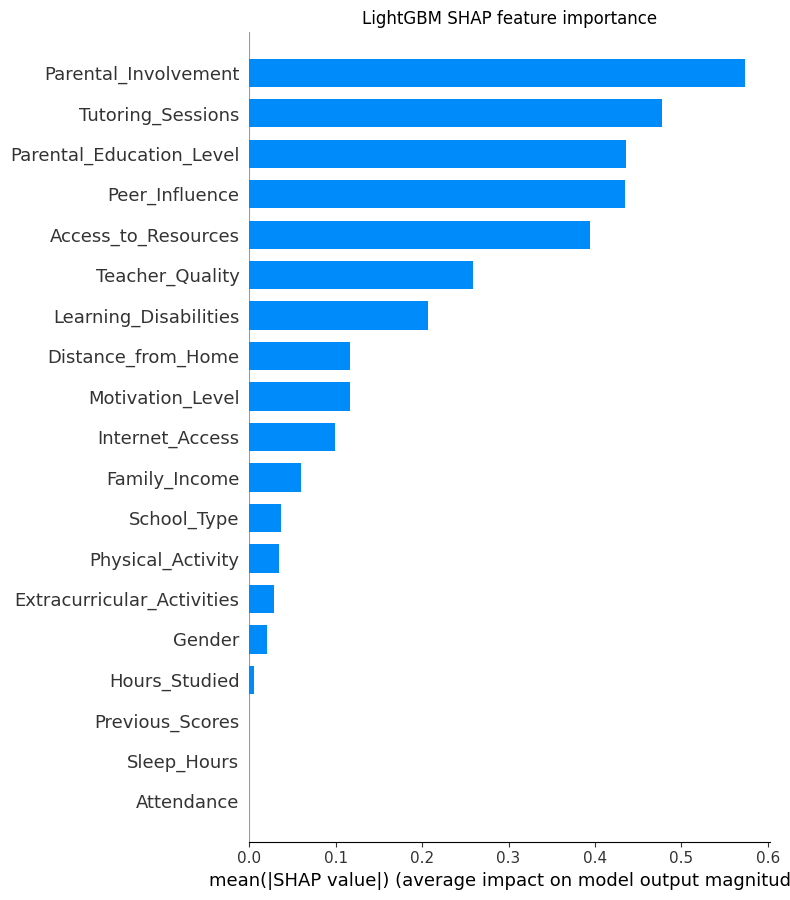


✅ Completed: training, evaluation, SHAP attempts, fairness, readiness.

Metrics saved to: model_outputs/student_performance_metrics.csv
SHAP images/tables (one per model) saved to: model_outputs
Fairness & readiness saved to: model_outputs

Metrics summary:
                Model       MAE      RMSE        R2  MAPE (%)  Accuracy
0  LogisticRegression  1.117247  2.283765  0.631018  1.618342  0.983403
1        RandomForest  1.119697  2.195406  0.659018  1.628551  0.983367
2             XGBoost  0.727363  1.926349  0.737474  1.039528  0.989195
3            LightGBM  0.731365  1.902797  0.743854  1.044620  0.989136

Fairness summary:
                    GroupA_RMSE  GroupB_RMSE  Disparity
LogisticRegression     2.041796     2.503715   0.461919
RandomForest           2.077270     2.308166   0.230896
XGBoost                1.706270     2.124886   0.418616
LightGBM               1.679077     2.104005   0.424927

Readiness summary:
                Model  Interpretability  Fairness  Scalability

In [ ]:
# Full end-to-end script: training + metrics + SHAP (for all models) + fairness + readiness + plots

import os
import warnings
warnings.filterwarnings("ignore")   # suppress warnings (including LightGBM warnings)

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error
)

# ------------------ CONFIG & OUTPUT DIR ------------------
file_path = '/content/student_performance/StudentPerformanceFactors.csv'  # <- change if needed
out_dir = 'model_outputs'
os.makedirs(out_dir, exist_ok=True)

# ------------------ LOAD DATA ------------------
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found at {file_path}")

df = pd.read_csv(file_path)
df = df.dropna(subset=['Exam_Score'])  # ensure target present

# ------------------ PREPROCESSING ------------------
X = df.drop(columns=['Exam_Score'])
y = df['Exam_Score']

# Encode categorical variables (label encoding for SHAP interpretability)
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Keep a raw copy (no scaling) for SHAP feature values / names
X_raw = X.copy()

# Impute and scale for model training
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)       # numpy array
X_scaled = scaler.fit_transform(X_imputed) # scaled numpy array

# Ensure reproducible train/test split for both scaled and raw versions
# Using same random_state and shuffle results in aligned indices
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)
# For raw features: split with same params to keep indices aligned
X_train_raw, X_test_raw, _, _ = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, shuffle=True
)

# Convert raw to pandas DataFrame (already is) and scaled are numpy arrays (ok)
feature_names = X_raw.columns.tolist()

# ------------------ MODELS ------------------
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42, verbose=-1)
}

# ------------------ TRAIN, EVALUATE, SHAP ------------------
results = []
shap_failures = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100.0

    # Custom regression "accuracy" (inverse normalized MAE)
    mean_y = np.mean(y_test)
    accuracy = 1.0 - (mae / mean_y) if mean_y != 0 else 0.0
    accuracy = float(np.clip(accuracy, 0.0, 1.0))  # clamp to [0,1]

    results.append({
        'Model': name,
        'MAE': float(mae),
        'RMSE': float(rmse),
        'R2': float(r2),
        'MAPE (%)': float(mape),
        'Accuracy': float(accuracy)
    })

    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%, Accuracy: {accuracy*100:.2f}%")

    # SHAP analysis (safe wrapper)
    print(f"  -> Computing SHAP for {name} ...")
    try:
        # Use callable wrapper so shap.Explainer won't attempt to introspect internals
        predict_fn = (model.predict if name == 'LinearRegression' else (lambda X: model.predict(X)))
        explainer = shap.Explainer(predict_fn, X_train_raw, feature_names=feature_names)
        shap_values = explainer(X_test_raw)

        # Summary plot (be sure to close so it doesn't jam environments)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_raw, feature_names=feature_names, show=False)
        plt.title(f"{name} SHAP summary")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{name}_shap_summary.png"))
        plt.show()
        #plt.close()

        # Bar plot (feature importance)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_raw, feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f"{name} SHAP feature importance")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{name}_shap_bar.png"))
        #plt.close()
        plt.show()


        # Save top features numeric table
        # shap_values.values shape: (n_samples, n_features) for single-output
        # We'll compute mean absolute shap per feature
        mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
        feat_imp_df = pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap': mean_abs_shap
        }).sort_values('mean_abs_shap', ascending=False)
        feat_imp_df.to_csv(os.path.join(out_dir, f"{name}_shap_feature_importance.csv"), index=False)

    except Exception as e:
        print(f"  ⚠️ SHAP failed for {name}: {e}")
        shap_failures[name] = str(e)

# ------------------ SAVE METRICS ------------------
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(out_dir, "student_performance_metrics.csv"), index=False)
results_df.to_json(os.path.join(out_dir, "student_performance_metrics.json"), orient='records', indent=2)

# ------------------ PLOTS: Performance Comparison ------------------
# Error metrics plot (MAE, RMSE, MAPE)
plt.figure(figsize=(10,6))
x = np.arange(len(results_df))
width = 0.2
plt.bar(x - 1.5*width, results_df['MAE'], width=width, label='MAE')
plt.bar(x - 0.5*width, results_df['RMSE'], width=width, label='RMSE')
plt.bar(x + 0.5*width, results_df['MAPE (%)'], width=width, label='MAPE (%)')
plt.xticks(x, results_df['Model'])
plt.ylabel('Error')
plt.title('Error Metrics by Model')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "model_error_metrics.png"))
plt.close()

# Accuracy / R2 plot (Accuracy as percentage)
plt.figure(figsize=(8,5))
plt.plot(results_df['Model'], results_df['R2'], marker='o', label='R2')
plt.plot(results_df['Model'], results_df['Accuracy']*100, marker='s', label='Accuracy (%)')
plt.ylabel('Score')
plt.title('R2 and Accuracy by Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "model_accuracy_r2.png"))
plt.close()

# Combined radar-style or normalized plot could be added; kept simple/clear here.

# ------------------ FAIRNESS (synthetic groups) ------------------
np.random.seed(42)
demographic = np.random.choice(['GroupA','GroupB'], size=len(y_test))
fairness = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    maskA = demographic == 'GroupA'
    maskB = demographic == 'GroupB'

    groupA_rmse = np.sqrt(mean_squared_error(y_test[maskA], y_pred[maskA]))
    groupB_rmse = np.sqrt(mean_squared_error(y_test[maskB], y_pred[maskB]))
    disparity = abs(groupA_rmse - groupB_rmse)

    fairness[name] = {
        'GroupA_RMSE': float(groupA_rmse),
        'GroupB_RMSE': float(groupB_rmse),
        'Disparity': float(disparity)
    }

fairness_df = pd.DataFrame(fairness).T
fairness_df.to_csv(os.path.join(out_dir, "student_performance_fairness.csv"))
fairness_df.to_json(os.path.join(out_dir, "student_performance_fairness.json"), orient='records', indent=2)

# ------------------ READINESS INDEX ------------------
def compute_readiness_index(model_name, interpretability, fairness_score, scalability, accuracy_score, data_quality):
    total = interpretability + fairness_score + scalability + accuracy_score + data_quality
    return {
        'Model': model_name,
        'Interpretability': interpretability,
        'Fairness': fairness_score,
        'Scalability': scalability,
        'Accuracy_Score': accuracy_score,
        'Data_Quality': data_quality,
        'Total_Score': total
    }

readiness = []
for row in results:
    name = row['Model']
    # map R2 -> 0-5 scale for "accuracy" part (same as before)
    acc_component = float(np.clip(row['R2'] * 5.0, 0.0, 5.0))
    readiness.append(compute_readiness_index(
        model_name=name,
        interpretability=4 if name == 'XGBoost' else 3,
        fairness_score=3,
        scalability=4,
        accuracy_score=round(acc_component, 2),
        data_quality=4
    ))

readiness_df = pd.DataFrame(readiness)
readiness_df.to_csv(os.path.join(out_dir, "student_performance_readiness_index.csv"), index=False)
readiness_df.to_json(os.path.join(out_dir, "student_performance_readiness_index.json"), orient='records', indent=2)

# ------------------ SUMMARY PRINT & PATHS ------------------
print("\n✅ Completed: training, evaluation, SHAP attempts, fairness, readiness.")
print("\nMetrics saved to:", os.path.join(out_dir, "student_performance_metrics.csv"))
print("SHAP images/tables (one per model) saved to:", out_dir)
print("Fairness & readiness saved to:", out_dir)
if shap_failures:
    print("\n⚠️ SHAP failures occurred for these models:")
    for k,v in shap_failures.items():
        print(f" - {k}: {v}")

print("\nMetrics summary:")
print(results_df)
print("\nFairness summary:")
print(fairness_df)
print("\nReadiness summary:")
print(readiness_df)


## UNIVERSITY RANKING

RandomForest -> MAE: 368.04, RMSE: 482.22, MAPE: 34.76%, R2: 0.23, Accuracy: 0.96
XGBoost -> MAE: 368.81, RMSE: 486.46, MAPE: 35.09%, R2: 0.22, Accuracy: 0.96
LightGBM -> MAE: 364.51, RMSE: 476.47, MAPE: 35.11%, R2: 0.25, Accuracy: 0.96
LogisticRegression -> MAE: 939.08, RMSE: 1088.19, MAPE: 99.67%, R2: -2.92, Accuracy: 0.11
Running SHAP for: RandomForest


ExactExplainer explainer: 7458it [30:45,  4.02it/s]


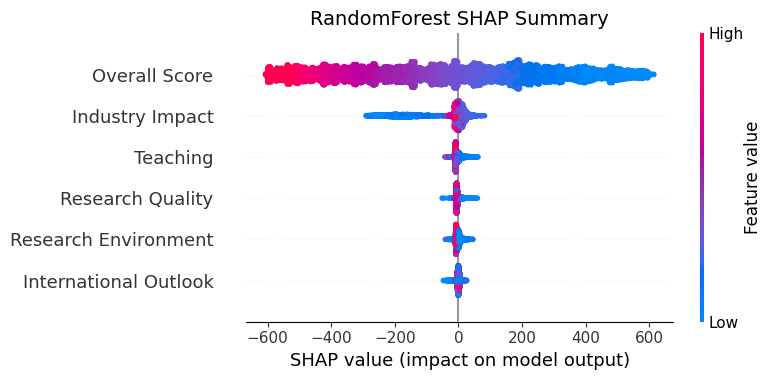

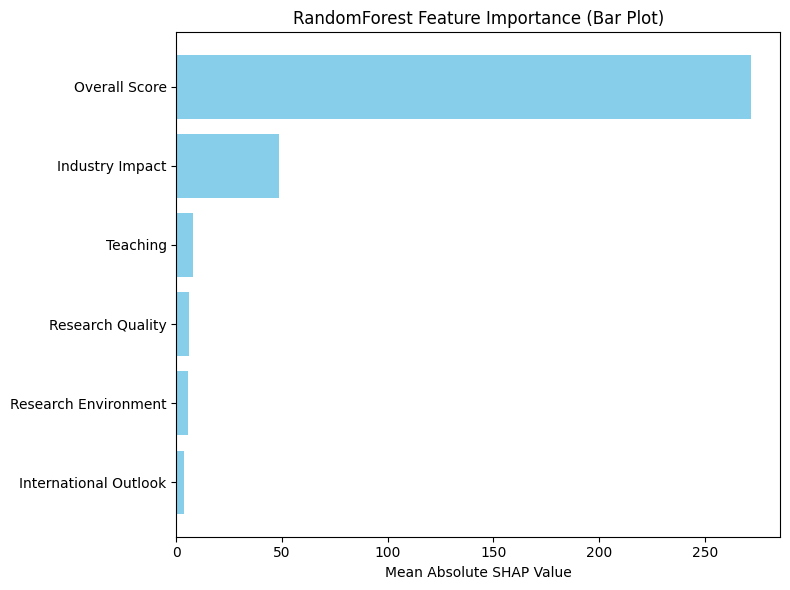

✅ SHAP summary and bar plots saved for RandomForest
Running SHAP for: XGBoost


ExactExplainer explainer: 7458it [07:18, 16.61it/s]


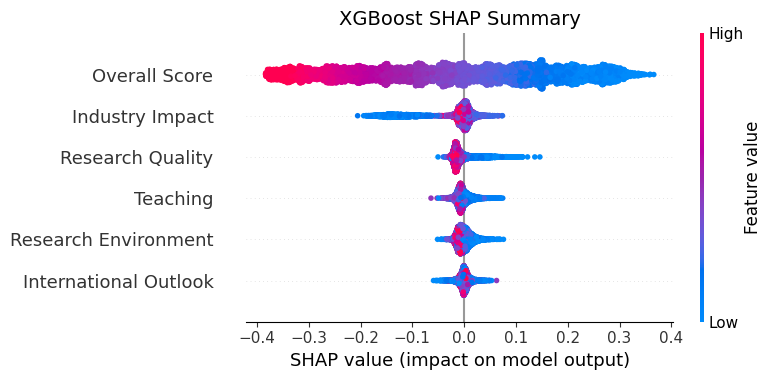

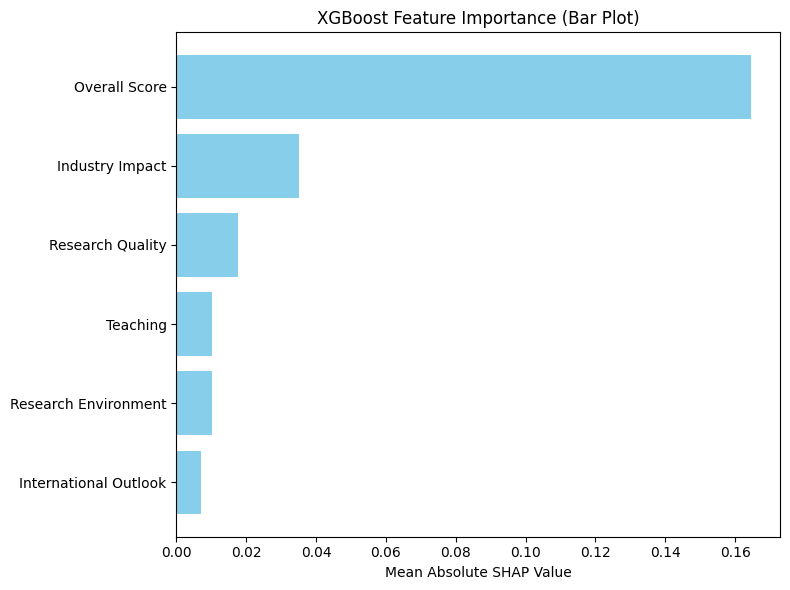

✅ SHAP summary and bar plots saved for XGBoost
Running SHAP for: LightGBM


ExactExplainer explainer: 7458it [11:21, 10.75it/s]                          


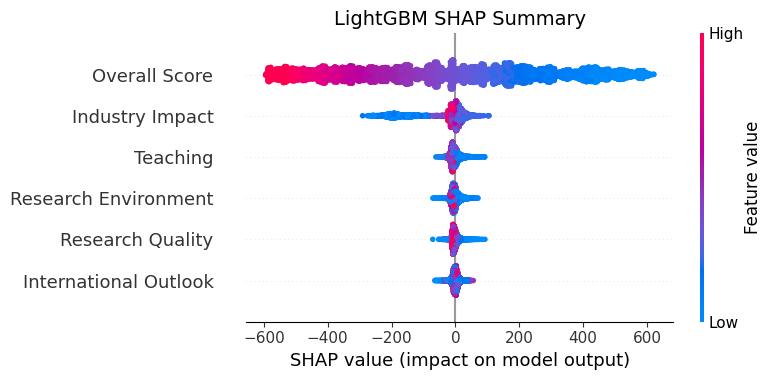

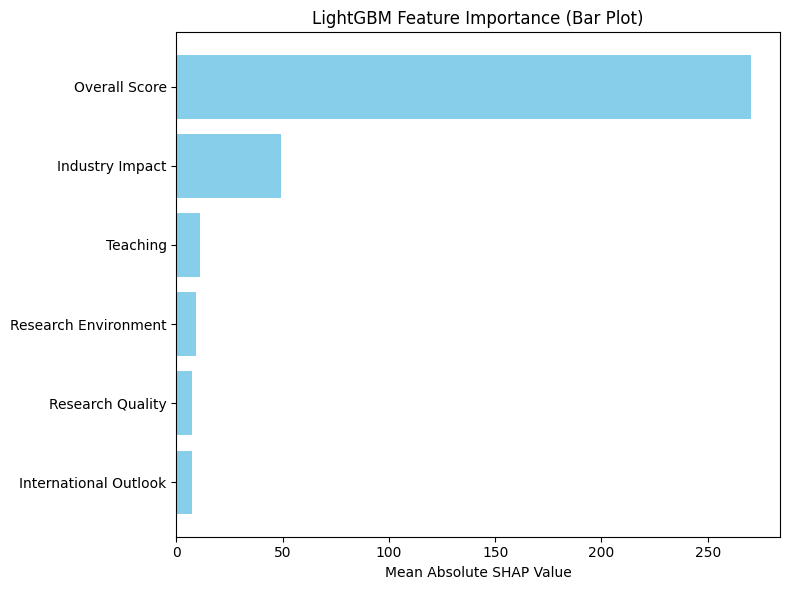

✅ SHAP summary and bar plots saved for LightGBM
Running SHAP for: LogisticRegression


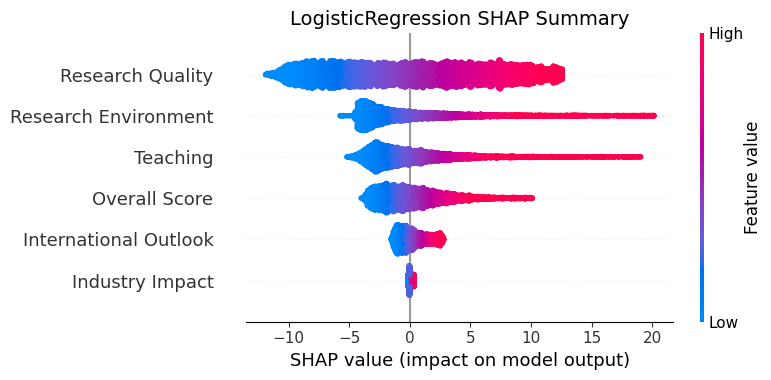

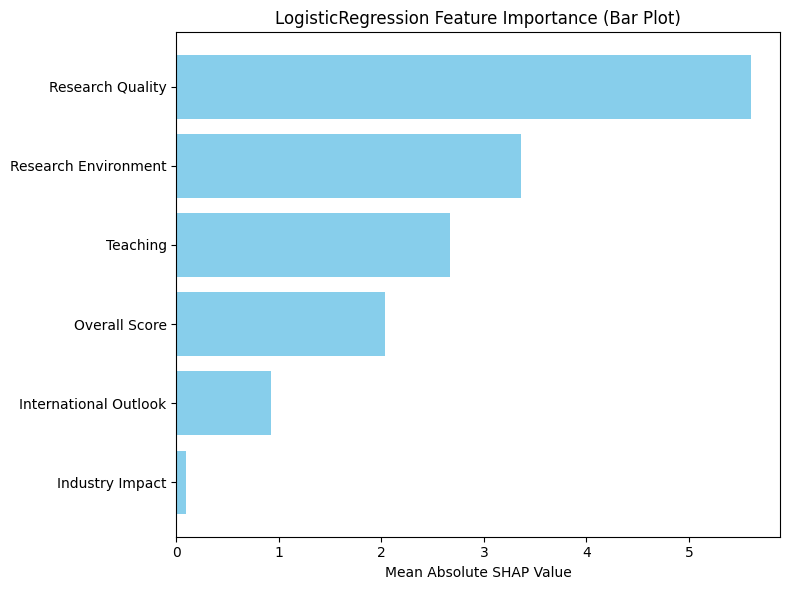

✅ SHAP summary and bar plots saved for LogisticRegression
✅ Pipeline completed successfully: Metrics, SHAP, Fairness, and Educational AI Readiness Index generated.

📊 Performance Metrics:
                Model         MAE         RMSE       MAPE        R2  Accuracy
0        RandomForest  368.039409   482.218071  34.762110  0.230141  0.959367
1             XGBoost  368.806679   486.457027  35.089266  0.216547  0.958831
2            LightGBM  364.509660   476.469022  35.112367  0.248388  0.958562
3  LogisticRegression  939.082071  1088.187307  99.670258 -2.920410  0.107282

⚖️ Fairness Analysis:
                    Public_RMSE  Private_RMSE  Disparity
RandomForest           0.197368      0.205741   0.008373
XGBoost                0.202703      0.203103   0.000400
LightGBM               0.201383      0.205741   0.004359
LogisticRegression     0.945556      0.944111   0.001445

📈 Educational AI Readiness Index:
                Model  Interpretability  Fairness  Scalability  Accuracy  \
0  

In [ ]:
# ------------------ IMPORTS ------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap

# ------------------ LOAD DATA ------------------
df = pd.read_csv('/content/university_rankings/THE World University Rankings 2016-2025.csv')

# ------------------ FEATURES & TARGETS ------------------
features = [
    'Teaching',
    'Research Environment',
    'Research Quality',
    'Industry Impact',
    'International Outlook',
    'Overall Score'
]

# Convert all features to numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaNs
required_cols = ['Rank','Year','Name','Country'] + features
df = df.dropna(subset=required_cols)
df['Year'] = df['Year'].astype(int)

# ------------------ TRAIN/TEST SPLIT ------------------
train = df[df['Year'] < 2022]
test = df[df['Year'] >= 2022]

X_train = train[features].astype(float)
y_train = train['Rank'].astype(float)
X_test = test[features].astype(float)
y_test = test['Rank'].astype(float)

# Logistic Regression target: Top 200 universities
y_train_class = (y_train <= 200).astype(int)
y_test_class = (y_test <= 200).astype(int)

# Scale target for XGBoost regression
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1)).flatten()

# ------------------ DEFINE MODELS ------------------
models = {
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

# ------------------ TRAIN & PREDICT ------------------
predictions = {}
for name, model in models.items():
    if name == 'LogisticRegression':
        model.fit(X_train, y_train_class)
        predictions[name] = model.predict(X_test)
    elif name == 'XGBoost':
        model.fit(X_train, y_train_scaled)
        y_pred_scaled = model.predict(X_test)
        predictions[name] = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
    else:
        model.fit(X_train, y_train)
        predictions[name] = model.predict(X_test)

# ------------------ UNIFIED EVALUATION ------------------
threshold = 200  # Top 200 universities

def evaluate_all_metrics(y_true, y_pred, model_name, threshold=200):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    y_true_class = (y_true <= threshold).astype(int)
    y_pred_class = (y_pred <= threshold).astype(int)
    acc = accuracy_score(y_true_class, y_pred_class)

    print(f"{model_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}, Accuracy: {acc:.2f}")
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Accuracy': acc}

results = []
for name, y_pred in predictions.items():
    results.append(evaluate_all_metrics(y_test, y_pred, name, threshold=threshold))

results_df = pd.DataFrame(results)
results_df.to_csv('university_rankings_metrics.csv', index=False)
results_df.to_json('university_rankings_metrics.json', orient='records', indent=2)

# ------------------ SHAP ANALYSIS FOR ALL MODELS ------------------
os.makedirs('shap_plots', exist_ok=True)

for name, model in models.items():
    print(f"Running SHAP for: {name}")

    if name == 'LogisticRegression':
        explainer = shap.LinearExplainer(
            model,
            X_train,
            feature_perturbation="interventional"
        )
        shap_values = explainer.shap_values(X_test)

        # For binary classification, take positive class
        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        shap_values_obj = shap.Explanation(values=shap_values, data=X_test, feature_names=X_train.columns)

    else:
        explainer = shap.Explainer(model.predict, X_train)
        shap_values_obj = explainer(X_test)

    # --- Summary Plot ---
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_obj.values, X_test, feature_names=X_train.columns, show=False)
    plt.title(f"{name} SHAP Summary", fontsize=14)
    plt.tight_layout()
    plt.savefig(f'shap_plots/{name}_shap_summary.png', bbox_inches='tight', dpi=300)
    plt.show()

    # --- Bar Plot for Top Features ---
    feature_importance = np.abs(shap_values_obj.values).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(8,6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.title(f"{name} Feature Importance (Bar Plot)")
    plt.tight_layout()
    plt.savefig(f'shap_plots/{name}_shap_feature_bar.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Save JSON of SHAP feature importance
    shap_summary = dict(zip(X_train.columns, feature_importance))
    with open(f'shap_plots/{name}_shap_feature_importance.json', 'w') as f:
        json.dump(shap_summary, f, indent=2)

    print(f"✅ SHAP summary and bar plots saved for {name}")

# ------------------ SYNTHETIC FAIRNESS ANALYSIS ------------------
np.random.seed(42)
demographic = np.random.choice(['Public','Private'], size=len(X_test))

fairness = {}
for name in models.keys():
    y_pred = predictions[name]
    maskA = demographic == 'Public'
    maskB = demographic == 'Private'
    rmseA = np.sqrt(mean_squared_error((y_test <= threshold).astype(int)[maskA],
                                       (y_pred <= threshold).astype(int)[maskA]))
    rmseB = np.sqrt(mean_squared_error((y_test <= threshold).astype(int)[maskB],
                                       (y_pred <= threshold).astype(int)[maskB]))
    disparity = abs(rmseA - rmseB)
    fairness[name] = {'Public_RMSE': rmseA, 'Private_RMSE': rmseB, 'Disparity': disparity}

fairness_df = pd.DataFrame(fairness).T
fairness_df.to_csv('university_rankings_fairness.csv', index=False)
fairness_df.to_json('university_rankings_fairness.json', orient='records', indent=2)

# ------------------ EDUCATIONAL AI READINESS INDEX ------------------
def compute_readiness(model_name, interpretability, fairness_score, scalability, accuracy, data_quality):
    return {
        'Model': model_name,
        'Interpretability': interpretability,
        'Fairness': fairness_score,
        'Scalability': scalability,
        'Accuracy': accuracy,
        'Data Quality': data_quality,
        'Total_Score': interpretability + fairness_score + scalability + accuracy + data_quality
    }

readiness = []
for row in results_df.itertuples():
    accuracy_score_val = row.Accuracy * 5  # rescale accuracy to 5
    readiness.append(compute_readiness(row.Model, interpretability=3, fairness_score=3,
                                       scalability=4, accuracy=accuracy_score_val, data_quality=4))

readiness_df = pd.DataFrame(readiness)
readiness_df.to_csv('university_rankings_readiness_index.csv', index=False)
readiness_df.to_json('university_rankings_readiness_index.json', orient='records', indent=2)

print("✅ Pipeline completed successfully: Metrics, SHAP, Fairness, and Educational AI Readiness Index generated.")
print("\n📊 Performance Metrics:")
print(results_df)
print("\n⚖️ Fairness Analysis:")
print(fairness_df)
print("\n📈 Educational AI Readiness Index:")
print(readiness_df)


## ENROLLED

✅ Columns: ['Unnamed: 0', 'Type', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
🚀 Training RandomForest...
🚀 Training XGBoost...
🚀 Training LightGBM...
🚀 Training LogisticRegression...
✅ All models trained and predictions generated.

📊 Model Evaluation Results:
                Model           MAE          RMSE        MAPE        R2  \
0        RandomForest  2.267401e+05  4.200925e+05    3.044041  0.996089   
1             XGBoost  2.352509e+05  3.696035e+05    4.080037  0.996972   
2            LightGBM  1.975339e+06  2.389779e+06   35.671066  0.873420   
3  LogisticRegression  6.036301e+06  6.349858e+06  245.162568  0.106326   

   Accuracy  
0  0.996089  
1  0.996972  
2  0.873420  
3  0.106326   

🧠 Running SHAP Explainability for all models (robust)...

🔹 SHAP analysis for RandomForest...


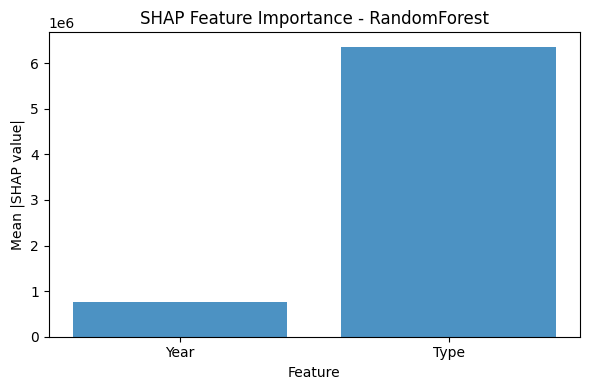

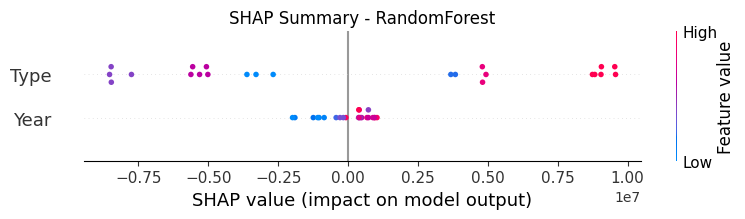

   ✅ Done. Top feature: Type (6358292.604138)

🔹 SHAP analysis for XGBoost...


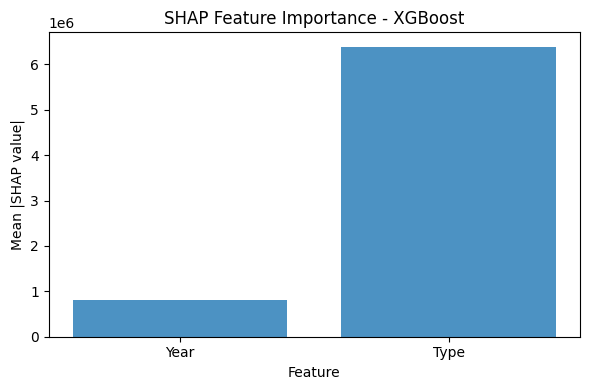

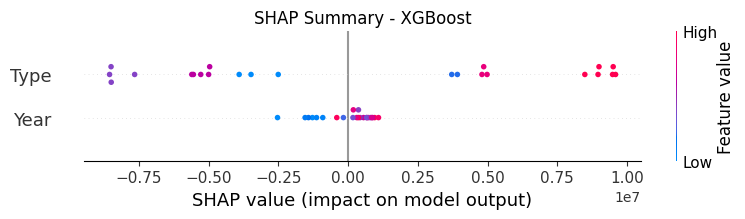

   ✅ Done. Top feature: Type (6384717.816688)

🔹 SHAP analysis for LightGBM...


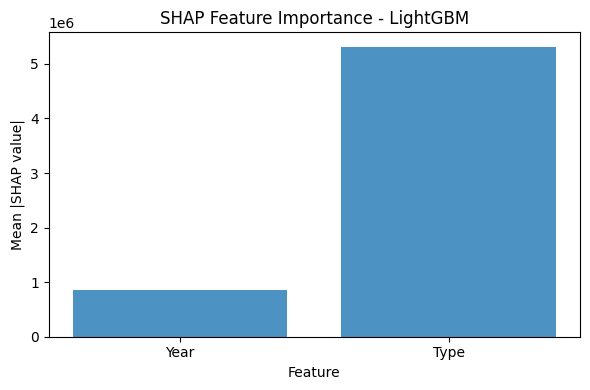

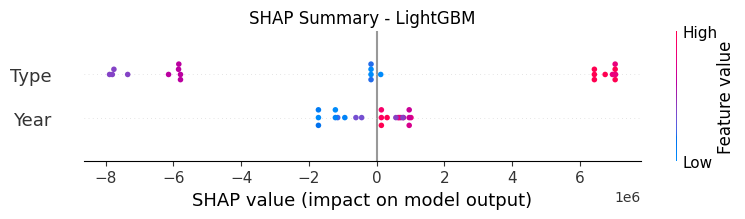

   ✅ Done. Top feature: Type (5312482.402430)

🔹 SHAP analysis for LogisticRegression...


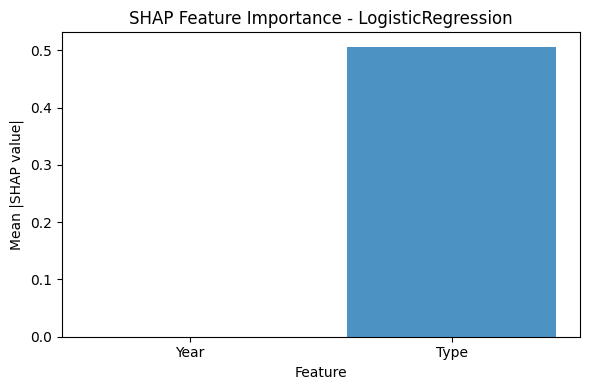

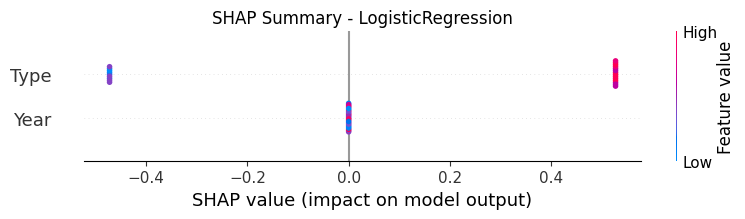

   ✅ Done. Top feature: Type (0.505972)



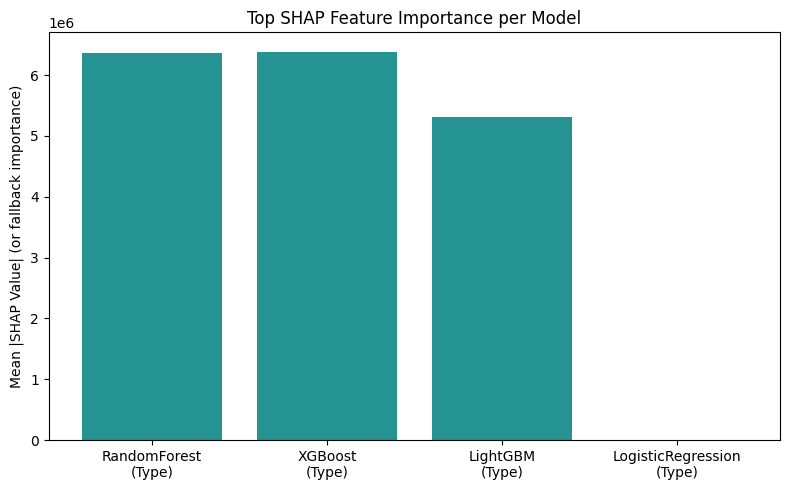


📊 Mean Absolute SHAP (or fallback) importances per model:
                             Year          Type
RandomForest        760907.646507  6.358293e+06
XGBoost             800166.820540  6.384718e+06
LightGBM            849249.055967  5.312482e+06
LogisticRegression       0.000000  5.059720e-01

⚖️ Running Fairness Analysis...
✅ Fairness analysis complete:
                    Public_RMSE  Private_RMSE   Disparity
RandomForest          171192.34      64486.88   106705.46
XGBoost               481270.25      82935.31   398334.94
LightGBM             3229486.78    4814220.36  1584733.58
LogisticRegression   2518731.14    5612722.79  3093991.65 

🎓 Computing Educational AI Readiness Index...

Educational AI Readiness Index:

             Model  Interpretability  Fairness  Scalability  Accuracy  Data Quality  Total_Score
      RandomForest                 3         3            4  0.996089             4    14.996089
           XGBoost                 3         3            4  0.996972   

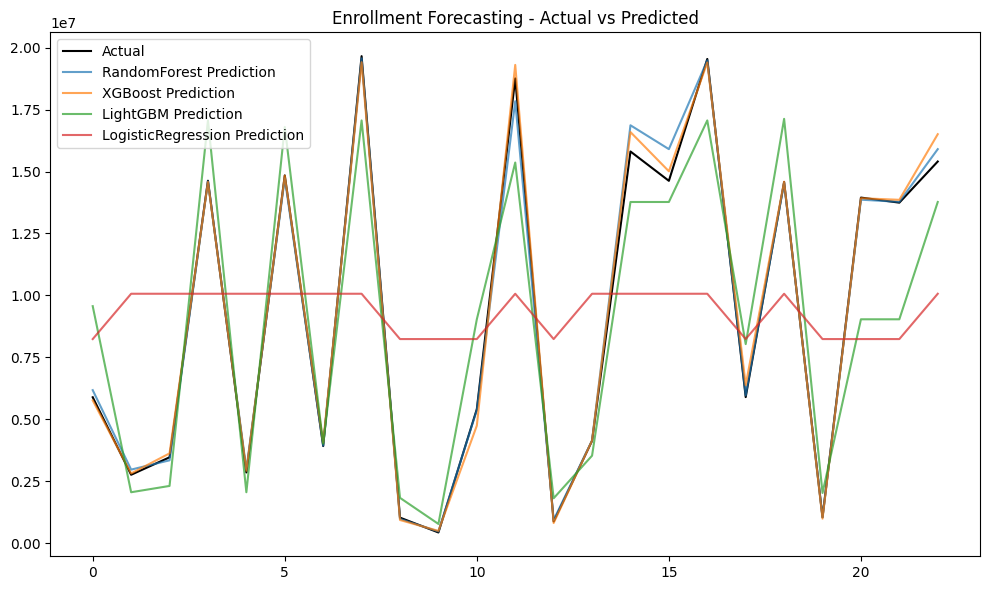

✅ Enrollment Forecasting Task Completed Successfully.


In [ ]:
# ------------------ IMPORTS ------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# ------------------ LOAD DATA ------------------
file_path = '/content/college_enrollment/enrollment.csv'  # <-- Update to your dataset path
df = pd.read_csv(file_path)

# Check dataset structure
print("✅ Columns:", df.columns.tolist())

# ------------------ TRANSFORM DATA ------------------
# Melt year columns into a long format
year_cols = [col for col in df.columns if col.isdigit()]
df_long = df.melt(id_vars=['Type'], value_vars=year_cols,
                  var_name='Year', value_name='Enrollment')

# Drop missing values
df_long = df_long.dropna(subset=['Enrollment'])
df_long['Year'] = df_long['Year'].astype(int)
df_long['Enrollment'] = pd.to_numeric(df_long['Enrollment'], errors='coerce')
df_long = df_long.dropna(subset=['Enrollment'])

# Encode Type (Public=0, Private=1)
df_long['Type'] = LabelEncoder().fit_transform(df_long['Type'])

# Features and Target
X = df_long[['Year', 'Type']].copy()
y = df_long['Enrollment'].copy()

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------ MODELS ------------------
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=500, verbose=0)
}

# ------------------ TRAIN & PREDICT ------------------
predictions = {}
for name, model in models.items():
    print(f"🚀 Training {name}...")
    if name == 'LogisticRegression':
        # Convert target to binary class for logistic regression
        y_train_class = (y_train > y_train.median()).astype(int)
        y_test_class = (y_test > y_test.median()).astype(int)
        X_train_filled = pd.DataFrame(X_train_scaled, columns=X.columns).fillna(0)
        X_test_filled = pd.DataFrame(X_test_scaled, columns=X.columns).fillna(0)
        model.fit(X_train_filled, y_train_class)
        y_pred_class = model.predict(X_test_filled)
        # Map binary predictions to approximate enrollment values (for evaluation/plots)
        y_pred = np.where(y_pred_class == 1, y_train.median() * 1.1, y_train.median() * 0.9)
        predictions[name] = y_pred
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        predictions[name] = y_pred

print("✅ All models trained and predictions generated.\n")

# ------------------ EVALUATION ------------------
def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    r2 = r2_score(true, pred)
    accuracy = r2  # using R² as accuracy proxy for regression
    return mae, rmse, mape, r2, accuracy

results = []
for name, pred in predictions.items():
    mae, rmse, mape, r2, accuracy = evaluate(y_test, pred)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
results_df.to_csv('enrollment_forecasting_metrics.csv', index=False)
results_df.to_json('enrollment_forecasting_metrics.json', orient='records', indent=2)
print("📊 Model Evaluation Results:")
print(results_df, "\n")

# ------------------ SHAP ANALYSIS (robust and labeled) ------------------
print("🧠 Running SHAP Explainability for all models (robust)...\n")

feature_names = X.columns.tolist()            # e.g. ['Year', 'Type']
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_scaled, columns=feature_names)

all_shap_importances = {}   # per-model dict of {feature: mean_abs_shap}
top_shap_dict = {}          # per-model top feature and value

for name, model in models.items():
    print(f"🔹 SHAP analysis for {name}...")
    try:
        # Use a callable predictor with shap.Explainer - robust for all model types
        predictor = model.predict
        explainer = shap.Explainer(predictor, X_train_df)   # masker auto-selected
        shap_exp = explainer(X_test_df)                     # Explanation object

        # shap_exp.values is shape (n_samples, n_features) for single-output models
        values = shap_exp.values
        if values.ndim == 3:    # some tree explainers return (n_samples, n_outputs, n_features)
            # reduce to first (or sum) over outputs if needed
            values = values[:,0,:]

        mean_abs_shap = np.abs(values).mean(axis=0)   # mean |SHAP| per feature
        imp_dict = dict(zip(feature_names, mean_abs_shap))
        all_shap_importances[name] = imp_dict

        # Top feature for this model
        sorted_idx = np.argsort(mean_abs_shap)[::-1]
        top_feature = feature_names[sorted_idx[0]]
        top_shap_value = mean_abs_shap[sorted_idx[0]]
        top_shap_dict[name] = (top_feature, top_shap_value)

        # Per-model SHAP bar plot (feature names shown)
        plt.figure(figsize=(6,4))
        plt.bar(feature_names, mean_abs_shap, color='tab:blue', alpha=0.8)
        plt.title(f"SHAP Feature Importance - {name}")
        plt.ylabel("Mean |SHAP value|")
        plt.xlabel("Feature")
        plt.tight_layout()
        plt.savefig(f'shap_bar_{name}.png', bbox_inches='tight')
        plt.show()

        # optional: summary plot (works from the Explanation object)
        try:
            plt.figure(figsize=(6,4))
            shap.summary_plot(shap_exp, features=X_test_df, feature_names=feature_names, show=False)
            plt.title(f"SHAP Summary - {name}")
            plt.tight_layout()
            plt.savefig(f'shap_summary_{name}.png', bbox_inches='tight')
            plt.show()
        except Exception as e_summary:
            # summary_plot may still fail in some environments; continue gracefully
            print(f"   ⚠ summary_plot failed for {name}: {e_summary}")

        print(f"   ✅ Done. Top feature: {top_feature} ({top_shap_value:.6f})\n")

    except Exception as e:
        # If SHAP explainer fails, fallback to model.feature_importances_ or coef_
        print(f"   ⚠ SHAP failed for {name}: {e}")

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            imp_dict = dict(zip(feature_names, importances))
            all_shap_importances[name] = imp_dict
            idx = np.argmax(importances)
            top_shap_dict[name] = (feature_names[idx], importances[idx])
            # save fallback bar plot
            plt.figure(figsize=(6,4))
            plt.bar(feature_names, importances, color='tab:orange', alpha=0.8)
            plt.title(f"Model Feature Importances (fallback) - {name}")
            plt.ylabel("Importance")
            plt.xlabel("Feature")
            plt.tight_layout()
            plt.savefig(f'shap_bar_{name}_fallback.png', bbox_inches='tight')
            plt.show()
            print(f"   ✅ Fallback importances used for {name}.\n")
        elif hasattr(model, "coef_"):
            coef_vals = np.abs(model.coef_).ravel()
            imp_dict = dict(zip(feature_names, coef_vals))
            all_shap_importances[name] = imp_dict
            idx = np.argmax(coef_vals)
            top_shap_dict[name] = (feature_names[idx], coef_vals[idx])
            plt.figure(figsize=(6,4))
            plt.bar(feature_names, coef_vals, color='tab:orange', alpha=0.8)
            plt.title(f"Model Coefficients (fallback) - {name}")
            plt.ylabel("|Coefficient|")
            plt.xlabel("Feature")
            plt.tight_layout()
            plt.savefig(f'shap_bar_{name}_coef_fallback.png', bbox_inches='tight')
            plt.show()
            print(f"   ✅ Fallback coeffs used for {name}.\n")
        else:
            all_shap_importances[name] = dict(zip(feature_names, [0.0]*len(feature_names)))
            top_shap_dict[name] = ("N/A", 0.0)
            print(f"   ⚠ No importance info available for {name}. Skipping.\n")

# ------------------ Combined Top Feature Bar Plot ------------------
plt.figure(figsize=(8, 5))
bar_labels = [f"{m}\n({f})" for m, (f, _) in top_shap_dict.items()]
bar_values = [v for _, v in top_shap_dict.values()]

plt.bar(bar_labels, bar_values, color='teal', alpha=0.85)
plt.title("Top SHAP Feature Importance per Model")
plt.ylabel("Mean |SHAP Value| (or fallback importance)")
plt.tight_layout()
plt.savefig('shap_top_features_all_models.png', bbox_inches='tight')
plt.show()

# Print SHAP table (mean abs values) with feature names
print("\n📊 Mean Absolute SHAP (or fallback) importances per model:")
shap_table = pd.DataFrame.from_dict(all_shap_importances, orient='index', columns=feature_names)
print(shap_table.round(6))
print()

# ------------------ FAIRNESS ANALYSIS ------------------
print("⚖️ Running Fairness Analysis...")
demographic = df_long.iloc[y_test.index]['Type'].values
fairness = {}

for name, pred in predictions.items():
    groupA_mask = demographic == 0  # Public
    groupB_mask = demographic == 1  # Private

    # Handle empty groups
    if np.sum(groupA_mask) == 0 or np.sum(groupB_mask) == 0:
        fairness[name] = {'Public_RMSE': np.nan, 'Private_RMSE': np.nan, 'Disparity': np.nan}
        continue

    groupA_rmse = np.sqrt(mean_squared_error(y_test[groupA_mask], pred[groupA_mask]))
    groupB_rmse = np.sqrt(mean_squared_error(y_test[groupB_mask], pred[groupB_mask]))
    disparity = abs(groupA_rmse - groupB_rmse)

    fairness[name] = {
        'Public_RMSE': round(groupA_rmse, 2),
        'Private_RMSE': round(groupB_rmse, 2),
        'Disparity': round(disparity, 2)
    }

fairness_df = pd.DataFrame(fairness).T
fairness_df.to_csv('enrollment_forecasting_fairness.csv')
fairness_df.to_json('enrollment_forecasting_fairness.json', orient='records', indent=2)
print("✅ Fairness analysis complete:")
print(fairness_df, "\n")

# ------------------ EDUCATIONAL AI READINESS INDEX ------------------
print("🎓 Computing Educational AI Readiness Index...\n")

def compute_readiness_index(model_name, interpretability, fairness, scalability, accuracy, data_quality):
    total = interpretability + fairness + scalability + accuracy + data_quality
    return {
        'Model': model_name,
        'Interpretability': interpretability,
        'Fairness': fairness,
        'Scalability': scalability,
        'Accuracy': accuracy,
        'Data Quality': data_quality,
        'Total_Score': total
    }

readiness = []
for _, row in results_df.iterrows():
    readiness.append(
        compute_readiness_index(
            model_name=row['Model'],
            interpretability=3,
            fairness=3,
            scalability=4,
            accuracy=row['Accuracy'],
            data_quality=4
        )
    )

readiness_df = pd.DataFrame(readiness)
readiness_df.to_csv('enrollment_forecasting_readiness_index.csv', index=False)
readiness_df.to_json('enrollment_forecasting_readiness_index.json', orient='records', indent=2)

# Print as formatted table like you requested
print("Educational AI Readiness Index:\n")
readiness_df_display = readiness_df.copy()
readiness_df_display['Total_Score'] = readiness_df_display['Total_Score'].round(6)
print(readiness_df_display.to_string(index=False))

# ------------------ PLOT ACTUAL vs PREDICTED ------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', color='black')
for name, pred in predictions.items():
    plt.plot(pred, label=f'{name} Prediction', alpha=0.7)
plt.legend()
plt.title('Enrollment Forecasting - Actual vs Predicted')
plt.tight_layout()
plt.savefig('enrollment_forecasting_comparison.png', bbox_inches='tight')
plt.show()

print("✅ Enrollment Forecasting Task Completed Successfully.")


## DROPUT ENROLLED

🔹 Training LogisticRegression...
🔹 Training RandomForest...
🔹 Training XGBoost...
🔹 Training LightGBM...
🔹 SHAP for LogisticRegression...


PermutationExplainer explainer: 886it [00:19, 31.28it/s]                         


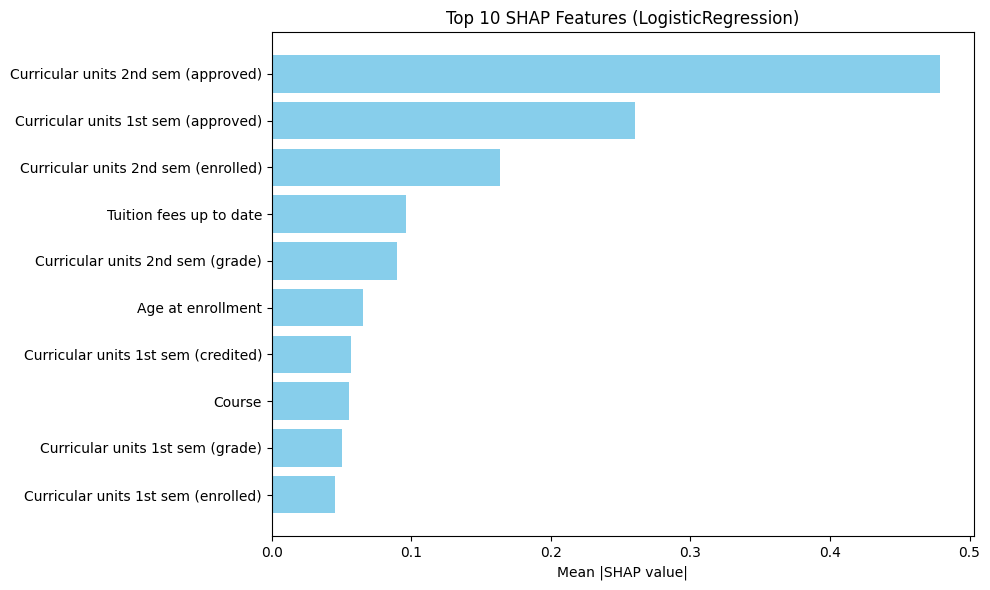

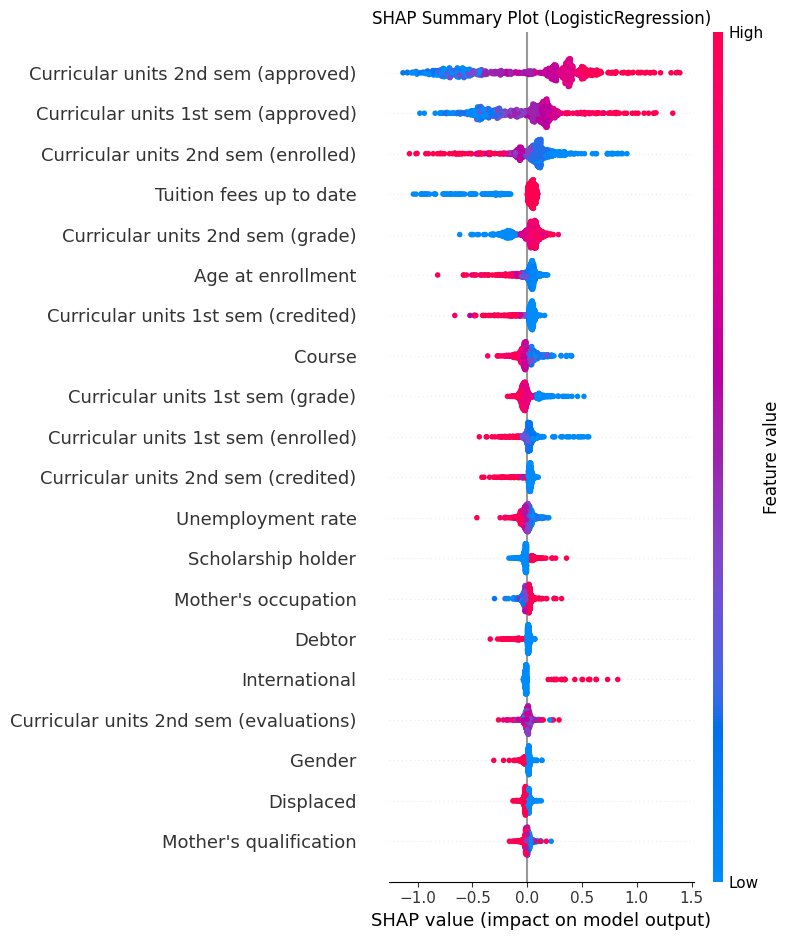

✅ SHAP completed for LogisticRegression
🔹 SHAP for RandomForest...


PermutationExplainer explainer: 886it [05:45,  2.49it/s]


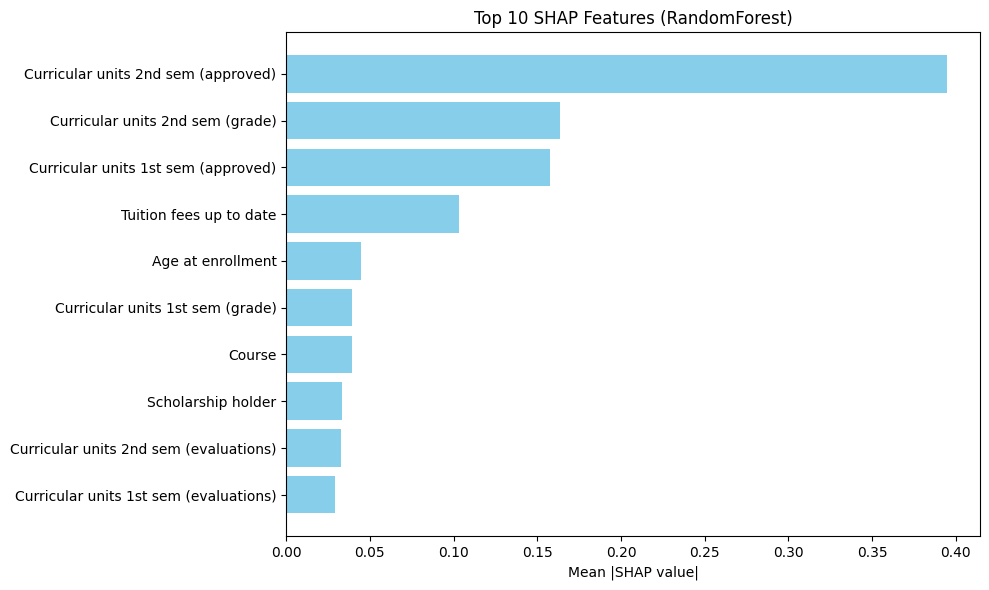

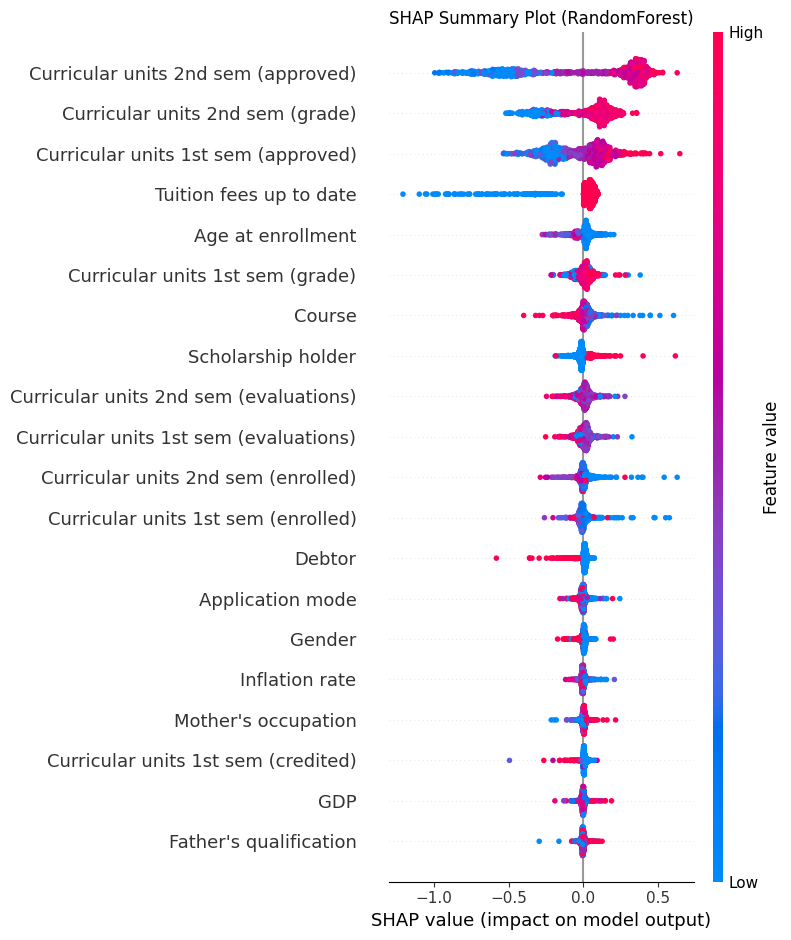

✅ SHAP completed for RandomForest
🔹 SHAP for XGBoost...


PermutationExplainer explainer: 886it [04:47,  2.97it/s]


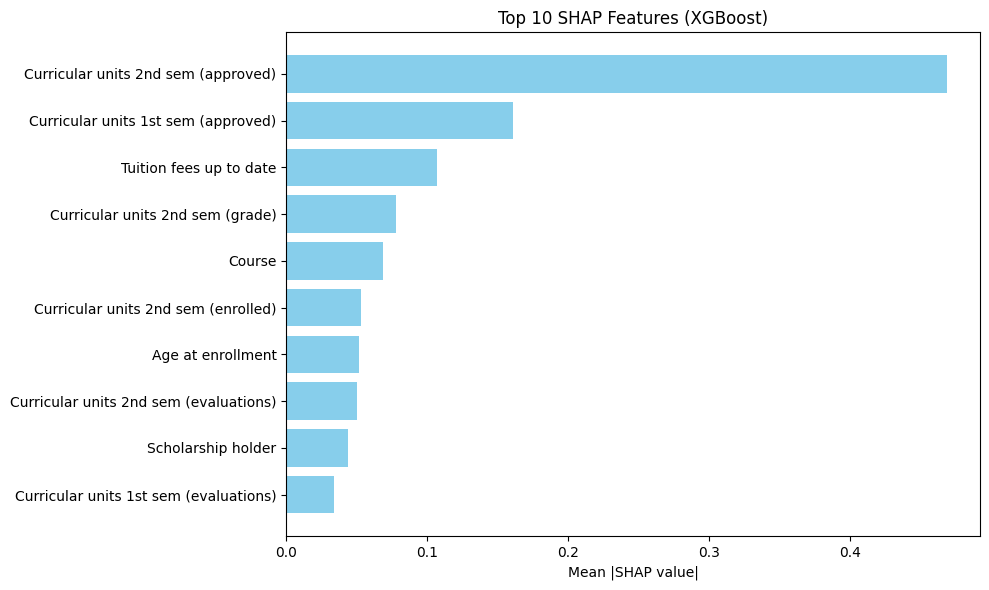

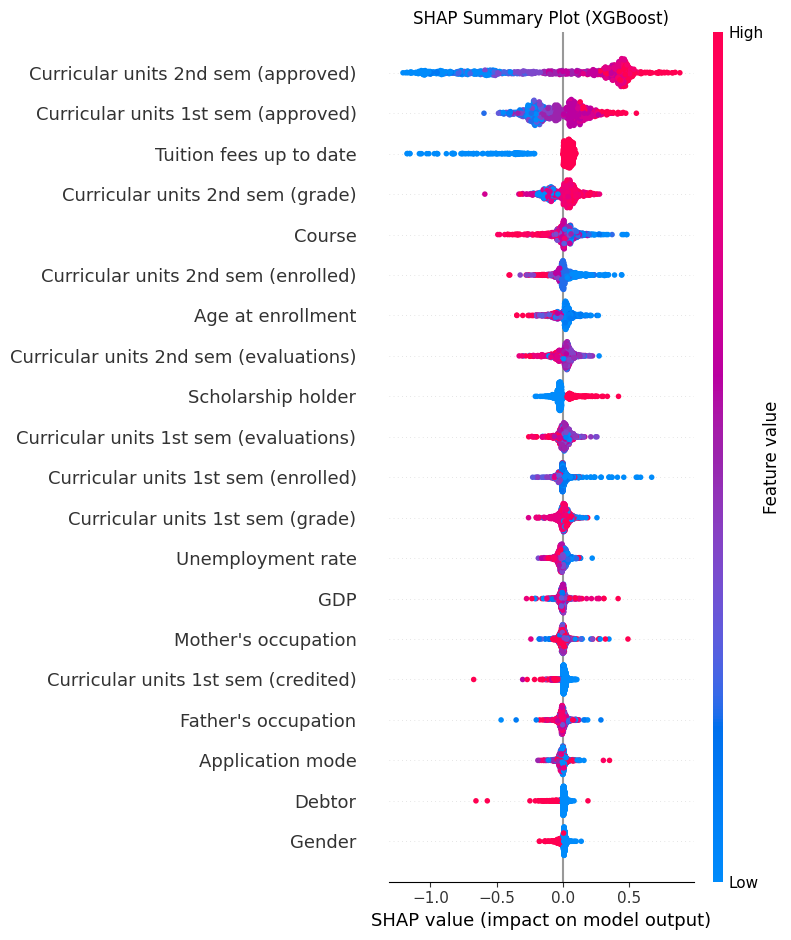

✅ SHAP completed for XGBoost
🔹 SHAP for LightGBM...


PermutationExplainer explainer: 886it [11:21,  1.28it/s]


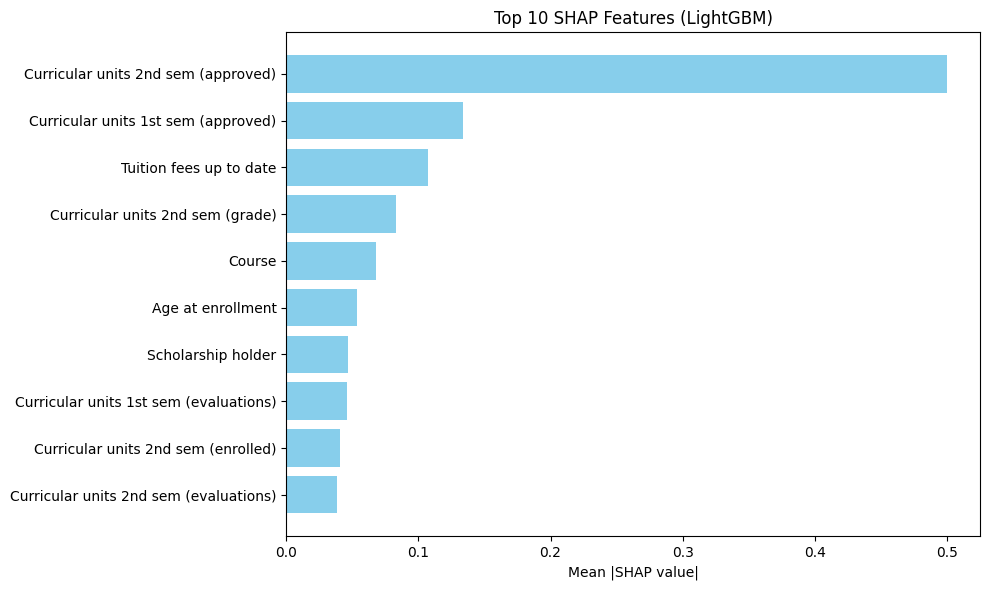

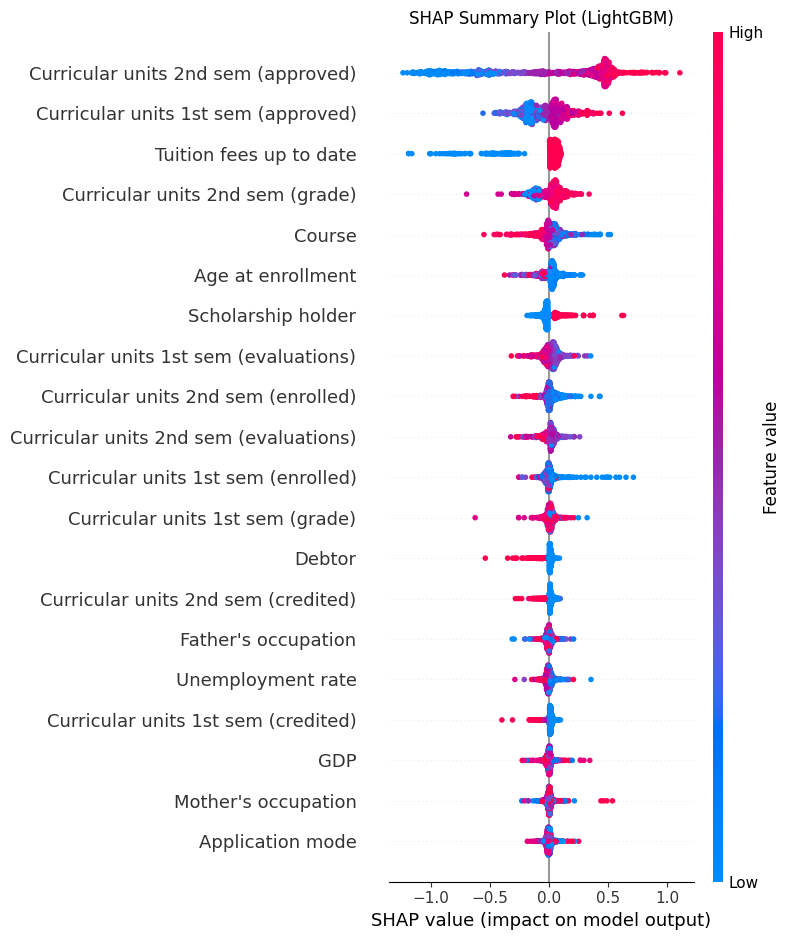

✅ SHAP completed for LightGBM
✅ Dropout Prediction Task Completed.
📊 Performance Metrics:
                Model  Accuracy        F1
0  LogisticRegression  0.755932  0.734545
1        RandomForest  0.772881  0.757176
2             XGBoost  0.762712  0.752441
3            LightGBM  0.766102  0.755815

📊 Regression-style Evaluation Metrics:
                Model       MAE      RMSE      MAPE (%)        R2
0  LogisticRegression  0.314124  0.454237  1.299435e+09  0.443401
1        RandomForest  0.289266  0.413559  1.378531e+09  0.493246
2             XGBoost  0.306215  0.444068  1.355932e+09  0.455863
3            LightGBM  0.302825  0.440678  1.401130e+09  0.460016

⚖️ Fairness Analysis:
                    LowIncome_Accuracy  HighIncome_Accuracy  Disparity
LogisticRegression            0.760369             0.751663   0.008706
RandomForest                  0.769585             0.776053   0.006468
XGBoost                       0.776498             0.749446   0.027052
LightGBM               

In [ ]:
# ============================== IMPORTS ==============================
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, mean_absolute_error,
                             mean_squared_error, r2_score)
import xgboost as xgb
import lightgbm as lgb
import os
from sklearn.metrics import mean_squared_error


# ============================== LOAD DATA =============================
file_path = '/content/retention/dataset.csv'  # Replace with your path
df = pd.read_csv(file_path)

# Drop missing target rows
df = df.dropna(subset=['Target'])
y = df['Target']
X = df.drop(columns=['Target'])

# Encode categorical features
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale for non-tree models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Encode target
y = LabelEncoder().fit_transform(y)

# ======================== TRAIN-TEST SPLIT ===========================
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
X_train_tree, X_test_tree, _, _ = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# ============================ TRAIN MODELS ============================
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

results = []
evaluation_results = []

for name, model in models.items():
    print(f"🔹 Training {name}...")
    if name in ['LogisticRegression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        X_eval = X_test_scaled
    else:
        model.fit(X_train_tree, y_train)
        X_eval = X_test_tree

    # Predictions
    y_pred = model.predict(X_eval)

    # ================== PERFORMANCE METRICS ==================
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-8, None))) * 100

    results.append({'Model': name, 'Accuracy': acc, 'F1': f1})
    evaluation_results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape, 'R2': r2})

# Save metrics
results_df = pd.DataFrame(results)
results_df.to_csv('dropout_prediction_metrics.csv', index=False)
results_df.to_json('dropout_prediction_metrics.json', orient='records', indent=2)

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.to_csv('dropout_prediction_evaluation_matrix.csv', index=False)
evaluation_df.to_json('dropout_prediction_evaluation_matrix.json', orient='records', indent=2)

# ============================ SHAP ANALYSIS ===========================
shap_results = {}
for name, model in models.items():
    print(f"🔹 SHAP for {name}...")
    try:
        if name in ['RandomForest', 'LightGBM', 'XGBoost']:
            X_eval = X_test_tree
            explainer = shap.Explainer(model.predict, X_eval)
            shap_values = explainer(X_eval)
        else:  # LogisticRegression, SVM
            X_eval = X_test_scaled
            explainer = shap.Explainer(model.predict, X_eval)
            shap_values = explainer(X_eval)

        # Handle multiclass SHAP outputs
        vals = shap_values.values
        if isinstance(vals, list):
            vals = np.mean(np.abs(np.array(vals)), axis=0)
        else:
            vals = np.abs(vals)

        # Bar plot - top 10 features
        shap_abs_mean = np.mean(vals, axis=0)
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'MeanAbsSHAP': shap_abs_mean
        }).sort_values(by='MeanAbsSHAP', ascending=False)
        top_features = feature_importance.head(10)

        plt.figure(figsize=(10,6))
        plt.barh(top_features['Feature'][::-1], top_features['MeanAbsSHAP'][::-1], color='skyblue')
        plt.xlabel('Mean |SHAP value|')
        plt.title(f'Top 10 SHAP Features ({name})')
        plt.tight_layout()
        plt.savefig(f'shap_barplot_{name}.png', dpi=300)
        plt.show()

        # SHAP summary plot
        plt.figure(figsize=(10,6))
        shap.summary_plot(shap_values.values if hasattr(shap_values, "values") else shap_values,
                          X_eval,
                          feature_names=X.columns,
                          show=False)
        plt.title(f'SHAP Summary Plot ({name})')
        plt.tight_layout()
        plt.savefig(f'shap_summary_{name}.png', dpi=300)
        plt.show()

        shap_results[name] = shap_values
        print(f"✅ SHAP completed for {name}")

    except Exception as e:
        print(f"⚠️ SHAP failed for {name}: {e}")

# ========================== SYNTHETIC FAIRNESS =========================
np.random.seed(42)
demographic = np.random.choice(['LowIncome', 'HighIncome'], size=len(y_test))
fairness = {}

for name, model in models.items():
    if name in ['LogisticRegression', 'SVM']:
        X_eval = X_test_scaled
    else:
        X_eval = X_test_tree

    y_pred = model.predict(X_eval)
    groupA_mask = demographic == 'LowIncome'
    groupB_mask = demographic == 'HighIncome'
    groupA_acc = accuracy_score(y_test[groupA_mask], y_pred[groupA_mask])
    groupB_acc = accuracy_score(y_test[groupB_mask], y_pred[groupB_mask])
    disparity = abs(groupA_acc - groupB_acc)
    fairness[name] = {
        'LowIncome_Accuracy': groupA_acc,
        'HighIncome_Accuracy': groupB_acc,
        'Disparity': disparity
    }

fairness_df = pd.DataFrame(fairness).T
fairness_df.to_csv('dropout_prediction_fairness.csv')
fairness_df.to_json('dropout_prediction_fairness.json', orient='records', indent=2)

# ======================== EDUCATIONAL AI READINESS =====================
def compute_readiness_index(model_name, interpretability, fairness, scalability, accuracy, data_quality):
    return {
        'Model': model_name,
        'Interpretability': interpretability,
        'Fairness': fairness,
        'Scalability': scalability,
        'Accuracy': accuracy,
        'Data Quality': data_quality,
        'Total_Score': interpretability + fairness + scalability + accuracy + data_quality
    }

readiness = []
for result in results:
    name = result['Model']
    readiness.append(compute_readiness_index(
        model_name=name,
        interpretability=4 if name in ['RandomForest', 'XGBoost', 'LightGBM'] else 3,
        fairness=3,
        scalability=4,
        accuracy=round(result['Accuracy']*5,2),
        data_quality=4
    ))

readiness_df = pd.DataFrame(readiness)
readiness_df.to_csv('dropout_prediction_readiness_index.csv', index=False)
readiness_df.to_json('dropout_prediction_readiness_index.json', orient='records', indent=2)

# ========================== DISPLAY RESULTS ===========================
print("✅ Dropout Prediction Task Completed.")
print("📊 Performance Metrics:")
print(results_df)
print("\n📊 Regression-style Evaluation Metrics:")
print(evaluation_df)
print("\n⚖️ Fairness Analysis:")
print(fairness_df)
print("\n📈 Educational AI Readiness Index:")
print(readiness_df)


## BUDGET PREDICTION

Training shape: (400277, 26) Test shape: (50064, 17)
Labels: ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
Feature matrix shape: (400277, 10002)

=== Label: Function ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

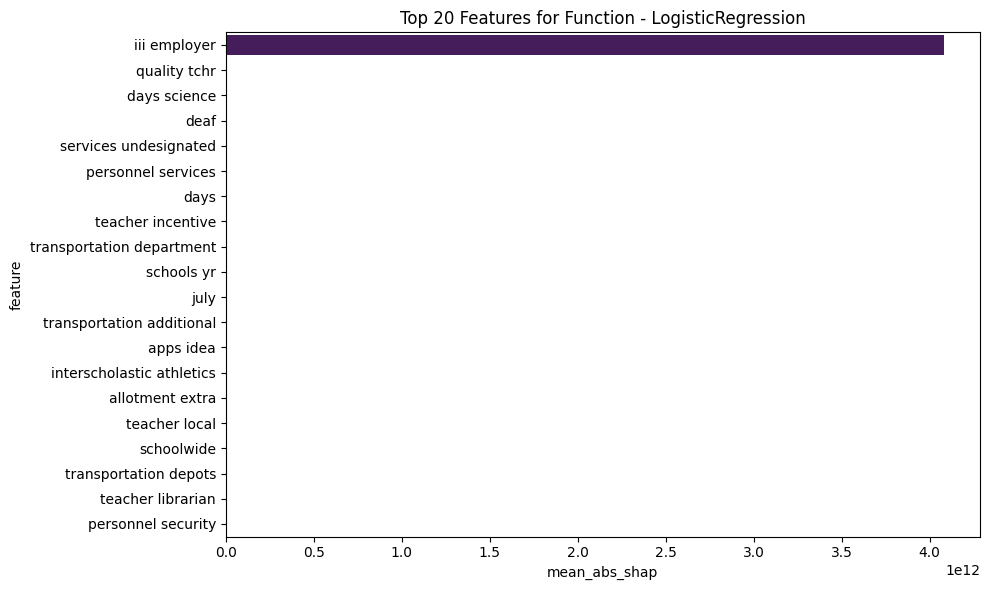

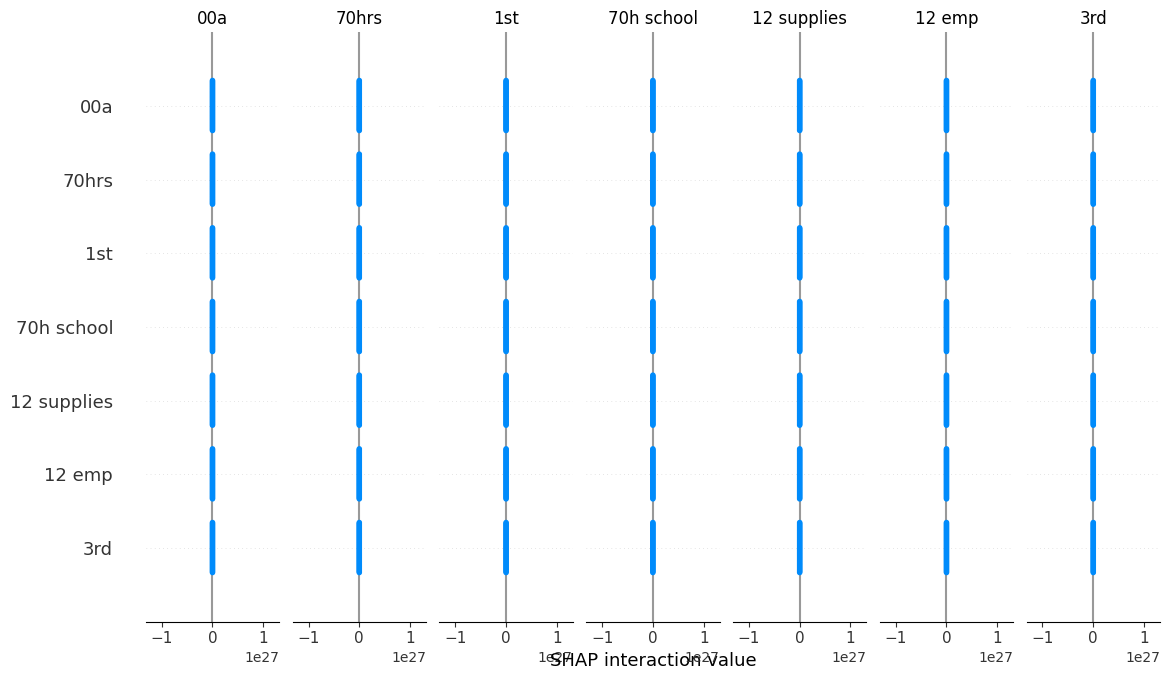


--- Training RandomForest ---
📌 Computing SHAP values...


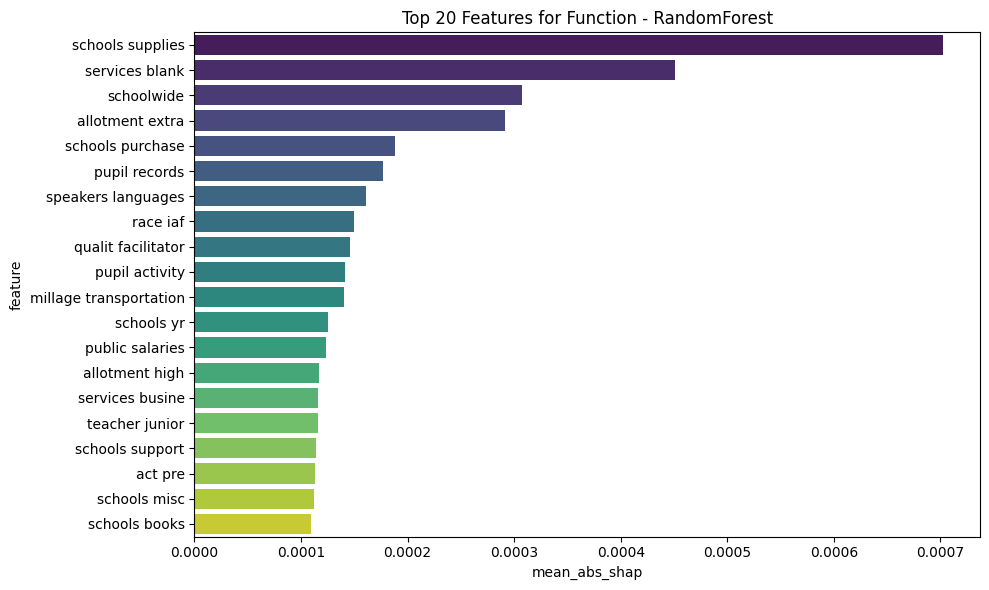

SHAP not available for RandomForest: index 488 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


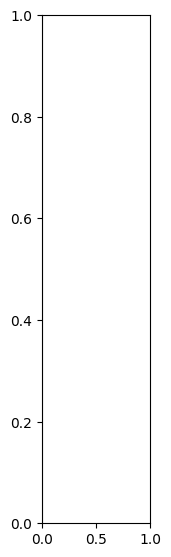

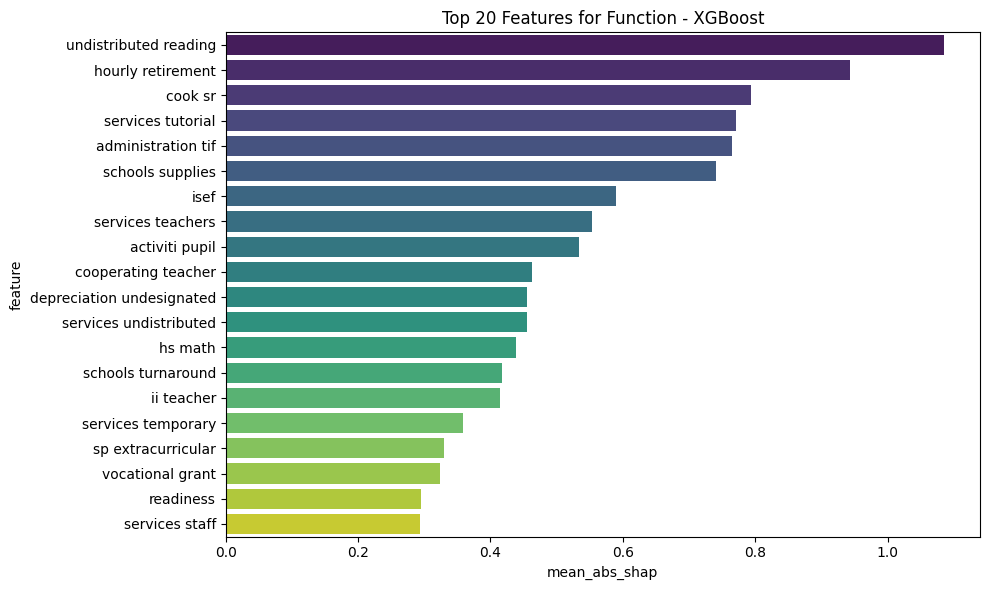

SHAP not available for XGBoost: index 267 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


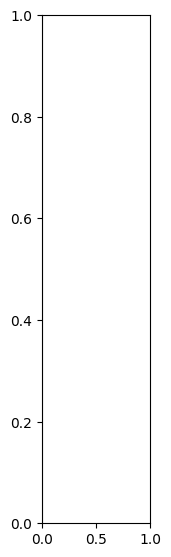

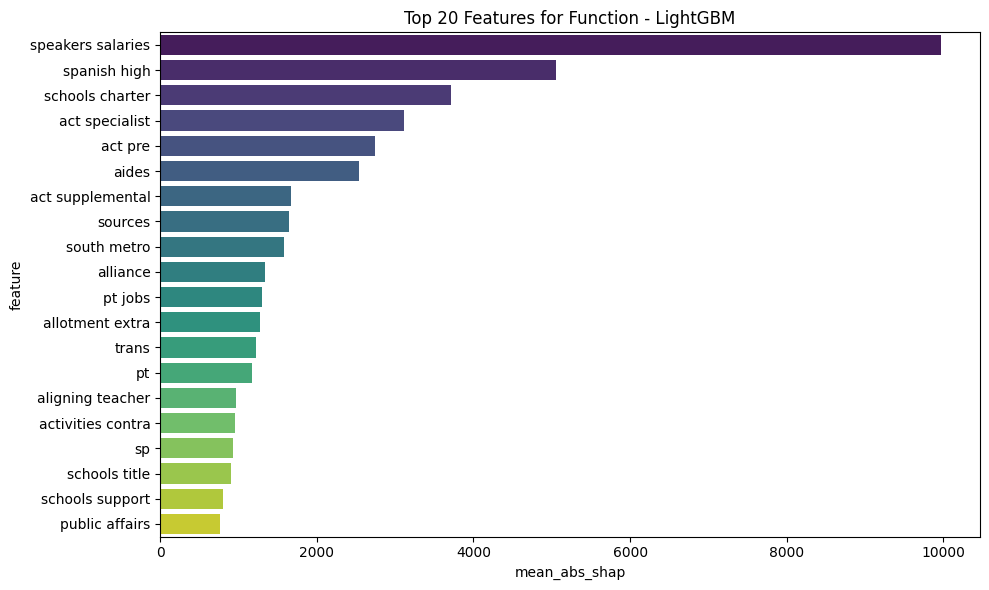

SHAP not available for LightGBM: index 429 is out of bounds for axis 0 with size 50

=== Label: Object_Type ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

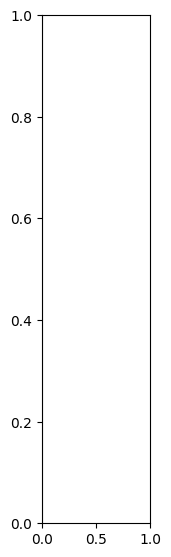

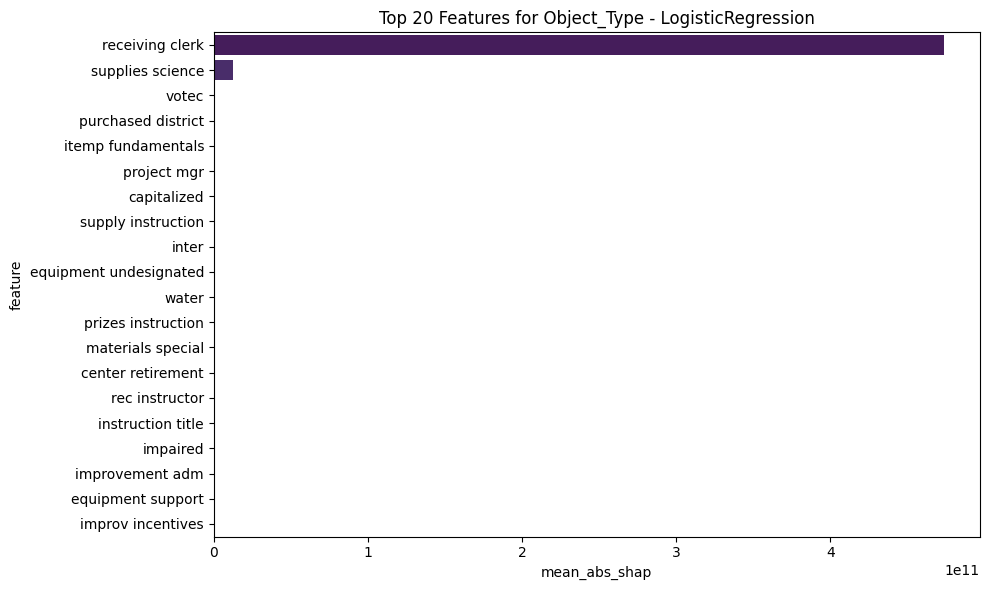

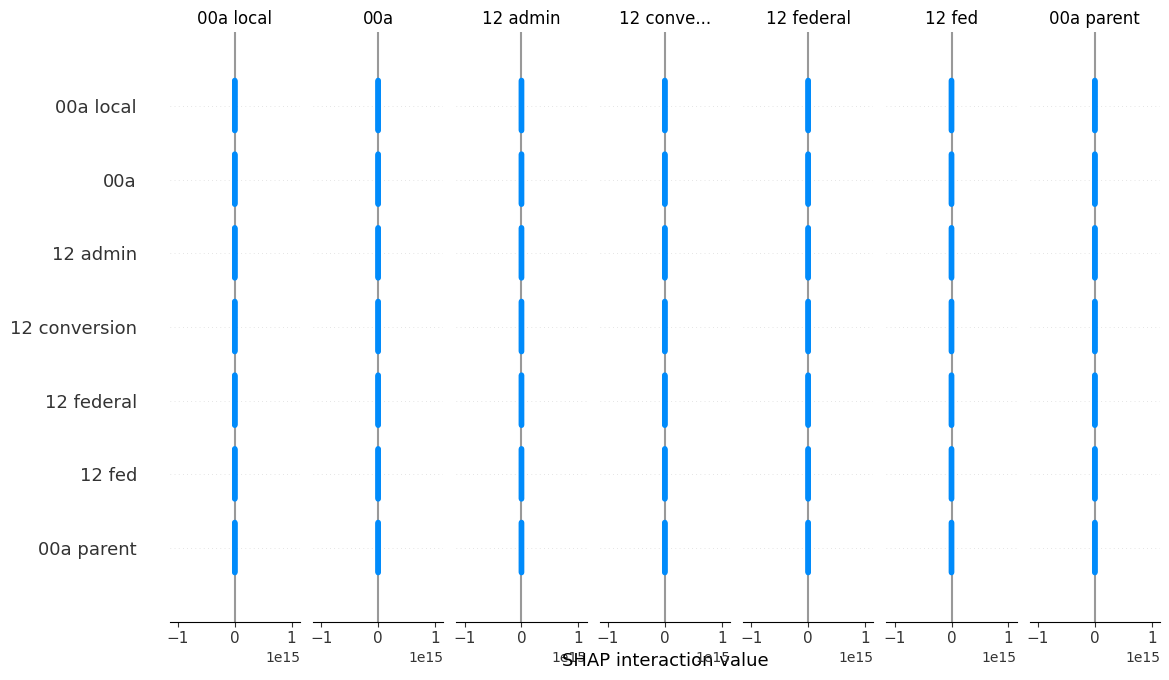


--- Training RandomForest ---
📌 Computing SHAP values...


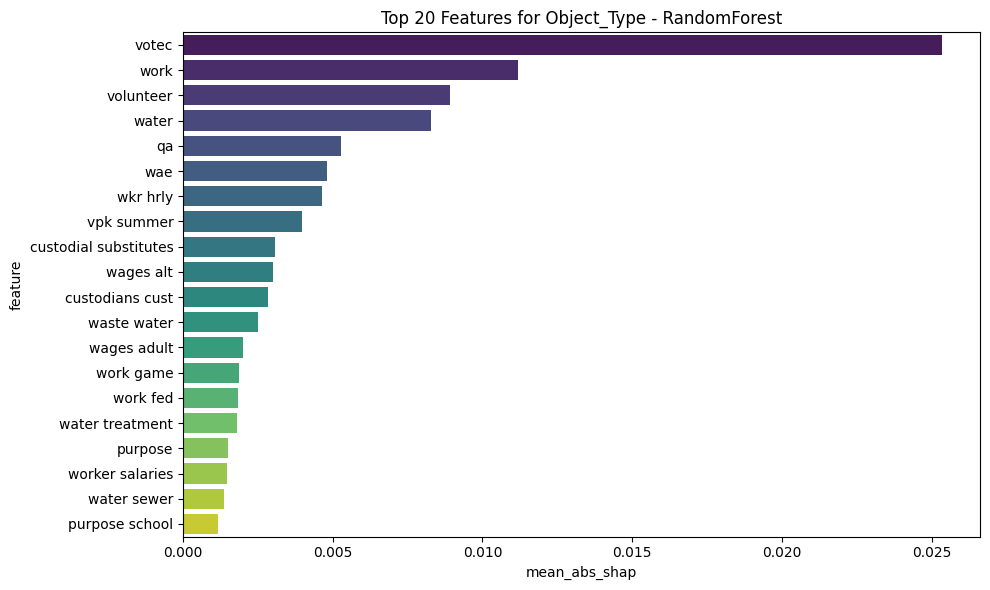

SHAP not available for RandomForest: index 173 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


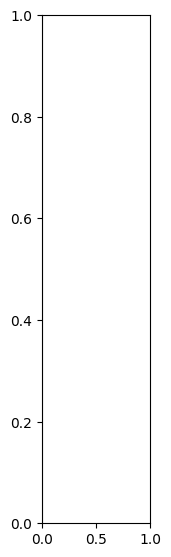

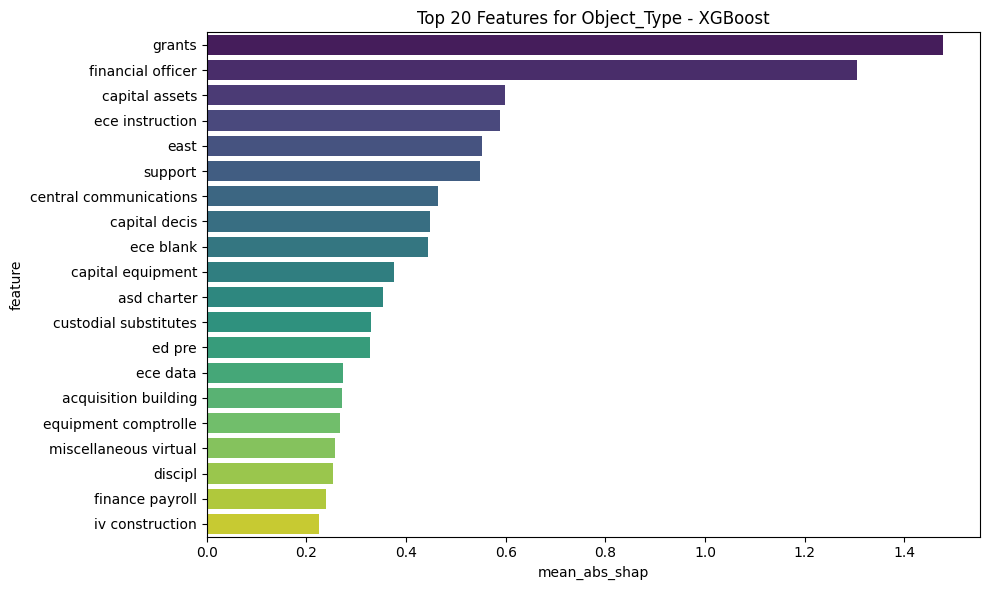

SHAP not available for XGBoost: index 179 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


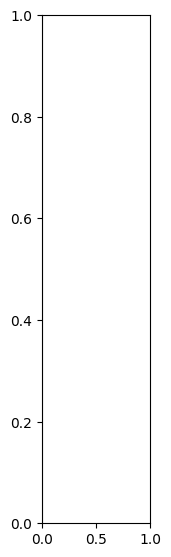

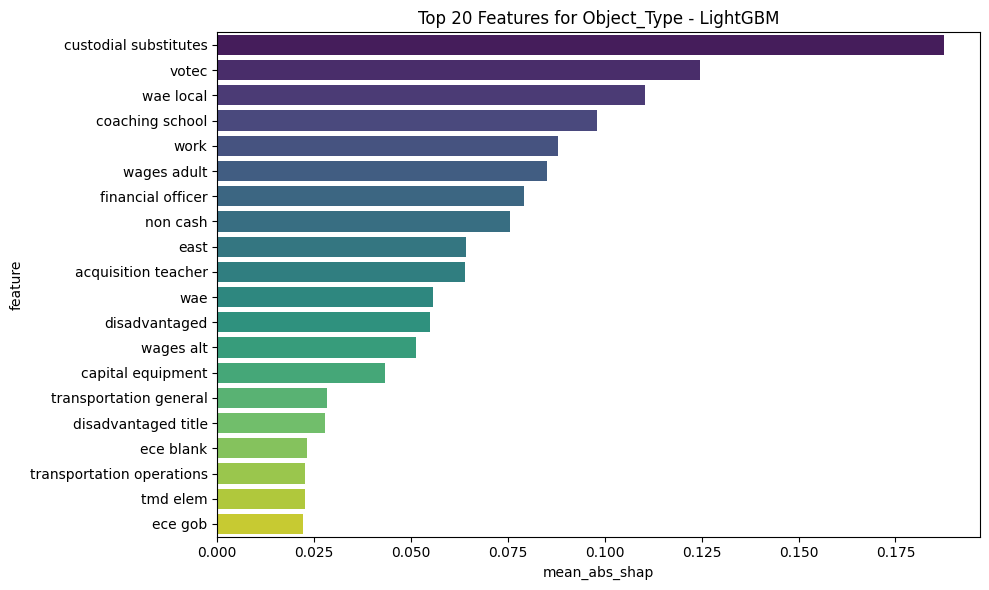

SHAP not available for LightGBM: index 438 is out of bounds for axis 0 with size 50

=== Label: Operating_Status ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

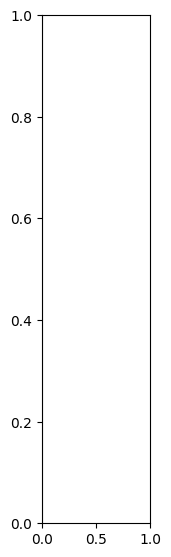

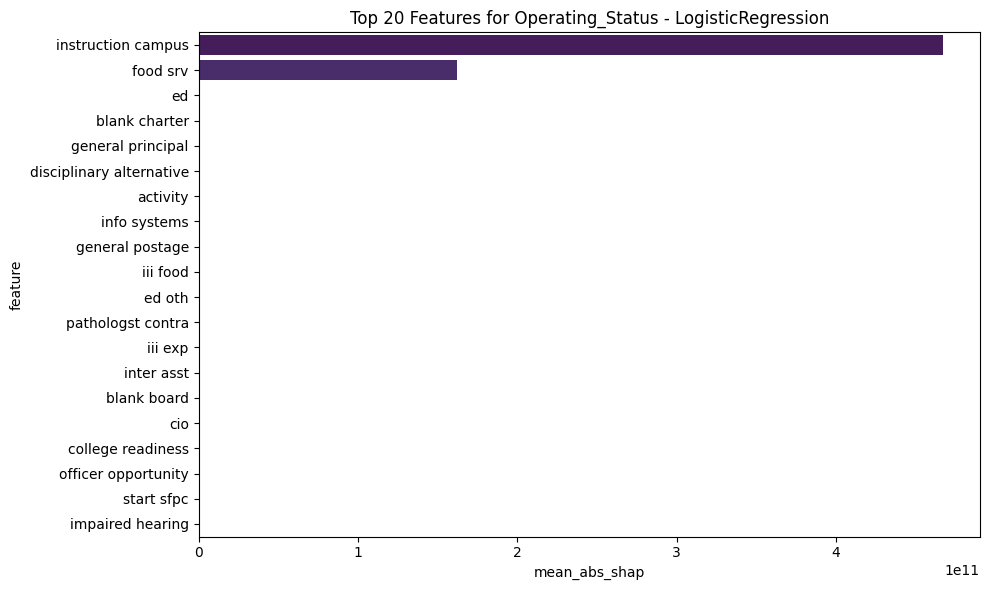

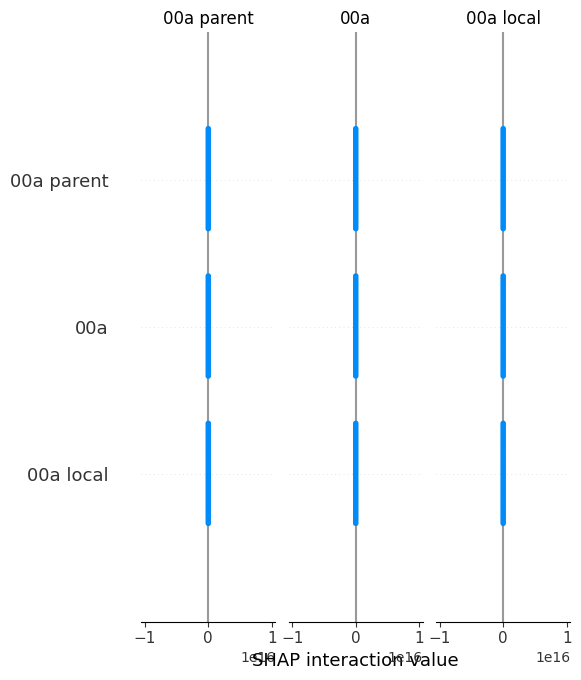


--- Training RandomForest ---
📌 Computing SHAP values...


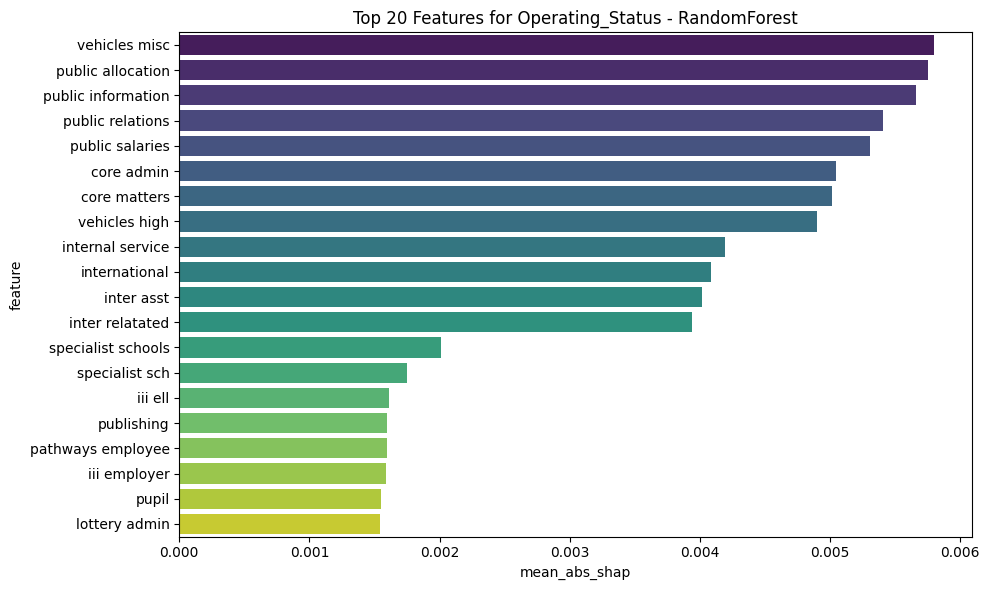

SHAP not available for RandomForest: index 329 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


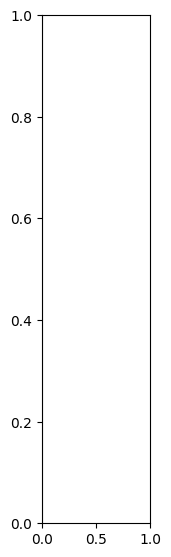

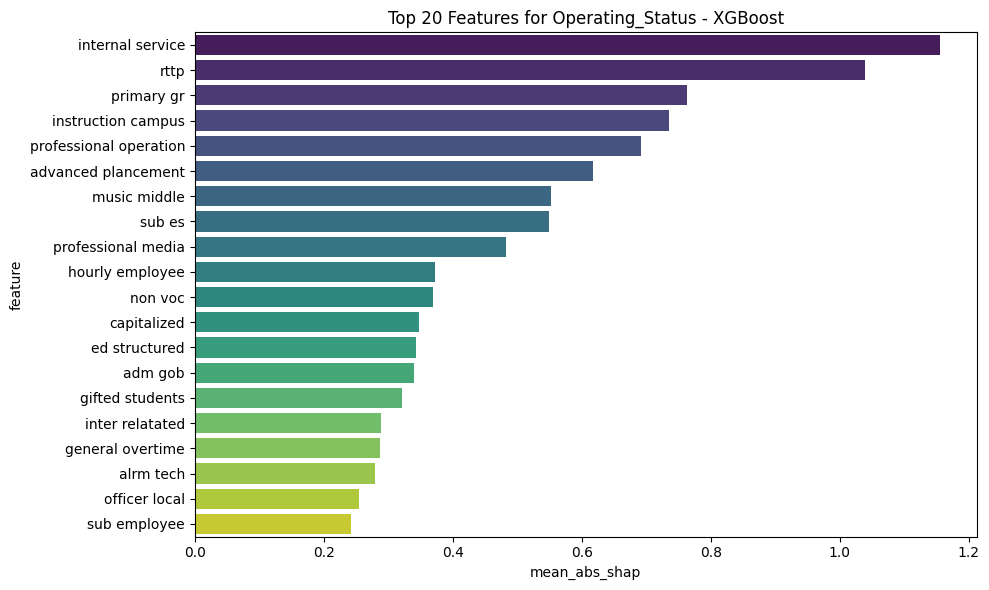

SHAP not available for XGBoost: index 167 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


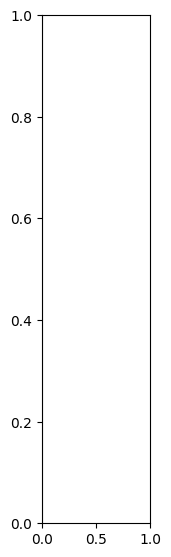

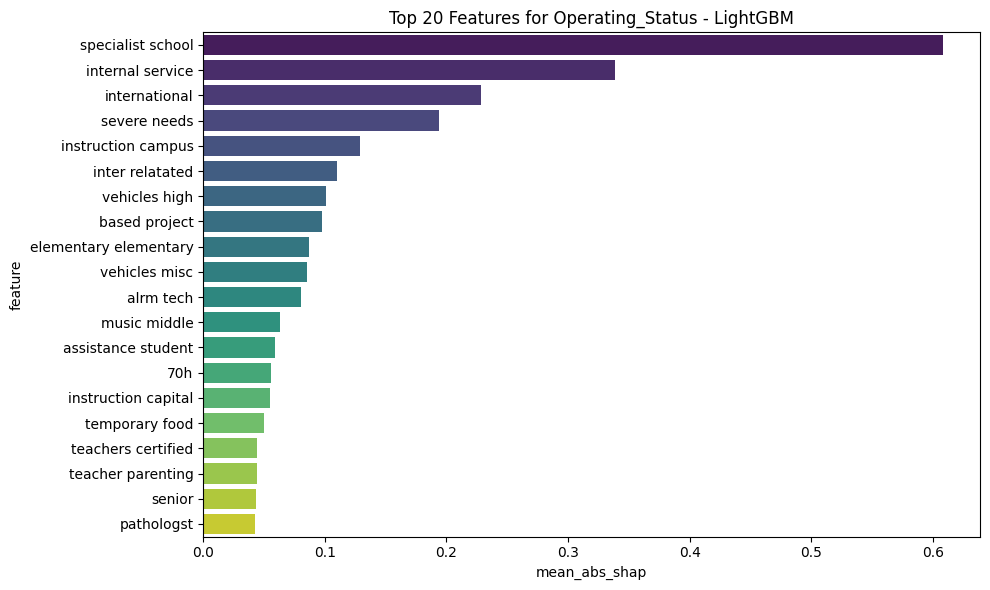

SHAP not available for LightGBM: index 422 is out of bounds for axis 0 with size 50

=== Label: Position_Type ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

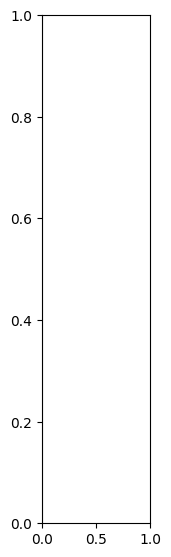

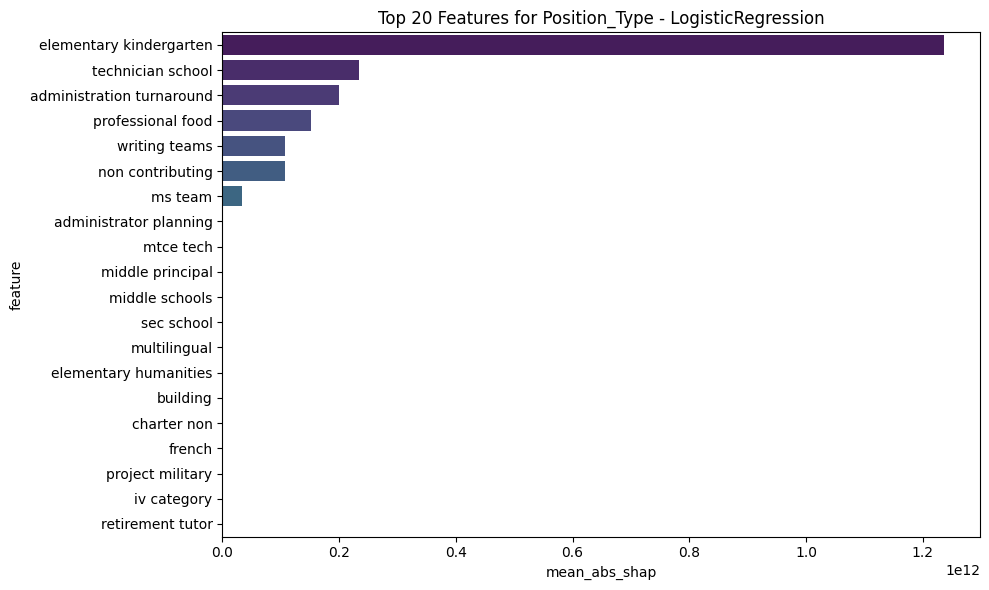

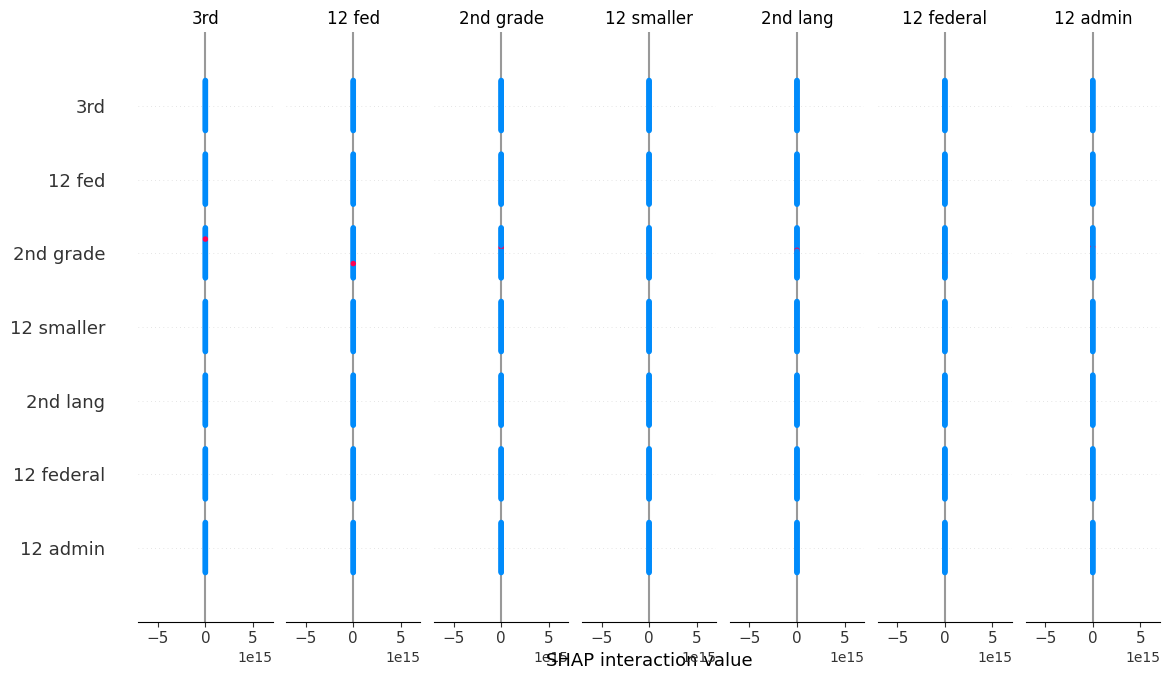


--- Training RandomForest ---
📌 Computing SHAP values...


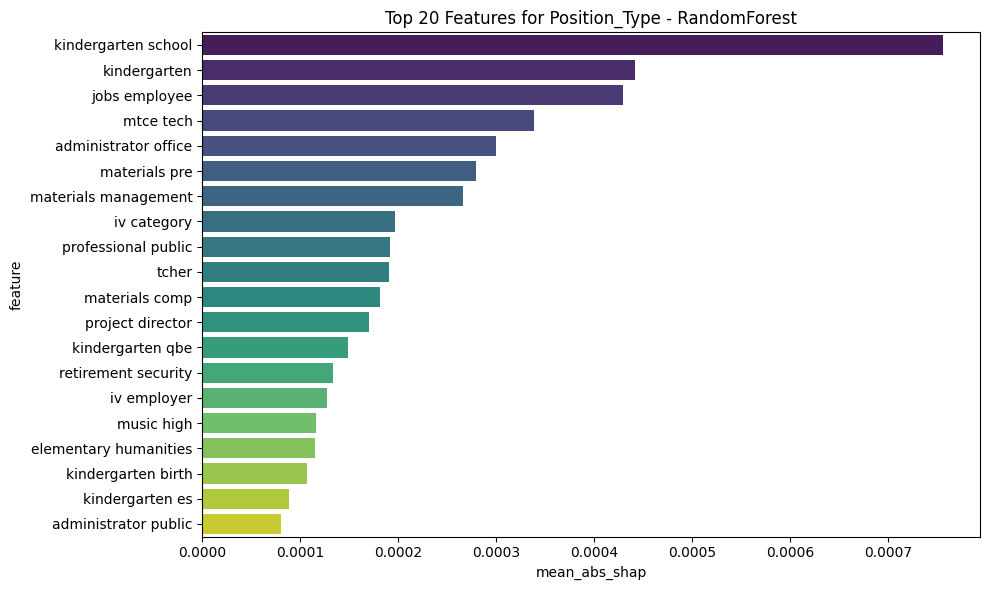

SHAP not available for RandomForest: index 469 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


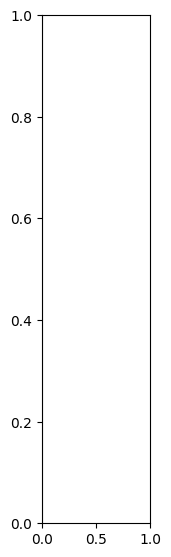

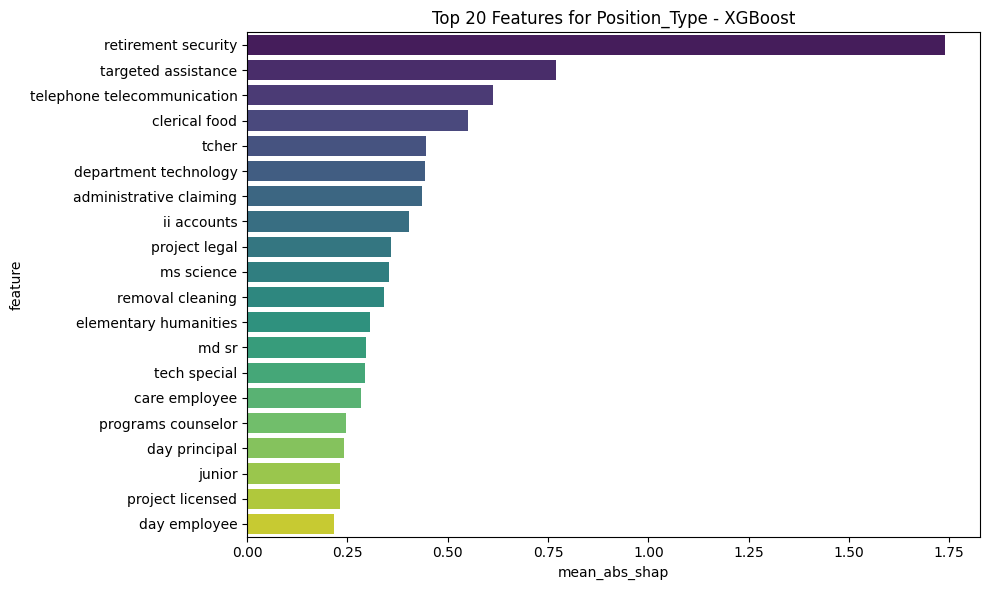

SHAP not available for XGBoost: index 368 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


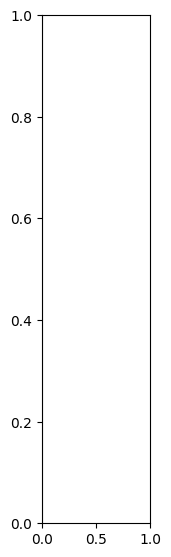

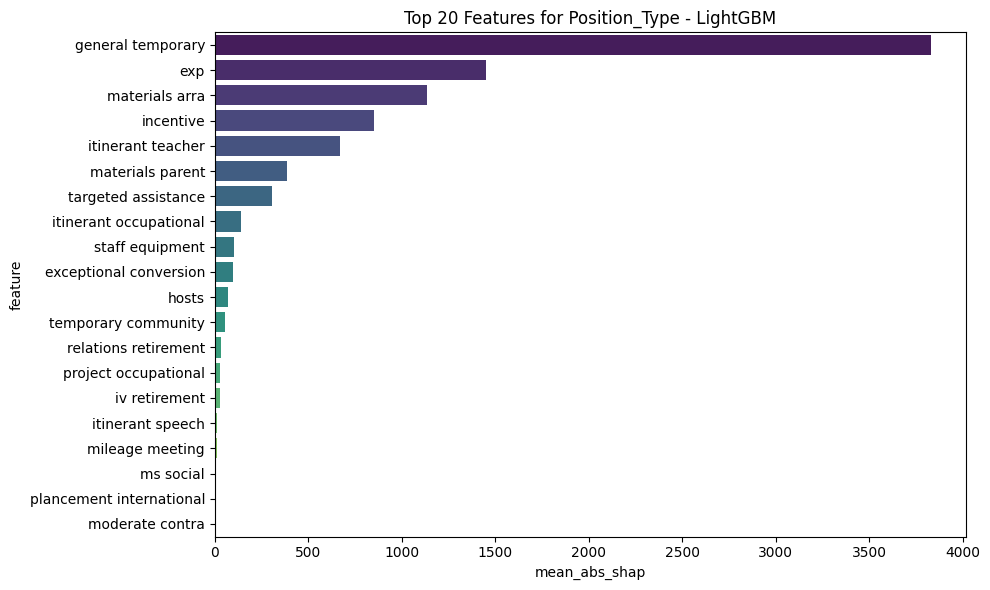

SHAP not available for LightGBM: index 488 is out of bounds for axis 0 with size 50

=== Label: Pre_K ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

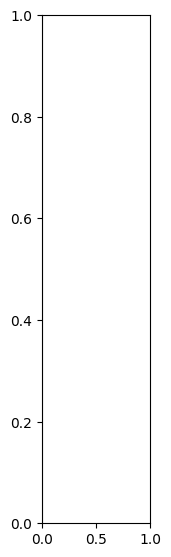

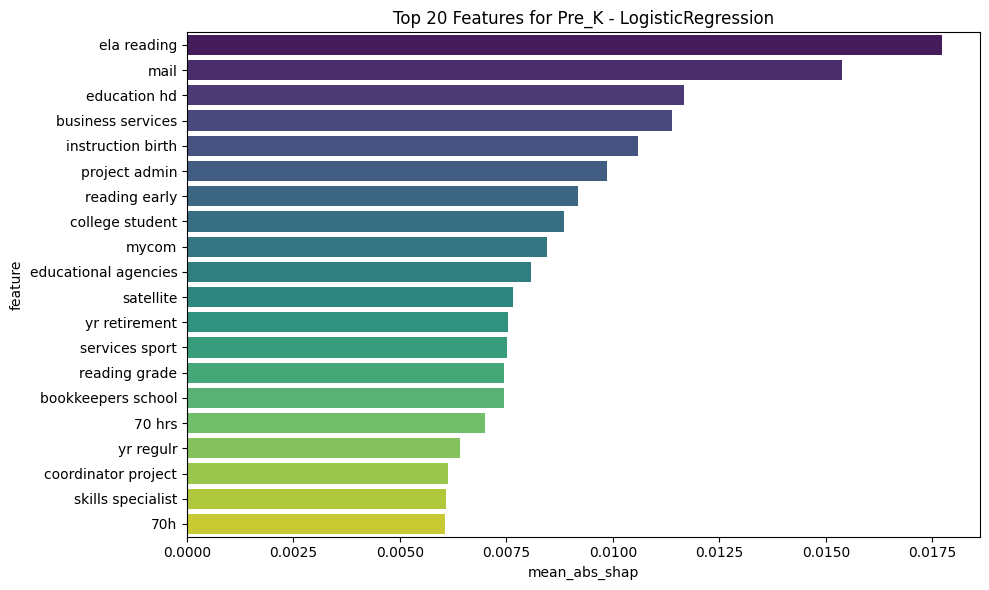

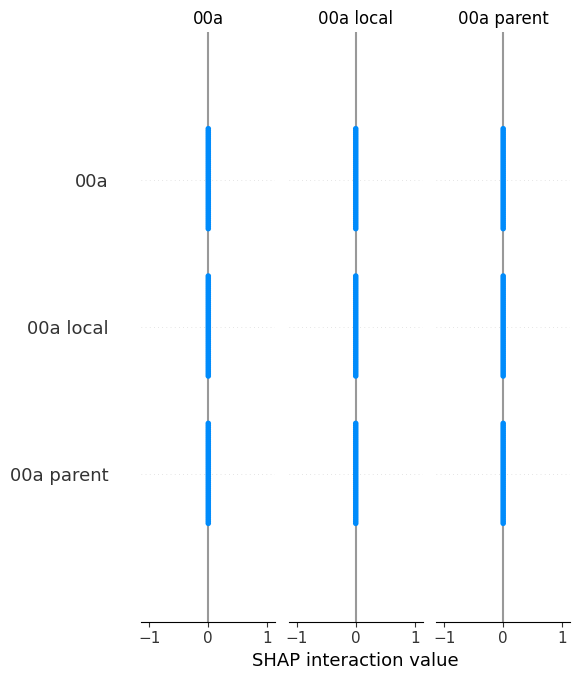


--- Training RandomForest ---
📌 Computing SHAP values...


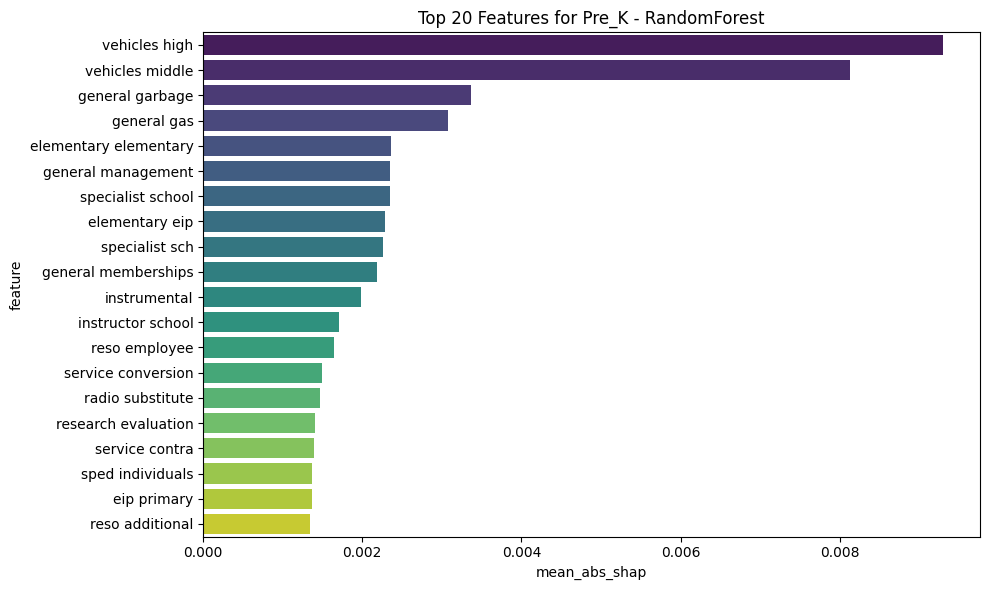

SHAP not available for RandomForest: index 469 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


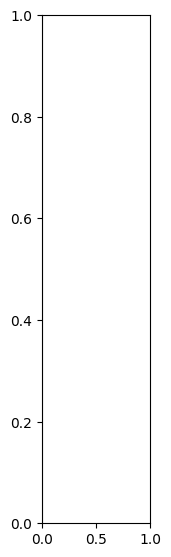

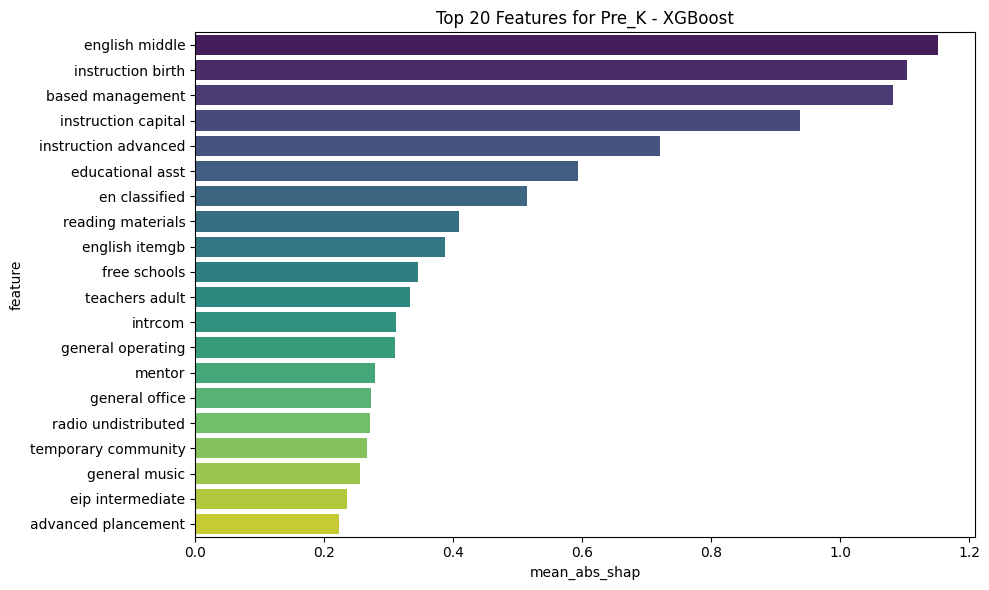

SHAP not available for XGBoost: index 217 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


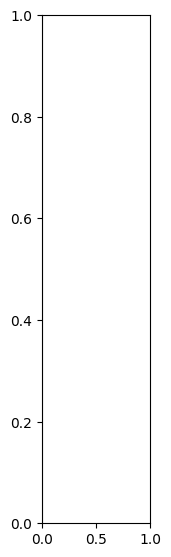

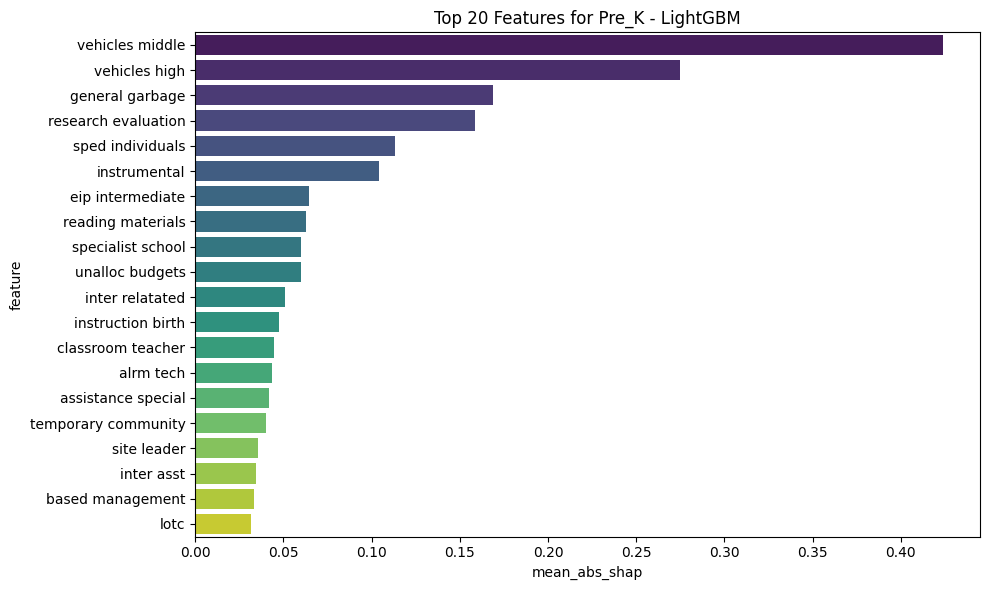

SHAP not available for LightGBM: index 159 is out of bounds for axis 0 with size 50

=== Label: Reporting ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

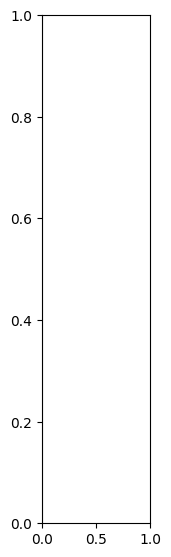

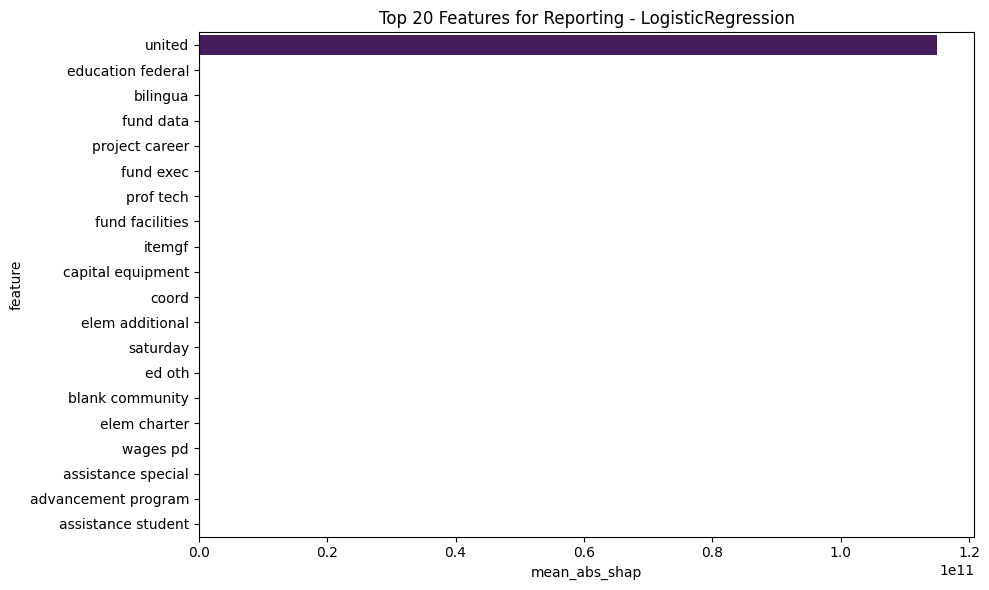

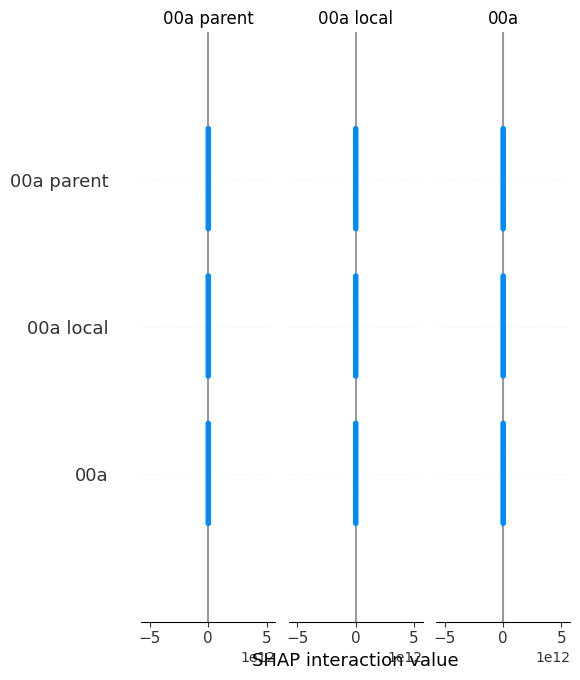


--- Training RandomForest ---
📌 Computing SHAP values...


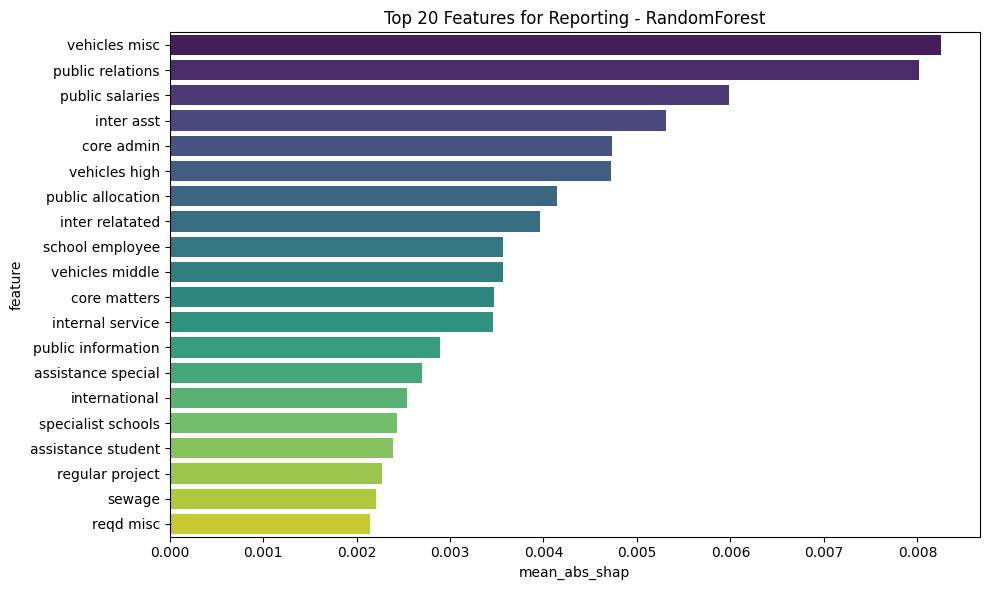

SHAP not available for RandomForest: index 232 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


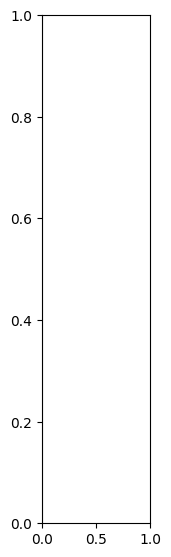

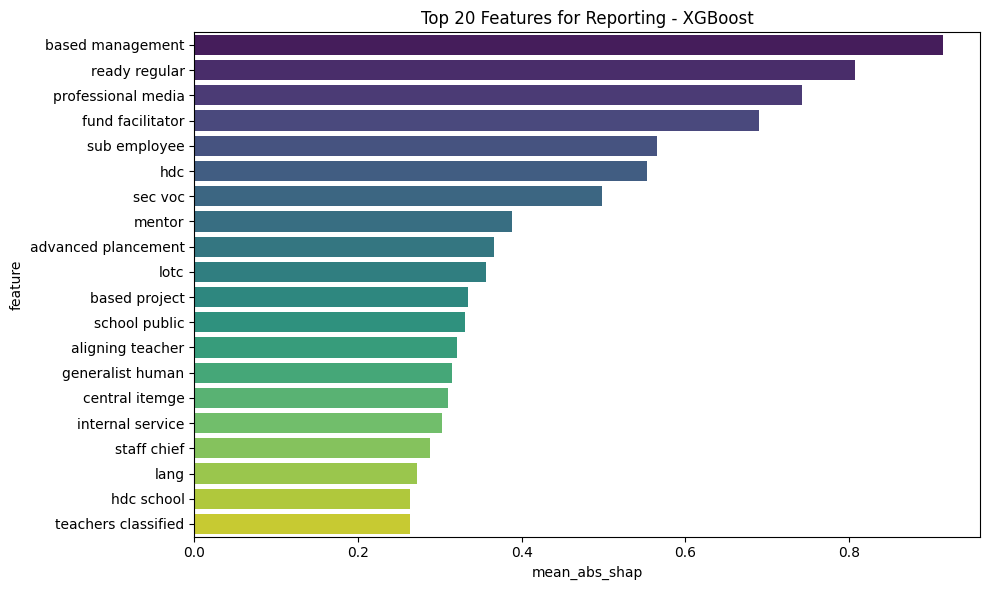

SHAP not available for XGBoost: index 65 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


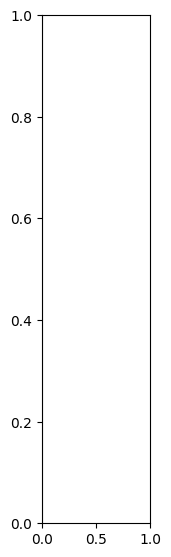

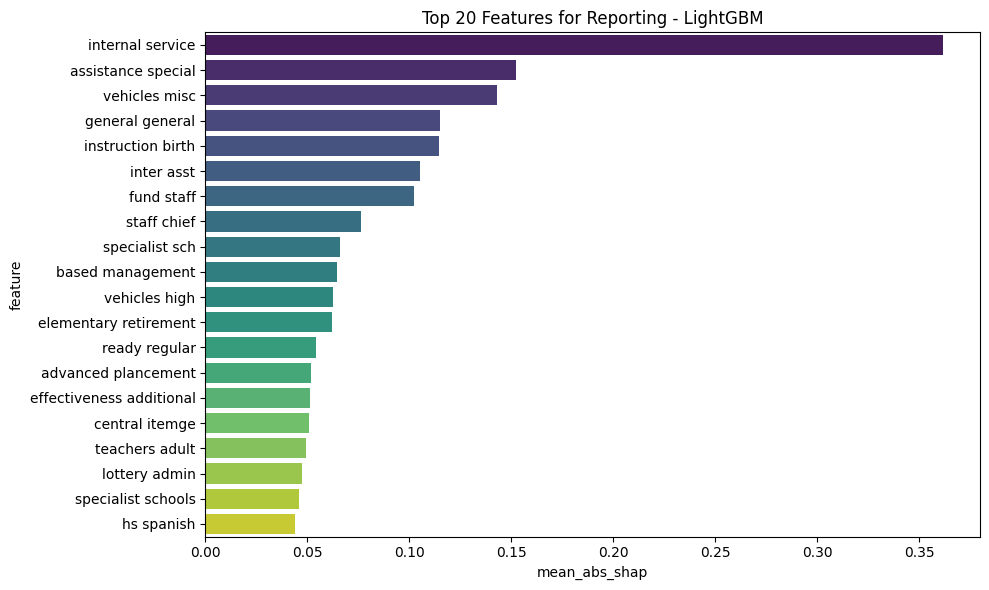

SHAP not available for LightGBM: index 56 is out of bounds for axis 0 with size 50

=== Label: Sharing ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

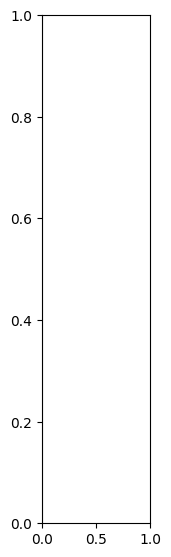

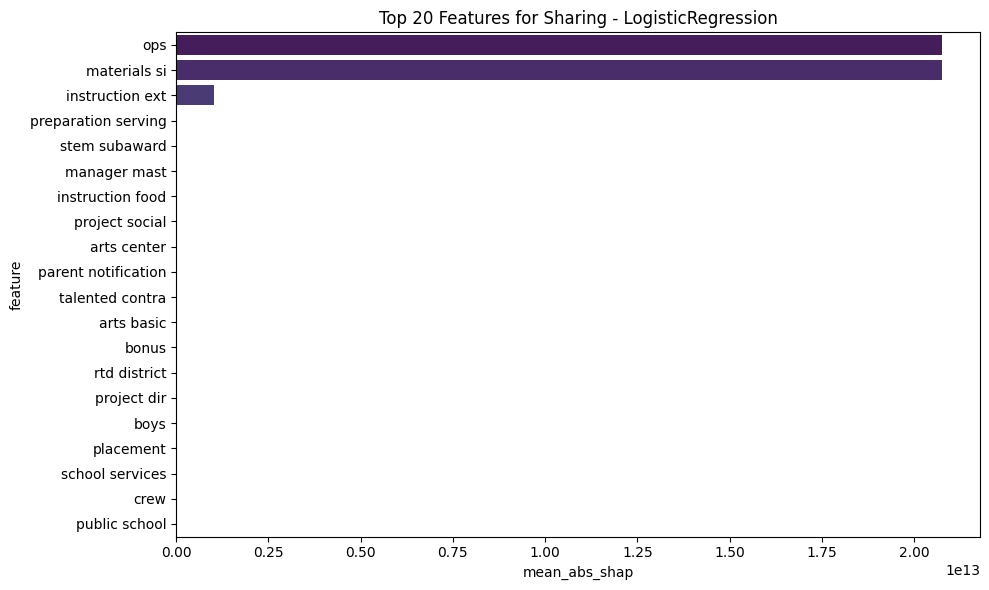

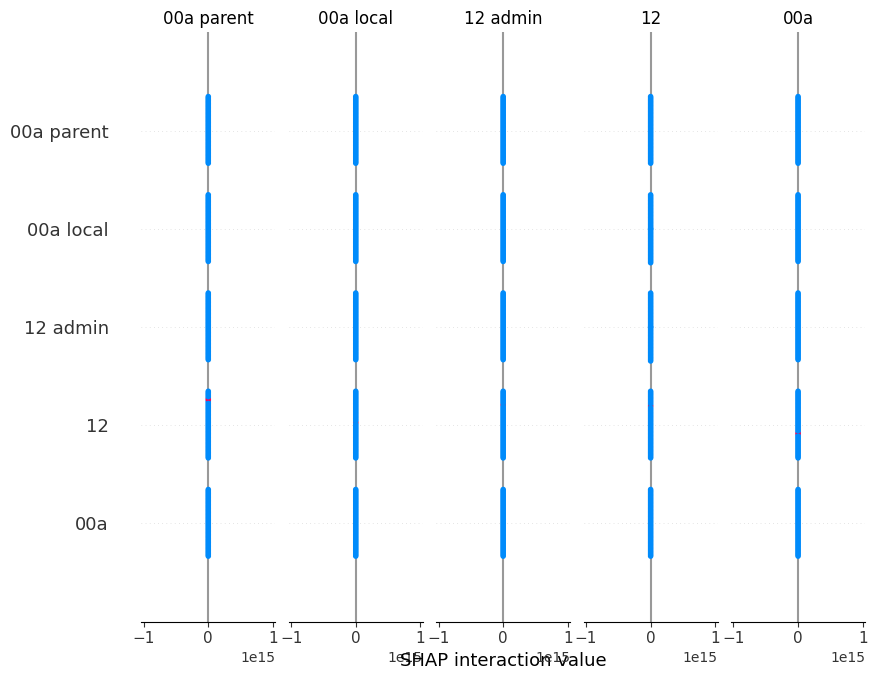


--- Training RandomForest ---
📌 Computing SHAP values...


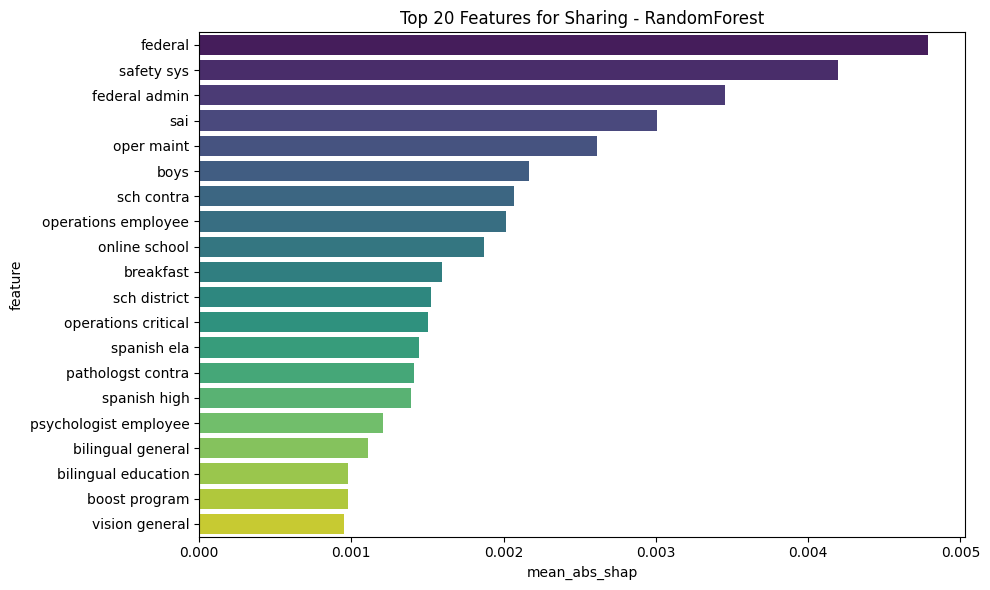

SHAP not available for RandomForest: index 367 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


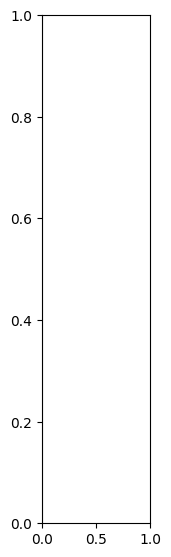

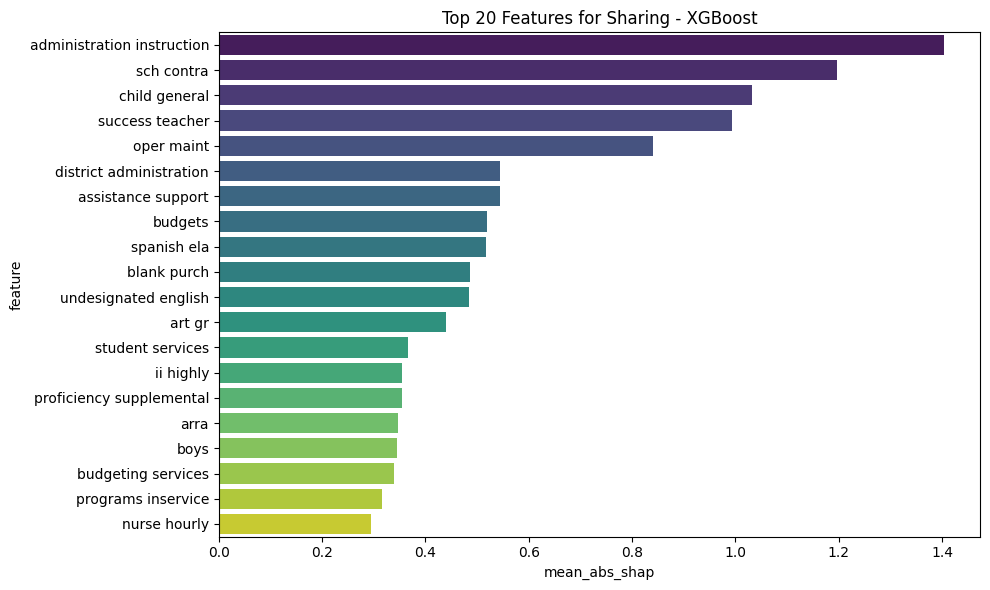

SHAP not available for XGBoost: index 447 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


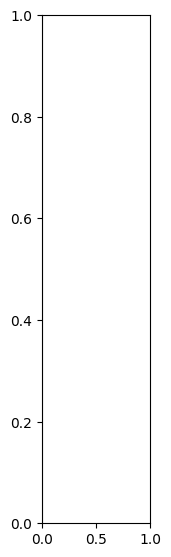

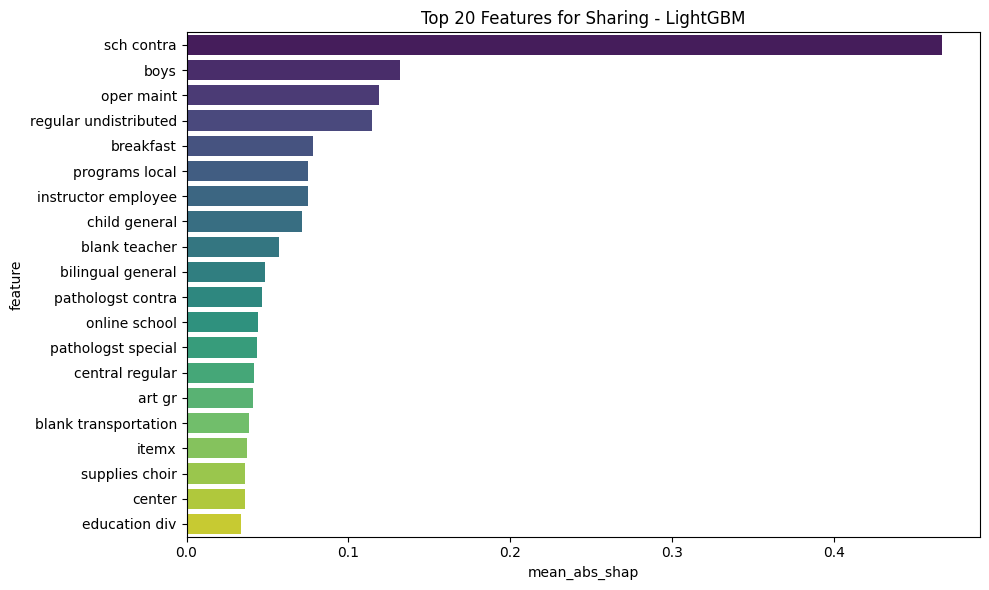

SHAP not available for LightGBM: index 249 is out of bounds for axis 0 with size 50

=== Label: Student_Type ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

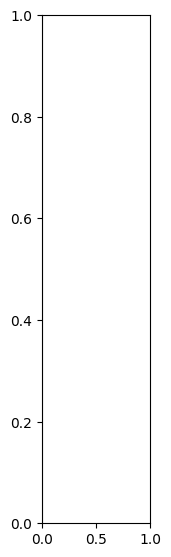

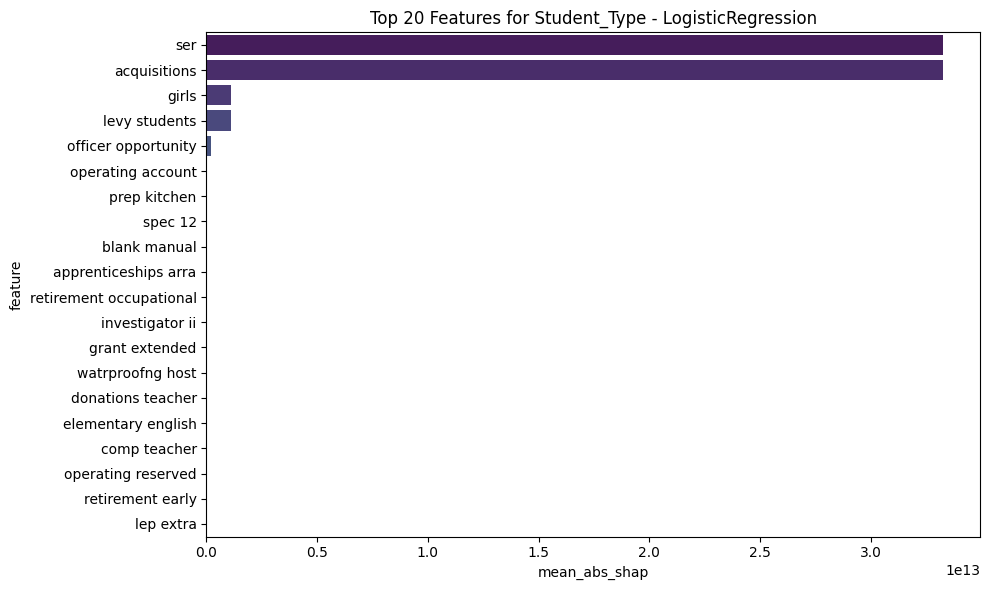

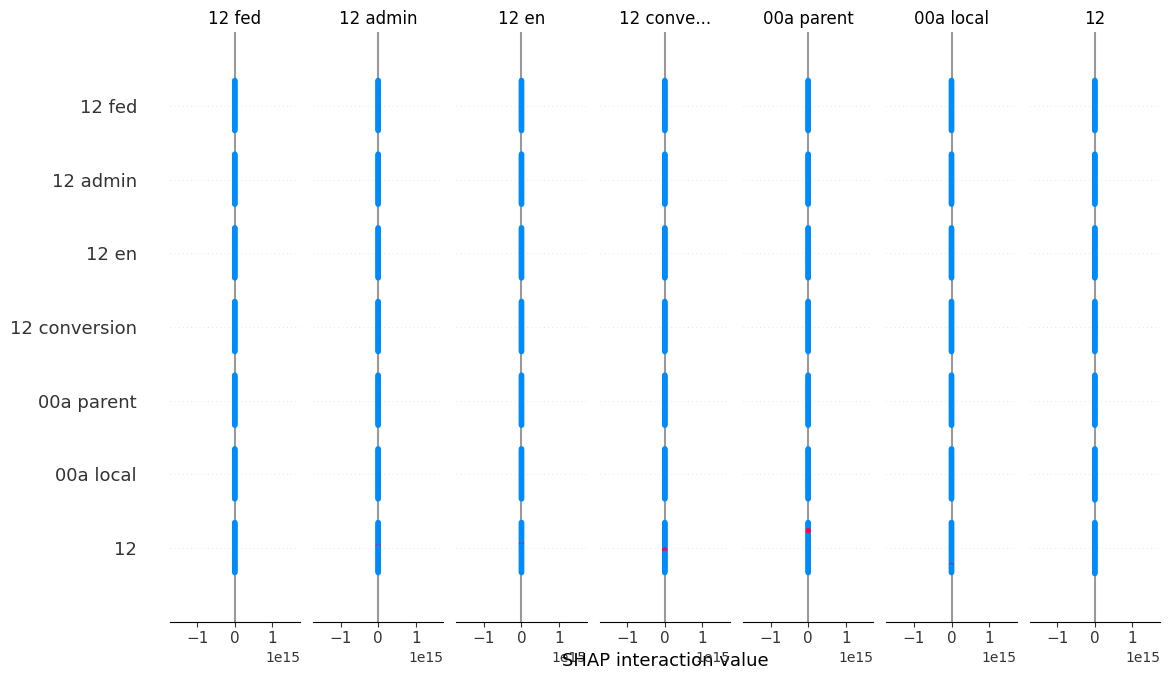


--- Training RandomForest ---
📌 Computing SHAP values...


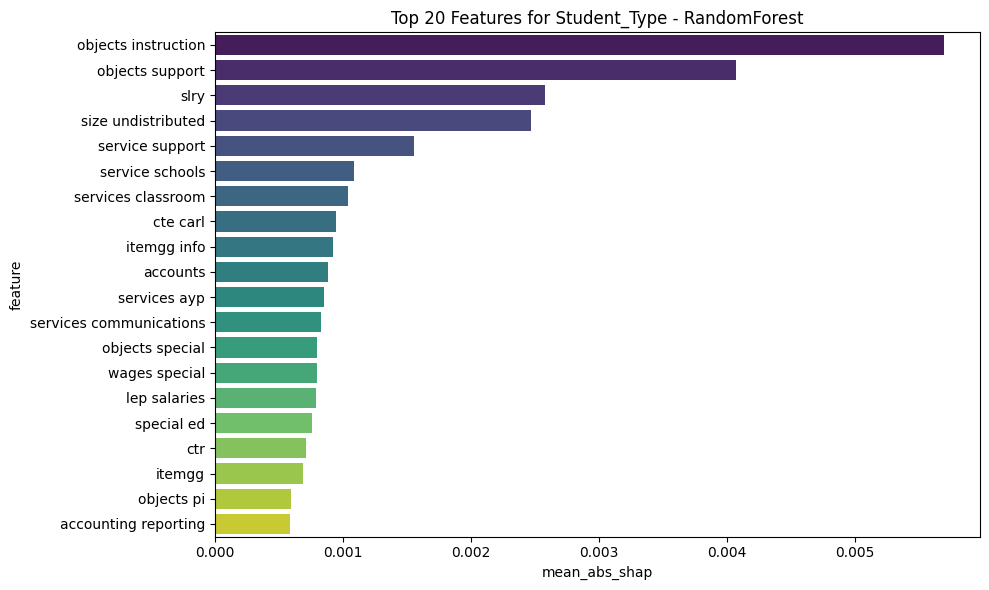

SHAP not available for RandomForest: index 254 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


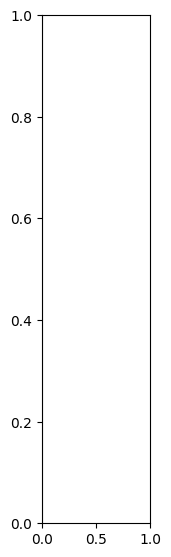

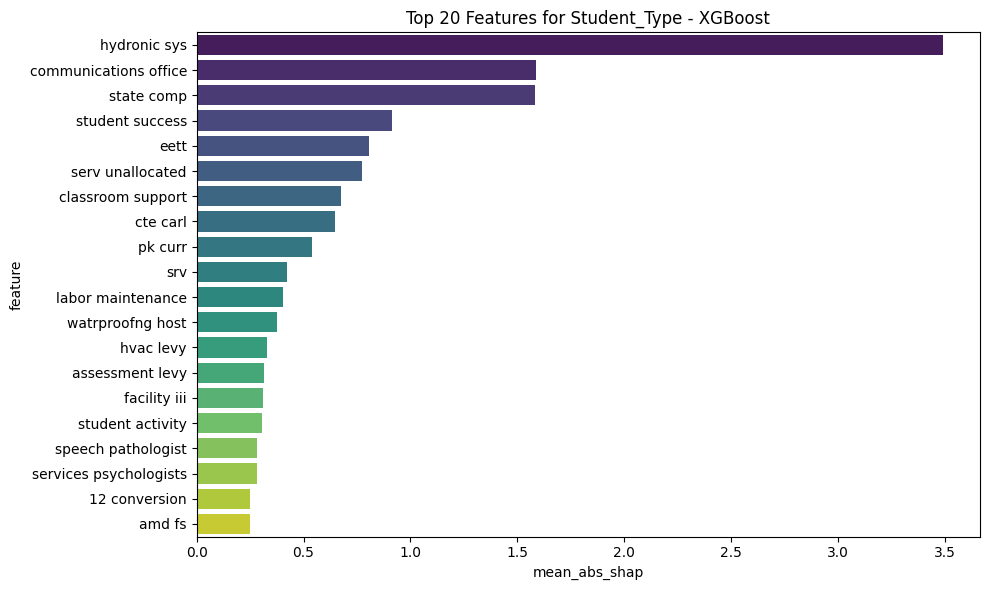

SHAP not available for XGBoost: index 283 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


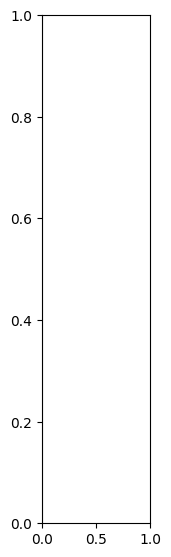

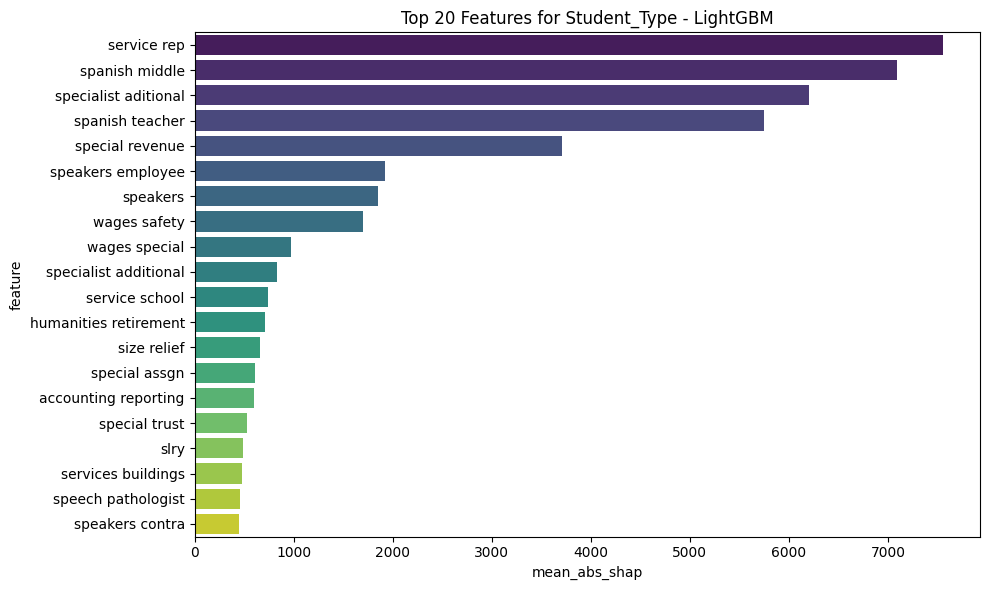

SHAP not available for LightGBM: index 381 is out of bounds for axis 0 with size 50

=== Label: Use ===

--- Training LogisticRegression ---
📌 Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

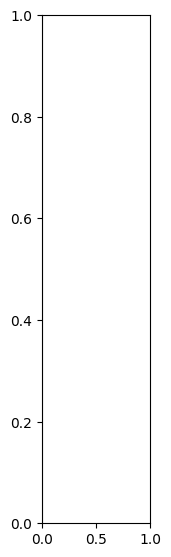

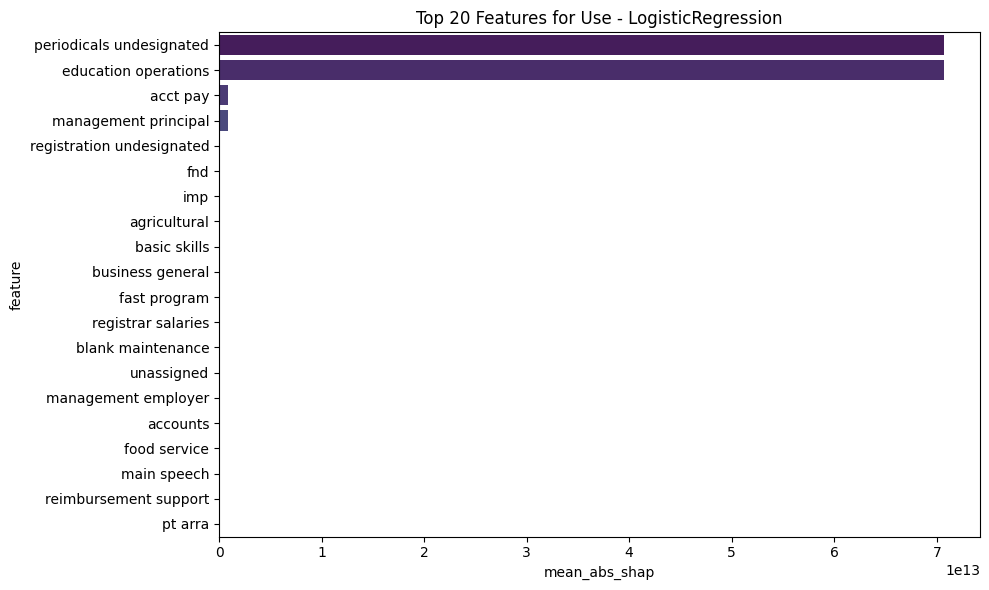

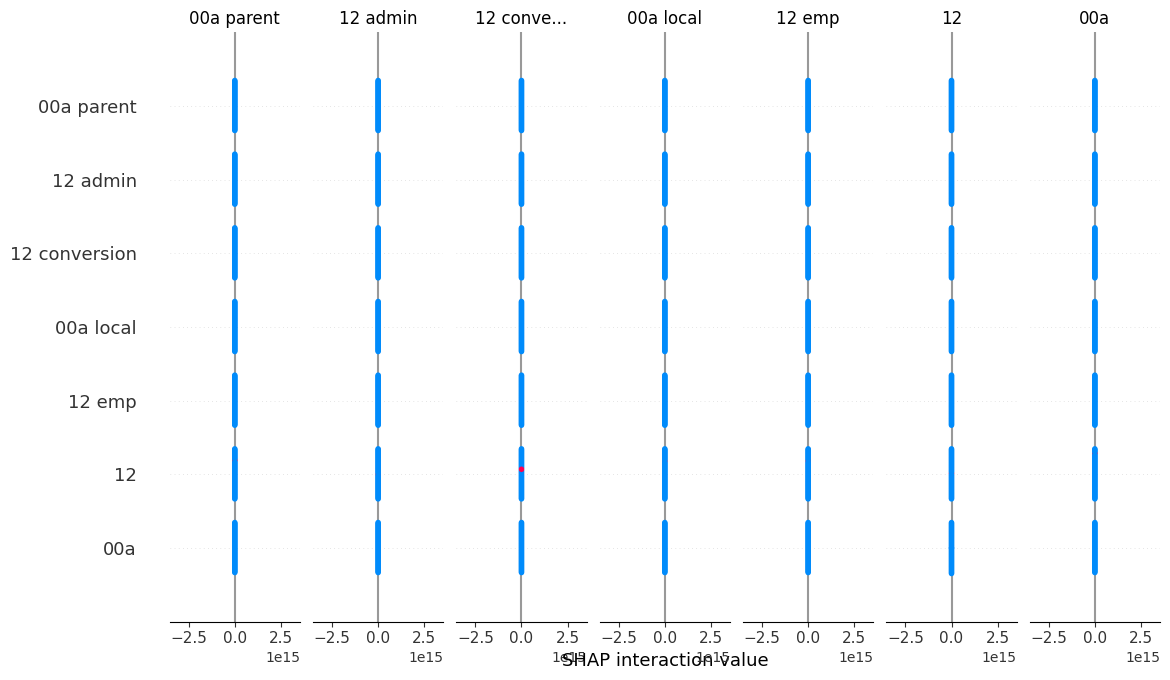


--- Training RandomForest ---
📌 Computing SHAP values...


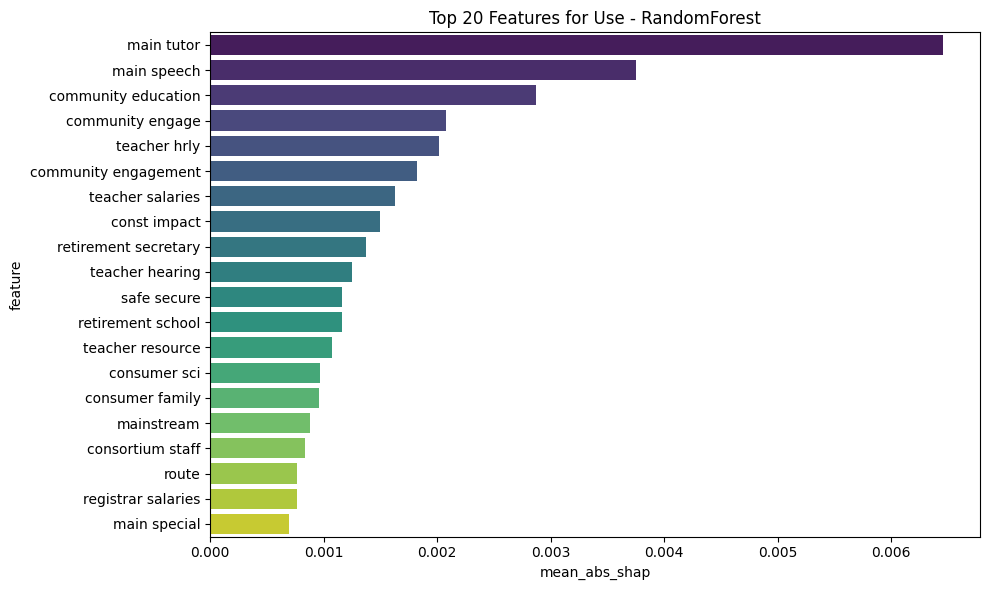

SHAP not available for RandomForest: index 445 is out of bounds for axis 0 with size 50

--- Training XGBoost ---
📌 Computing SHAP values...


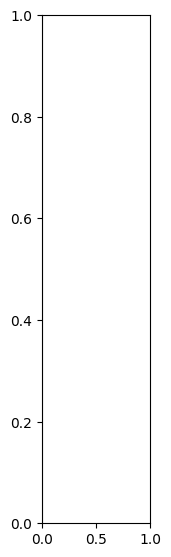

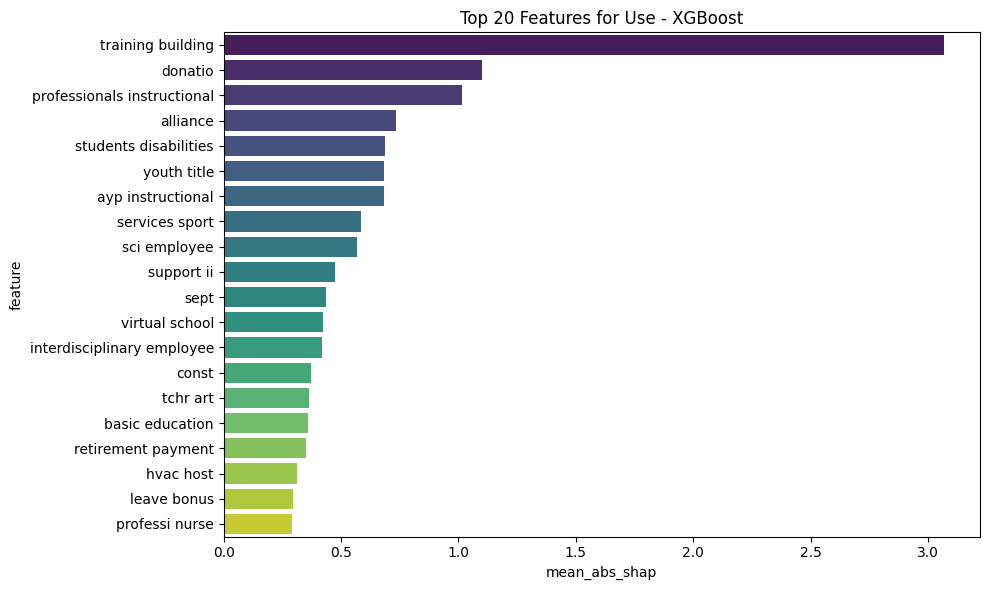

SHAP not available for XGBoost: index 459 is out of bounds for axis 0 with size 50

--- Training LightGBM ---
📌 Computing SHAP values...


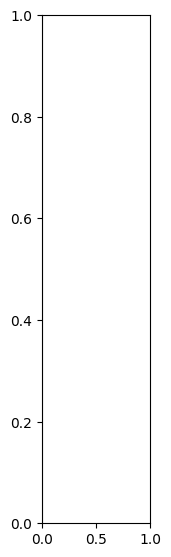

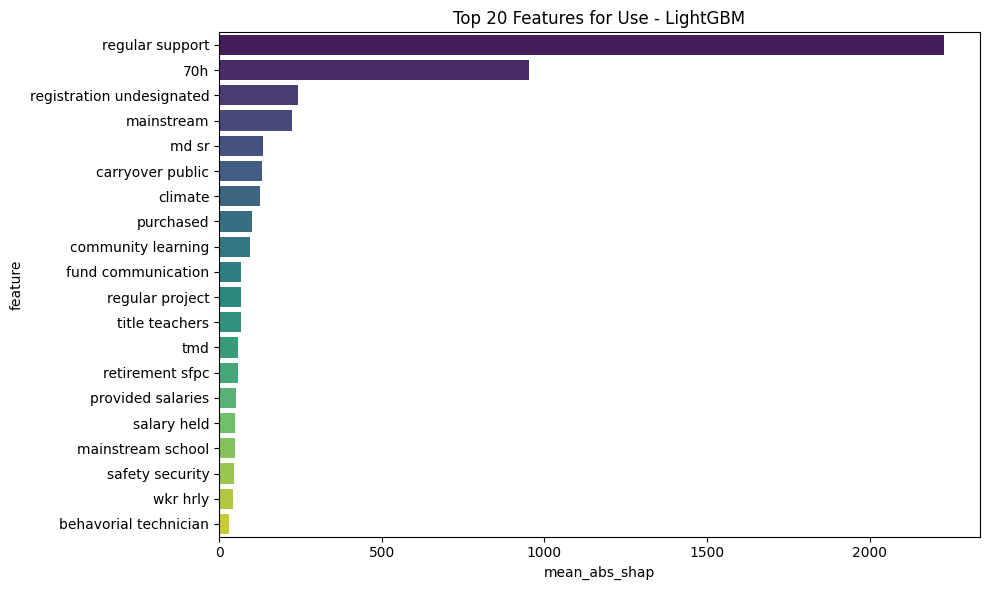

SHAP not available for LightGBM: index 431 is out of bounds for axis 0 with size 50

📊 Performance Metrics:
                 Model  Accuracy        F1
0   LogisticRegression  0.955843  0.955228
1         RandomForest  0.603465  0.540537
2              XGBoost  0.966486  0.966167
3             LightGBM  0.247852  0.139759
4   LogisticRegression  0.984274  0.984222
5         RandomForest  0.809596  0.782630
6              XGBoost  0.989208  0.989181
7             LightGBM  0.990344  0.990324
8   LogisticRegression  0.984986  0.984580
9         RandomForest  0.930111  0.919341
10             XGBoost  0.989108  0.988888
11            LightGBM  0.989920  0.989718
12  LogisticRegression  0.981613  0.981517
13        RandomForest  0.722407  0.666768
14             XGBoost  0.986322  0.986252
15            LightGBM  0.196500  0.105094
16  LogisticRegression  0.989220  0.989191
17        RandomForest  0.935795  0.929869
18             XGBoost  0.993829  0.993790
19            LightGBM  0.994316

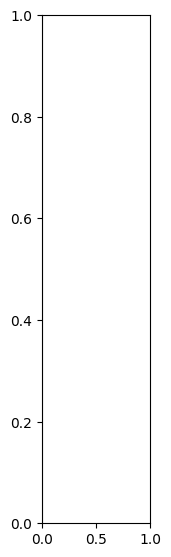

In [ ]:
# ============================================
# Multi-Model SHAP + Evaluation Pipeline
# ============================================

!pip install xgboost lightgbm shap scikit-learn pandas numpy matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import shap
from scipy.sparse import hstack
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore all warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

# ============================================
# 1️⃣ Load Dataset
# ============================================

train_path = "/content/education/TrainingData.csv"
test_path = "/content/education/TestData.csv"

# train_df = pd.read_csv(train_path).head(1000)
# test_df = pd.read_csv(test_path).head(500)

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

num_cols = ['FTE','Total']
text_cols = [
    'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4'
]

label_cols = [col for col in [
    'Function', 'Object_Type', 'Operating_Status', 'Position_Type',
    'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use'
] if col in train_df.columns]

print("Training shape:", train_df.shape, "Test shape:", test_df.shape)
print("Labels:", label_cols)

# ============================================
# 2️⃣ Combine text + numeric features
# ============================================

train_df['combined_text'] = train_df[text_cols].fillna('').agg(' '.join, axis=1)
test_df['combined_text'] = test_df[text_cols].fillna('').agg(' '.join, axis=1)

# TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(train_df['combined_text'])
X_test_text = tfidf.transform(test_df['combined_text'])

# Numeric features
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_numeric = scaler.fit_transform(num_imputer.fit_transform(train_df[num_cols]))
X_test_numeric = scaler.transform(num_imputer.transform(test_df[num_cols]))

# Combine
X = hstack([X_text, X_numeric])
X_test = hstack([X_test_text, X_test_numeric])
feature_names = list(tfidf.get_feature_names_out()) + num_cols
print("Feature matrix shape:", X.shape)

# ============================================
# 3️⃣ Define Models
# ============================================

models = {
    "LogisticRegression": LogisticRegression(max_iter=500, multi_class='auto', solver='lbfgs', n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": xgb.XGBClassifier(
        objective="multi:softprob", n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=42
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective='multiclass', n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, verbose=-1, log_evaluation=None
    )
}

# ============================================
# 4️⃣ Initialize metric tables
# ============================================

df_perf = []
df_reg = []
df_fair = []
df_ai = []

# Simulate sensitive feature for fairness
rng = np.random.default_rng(42)
sensitive_col = rng.choice(['LowIncome','HighIncome'], size=X.shape[0])

# ============================================
# 5️⃣ Train per label, per model + SHAP
# ============================================

shap_summary_all = {}

for label in label_cols:
    print(f"\n=== Label: {label} ===")

    # Encode label
    le = LabelEncoder()
    y = le.fit_transform(train_df[label])

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    sensitive_val = sensitive_col[:len(y_val)]

    shap_summary_all[label] = {}

    for model_name, model in models.items():
        print(f"\n--- Training {model_name} ---")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        # -------------------------
        # Performance metrics
        # -------------------------
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        df_perf.append([model_name, acc, f1])

        # -------------------------
        # Regression-style metrics
        # -------------------------
        mae = mean_absolute_error(y_val, y_pred)
        rmse = mean_squared_error(y_val, y_pred)
        mape = np.mean(np.abs((y_val - y_pred)/np.where(y_val==0,1,y_val))) * 100
        r2 = r2_score(y_val, y_pred)
        df_reg.append([model_name, mae, rmse, mape, r2])

        # -------------------------
        # Fairness (Low vs High Income)
        # -------------------------
        low_mask = np.array(sensitive_val) == 'LowIncome'
        high_mask = np.array(sensitive_val) == 'HighIncome'
        low_acc = accuracy_score(y_val[low_mask], y_pred[low_mask])
        high_acc = accuracy_score(y_val[high_mask], y_pred[high_mask])
        disparity = abs(low_acc - high_acc)
        df_fair.append([model_name, low_acc, high_acc, disparity])

        # -------------------------
        # AI Readiness
        # -------------------------
        interpretability = 3 if model_name=='LogisticRegression' else 4
        fairness_score = 3
        scalability = 4
        acc_score = round(acc*5,2)
        data_quality = 4
        total_score = interpretability + fairness_score + scalability + acc_score + data_quality
        df_ai.append([model_name, interpretability, fairness_score, scalability, acc_score, data_quality, total_score])

        # -------------------------
        # SHAP Analysis
        # -------------------------
        print("📌 Computing SHAP values...")
        try:
            X_val_dense = X_val[:500].toarray() if hasattr(X_val, "toarray") else X_val[:500]

            if model_name in ["RandomForest","XGBoost","LightGBM"]:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_val_dense)
            else:  # LogisticRegression
                # Use KernelExplainer for linear/logistic models
                background = X_train[:100].toarray() if hasattr(X_train, "toarray") else X_train[:100]
                explainer = shap.KernelExplainer(model.predict_proba, background)
                shap_values = explainer.shap_values(X_val_dense[:50], nsamples=100)

            # Multi-class SHAP fix
            if isinstance(shap_values, list):
                mean_abs_shap = np.mean(np.abs(np.array(shap_values)), axis=(0,1))
            else:
                mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

            mean_abs_shap = np.ravel(mean_abs_shap)[:len(feature_names)]

            shap_df = pd.DataFrame({
                "feature": feature_names,
                "mean_abs_shap": mean_abs_shap
            }).sort_values(by="mean_abs_shap", ascending=False)

            shap_summary_all[label][model_name] = shap_df.head(20)

            # Bar plot
            plt.figure(figsize=(10,6))
            sns.barplot(x="mean_abs_shap", y="feature", data=shap_df.head(20), palette="viridis")
            plt.title(f"Top 20 Features for {label} - {model_name}")
            plt.tight_layout()
            plt.show()

            # Beeswarm plot (use smaller sample for LogisticRegression)
            if isinstance(shap_values, list):
                shap_values_multi = np.array([sv[:50] for sv in shap_values])
                shap.summary_plot(shap_values_multi, features=X_val_dense[:50], feature_names=feature_names, plot_type="dot")
            else:
                shap.summary_plot(shap_values, features=X_val_dense[:50], feature_names=feature_names, plot_type="dot")

        except Exception as e:
            print(f"SHAP not available for {model_name}: {e}")

# ============================================
# 6️⃣ Convert metrics to DataFrames
# ============================================

df_perf = pd.DataFrame(df_perf, columns=['Model','Accuracy','F1'])
df_reg = pd.DataFrame(df_reg, columns=['Model','MAE','RMSE','MAPE (%)','R2'])
df_fair = pd.DataFrame(df_fair, columns=['Model','LowIncome_Accuracy','HighIncome_Accuracy','Disparity'])
df_ai = pd.DataFrame(df_ai, columns=['Model','Interpretability','Fairness','Scalability','Accuracy','Data Quality','Total_Score'])

# Display all metrics
print("\n📊 Performance Metrics:")
print(df_perf)
print("\n📊 Regression-style Metrics:")
print(df_reg)
print("\n⚖️ Fairness Metrics:")
print(df_fair)
print("\n📈 AI Readiness Index:")
print(df_ai)


## DATASET ANALYSIS

/tmp/ipython-input-221817871.py:27: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[name] = pd.read_csv(file)


Dataset Name                        Task    Rows  Columns  \
0    Student Performance Factors   Regression/Classification    6607       20   
1          College Enrollment US                  Regression       6       21   
2      World University Rankings                  Regression   14522       14   
3   Student Retention Predictors              Classification    4424       35   
4  BoxPlots Education - Combined  Multi-label Classification  450341       27   

       df.shape       Target Variable  % Missing Values  # Numerical Features  \
0    (6607, 20)           Final Grade              0.18                     7   
1       (6, 21)            Enrollment              0.00                    20   
2   (14522, 14)                  Rank              0.33                    10   
3    (4424, 35)             Retention              0.00                    34   
4  (450341, 27)  Labels (multi-label)             31.09                     2   

   # Text Features  # Label Features  \
0                0                 0   
1                0                 0   
2                0                 0   
3                0                 0   
4               14                 9   

                                   Numerical Columns  \
0  [Hours_Studied, Attendance, Sleep_Hours, Previ...   
1  [Unnamed: 0, 2003, 2004, 2005, 2006, 2007, 200...   
2  [Rank, Student Population, Students to Staff R...   
3  [Marital status, Application mode, Application...   
4                                       [FTE, Total]   

                                        Text Columns  \
0                                                 []   
1                                                 []   
2                                                 []   
3                                                 []   
4  [Facility_or_Department, Function_Description,...   

                                       Label Columns  \
0                                                 []   
1                                                 []   
2                                                 []   
3                                                 []   
4  [Function, Object_Type, Operating_Status, Posi...   

                           Missing Values per Column  
0  {'Hours_Studied': 0, 'Attendance': 0, 'Parenta...  
1  {'Unnamed: 0': 0, 'Type': 0, '2003': 0, '2004'...  
2  {'Rank': 0, 'Name': 0, 'Country': 0, 'Student ...  
3  {'Marital status': 0, 'Application mode': 0, '...  
4  {'Unnamed: 0': 0, 'Function': 50064, 'Use': 50...

/tmp/ipython-input-221817871.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dfs.keys()), y=missing_totals, palette="viridis")


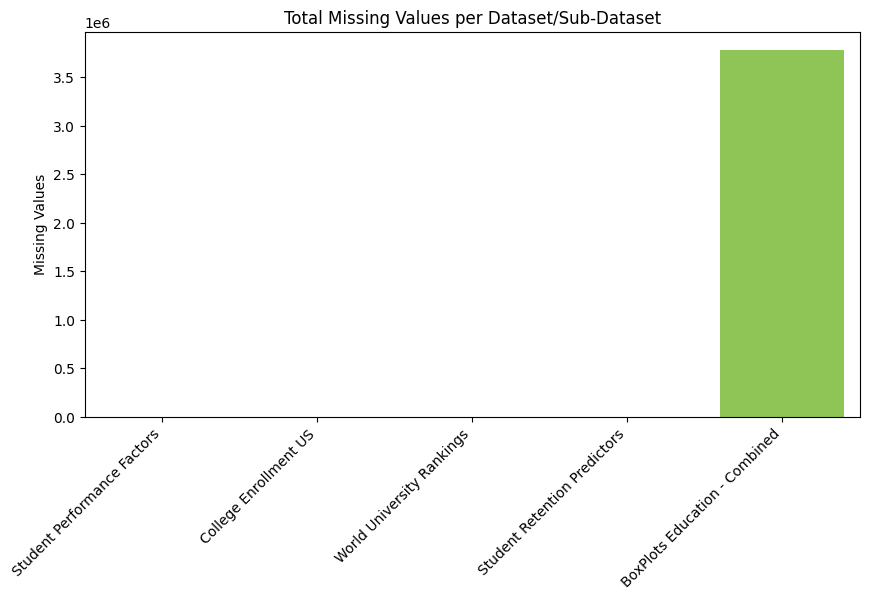

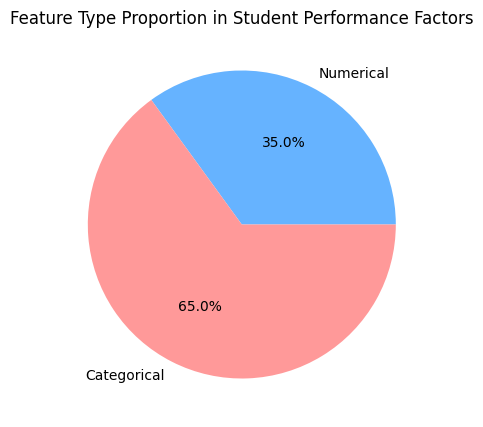

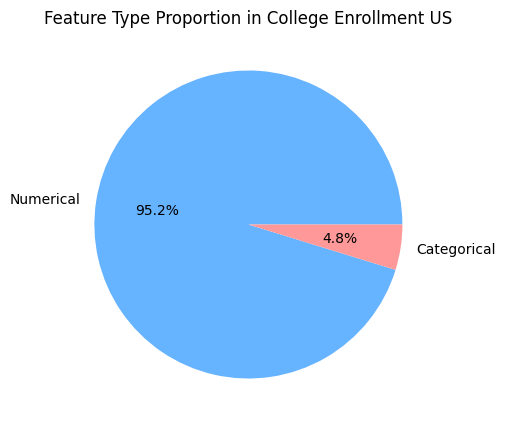

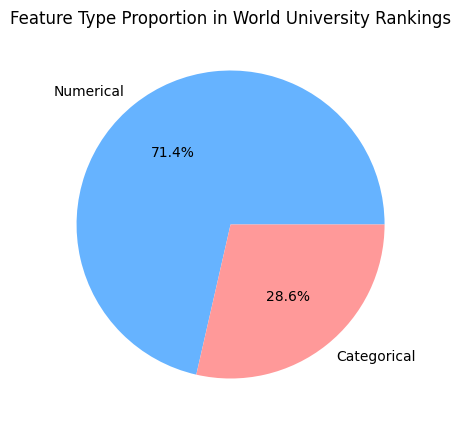

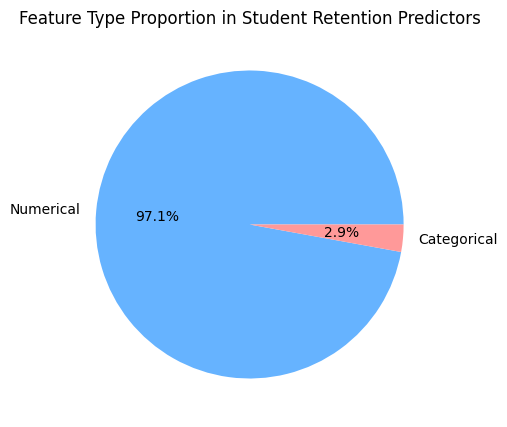

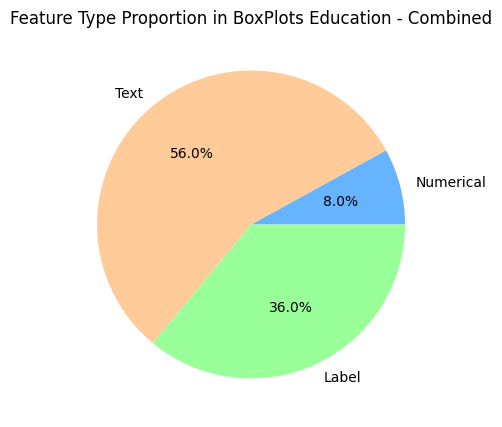

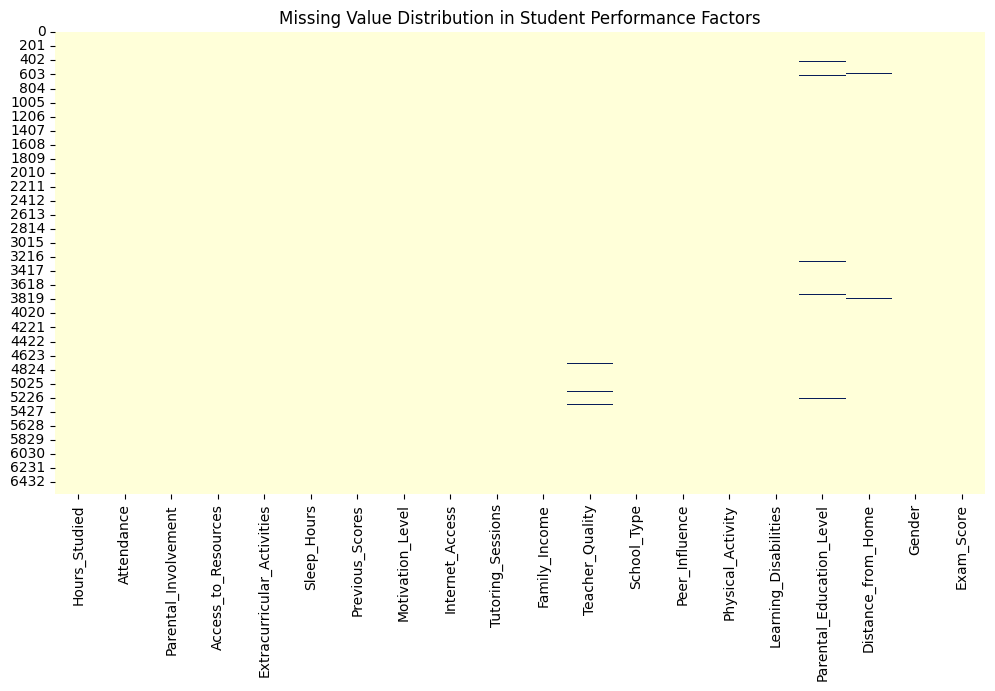

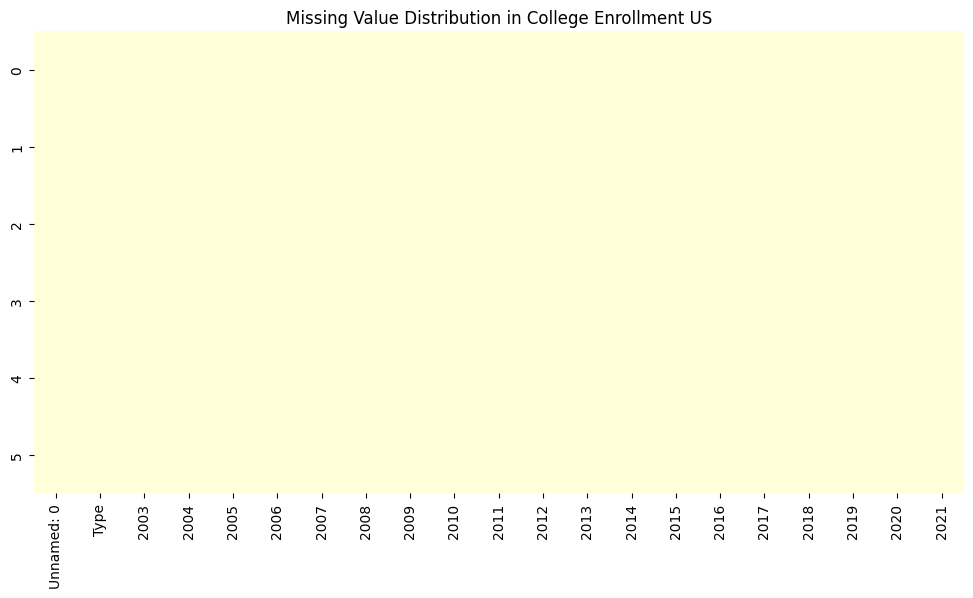

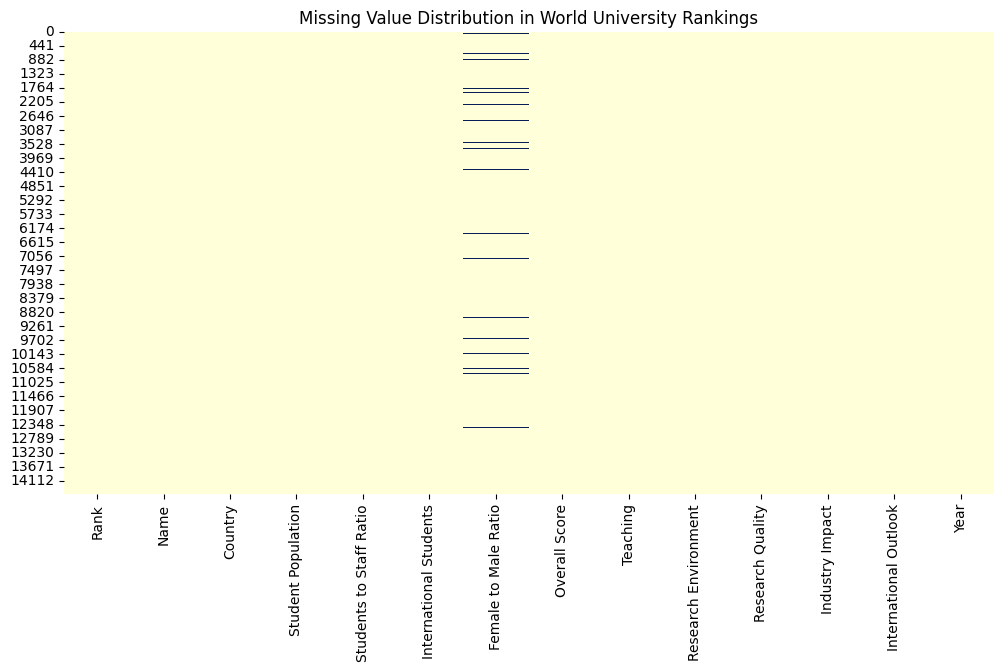

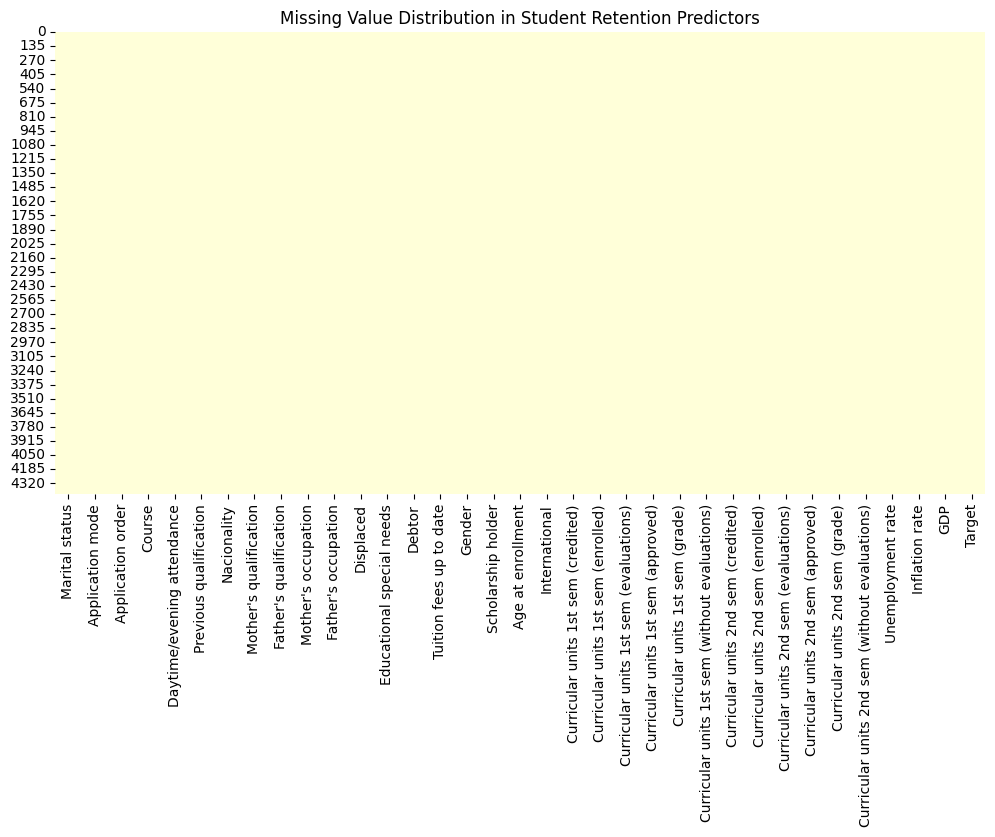

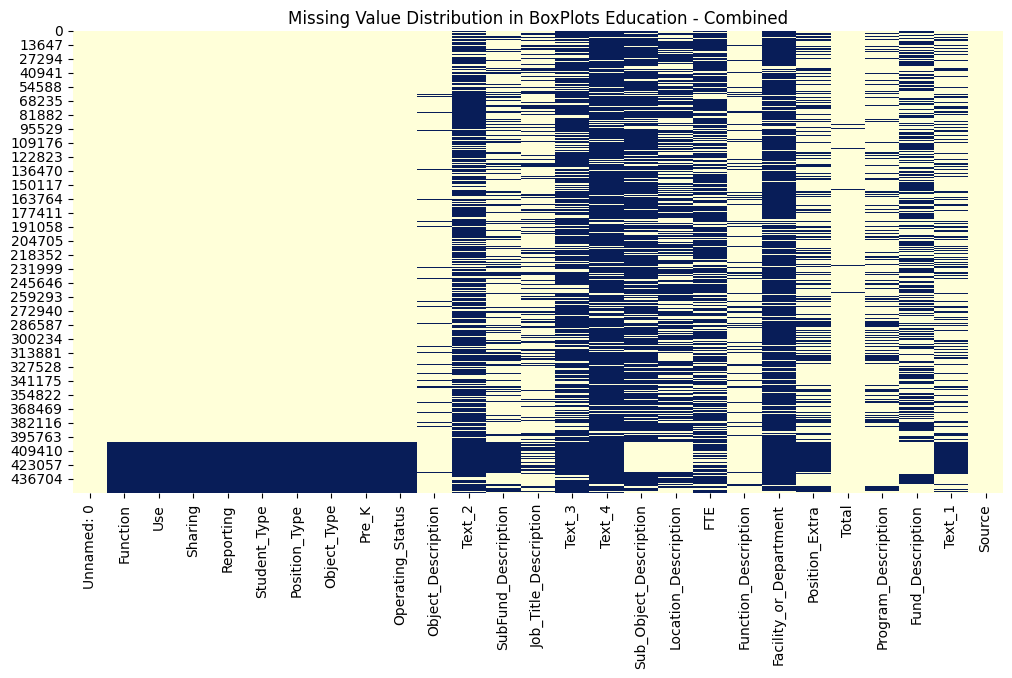

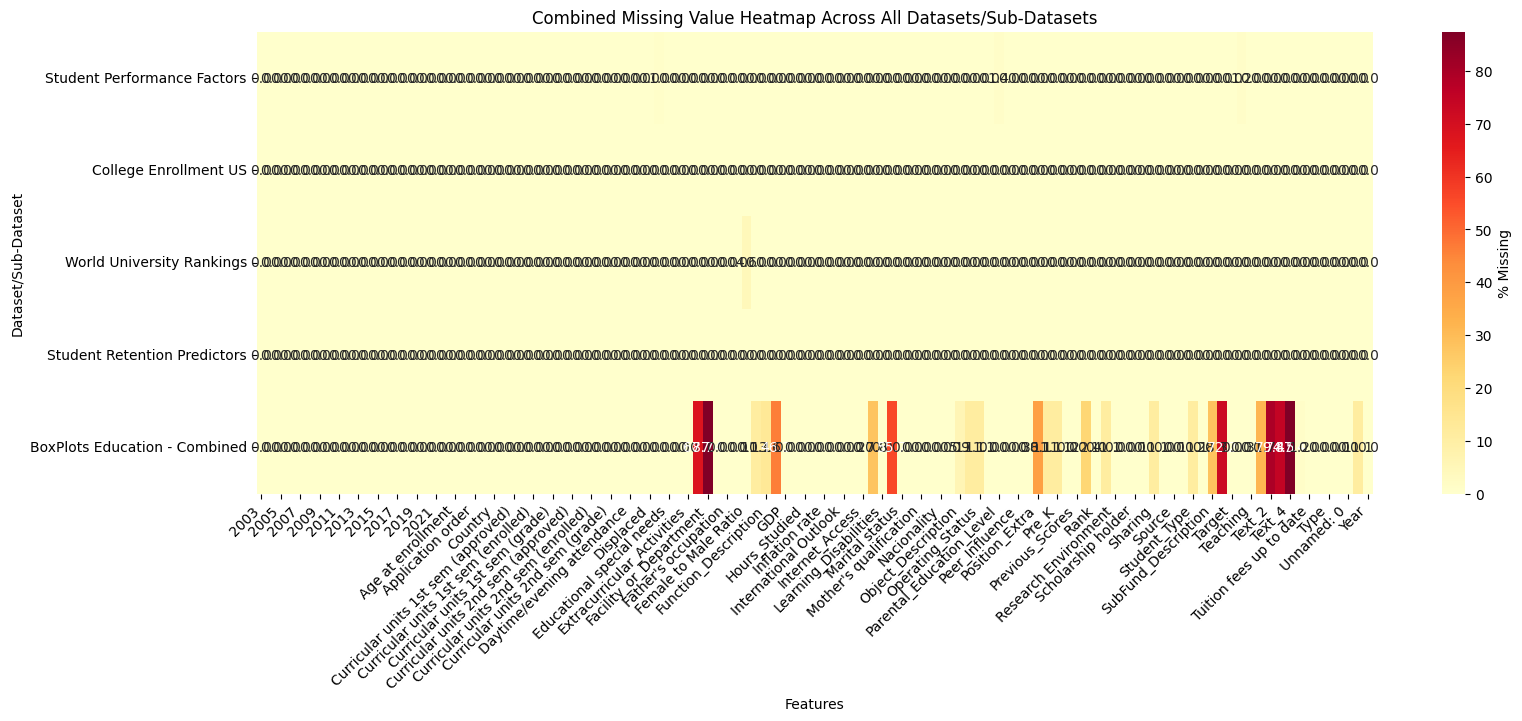

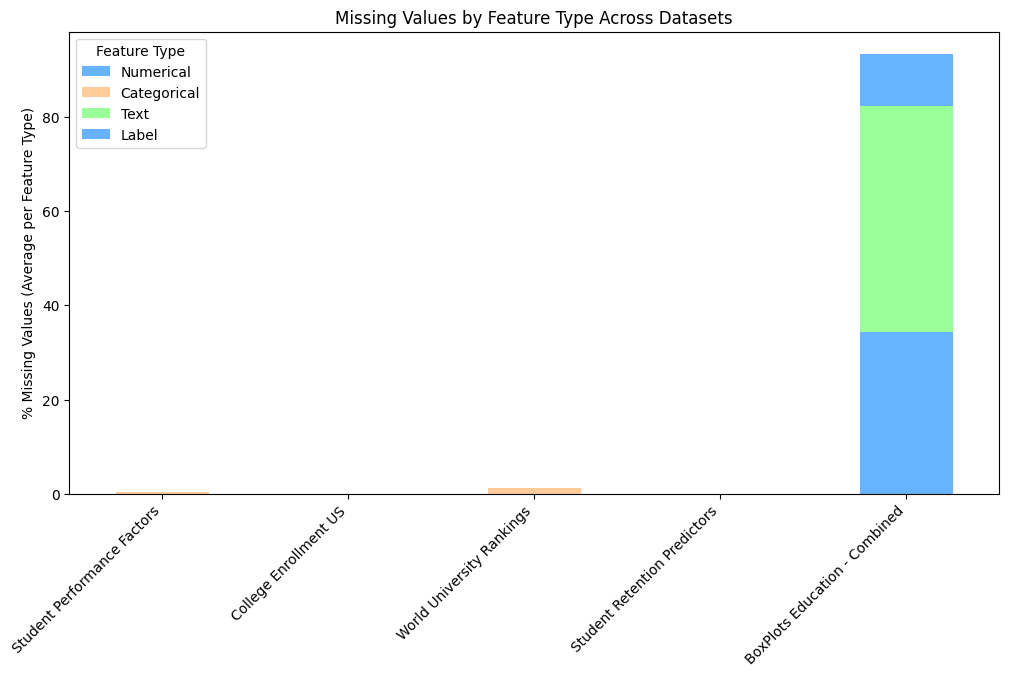

In [ ]:
# ====================== IMPORTS ======================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# ====================== DATASET PATHS ======================
datasets = {
    "Student Performance Factors": "/content/student_performance/StudentPerformanceFactors.csv",
    "College Enrollment US": "/content/college_enrollment/enrollment.csv",
    "World University Rankings": "/content/university_rankings/THE World University Rankings 2016-2025.csv",
    "Student Retention Predictors": "/content/retention/dataset.csv",
    # DrivenData BoxPlots - train & test
    "BoxPlots Education - Train": "/content/education/TrainingData.csv",
    "BoxPlots Education - Test": "/content/education/TestData.csv"
}

# ====================== LOAD DATASETS ======================
dfs = {}
for name, file in datasets.items():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file) as z:
            z.extractall()
            extracted_file = z.namelist()[0]
            dfs[name] = pd.read_csv(extracted_file)
    else:
        dfs[name] = pd.read_csv(file)

# ====================== COMBINE BOXPLOTS TRAIN & TEST ======================
boxplots_train = dfs.pop("BoxPlots Education - Train")
boxplots_test = dfs.pop("BoxPlots Education - Test")

# Add source column to keep track
boxplots_train["Source"] = "Train"
boxplots_test["Source"] = "Test"

# Concatenate
boxplots_combined = pd.concat([boxplots_train, boxplots_test], ignore_index=True)
dfs["BoxPlots Education - Combined"] = boxplots_combined

# ====================== TARGET / TASK ======================
targets_tasks = {
    "Student Performance Factors": ("Final Grade", "Regression/Classification"),
    "College Enrollment US": ("Enrollment", "Regression"),
    "World University Rankings": ("Rank", "Regression"),
    "Student Retention Predictors": ("Retention", "Classification"),
    "BoxPlots Education - Combined": ("Labels (multi-label)", "Multi-label Classification")
}

# ====================== BOXPLOTS COLUMN CATEGORIZATION ======================
boxplots_num_cols = ['FTE', 'Total']
boxplots_text_cols = [
    'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4'
]
def get_boxplots_label_cols(df):
    possible_labels = [
        'Function', 'Object_Type', 'Operating_Status', 'Position_Type',
        'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use'
    ]
    return [col for col in possible_labels if col in df.columns]

# ====================== SUMMARY TABLE ======================
summary = []

for name, df in dfs.items():
    if "BoxPlots Education - Combined" in name:
        num_features = [col for col in boxplots_num_cols if col in df.columns]
        text_features = [col for col in boxplots_text_cols if col in df.columns]
        label_features = get_boxplots_label_cols(df)
        n_num, n_text, n_label = len(num_features), len(text_features), len(label_features)
        total_missing_pct = round(df.isnull().mean().sum() * 100 / len(df.columns), 2)
    else:
        num_features = df.select_dtypes(include=['number']).columns.tolist()
        cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
        text_features, label_features = [], []
        n_num, n_text, n_label = len(num_features), 0, 0
        total_missing_pct = round(df.isnull().mean().sum() * 100 / len(df.columns), 2)

    summary.append({
        "Dataset Name": name,
        "Task": targets_tasks[name][1],
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "df.shape": df.shape,
        "Target Variable": targets_tasks[name][0],
        "% Missing Values": total_missing_pct,
        "# Numerical Features": n_num,
        "# Text Features": n_text,
        "# Label Features": n_label,
        "Numerical Columns": num_features,
        "Text Columns": text_features,
        "Label Columns": label_features,
        "Missing Values per Column": df.isnull().sum().to_dict()
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

# ====================== BAR CHART: TOTAL MISSING VALUES ======================
missing_totals = [df.isnull().sum().sum() for df in dfs.values()]
plt.figure(figsize=(10,5))
sns.barplot(x=list(dfs.keys()), y=missing_totals, palette="viridis")
plt.title("Total Missing Values per Dataset/Sub-Dataset")
plt.ylabel("Missing Values")
plt.xticks(rotation=45, ha="right")
plt.show()

# ====================== PIE CHART: FEATURE TYPE PROPORTION ======================
for name, df in dfs.items():
    if "BoxPlots Education - Combined" in name:
        num_count = len([col for col in boxplots_num_cols if col in df.columns])
        text_count = len([col for col in boxplots_text_cols if col in df.columns])
        label_count = len(get_boxplots_label_cols(df))
        sizes = [num_count, text_count, label_count]
        labels = ['Numerical', 'Text', 'Label']
        colors = ['#66b3ff','#ffcc99','#99ff99']
    else:
        num_count = len(df.select_dtypes(include=['number']).columns)
        cat_count = len(df.select_dtypes(include=['object', 'category']).columns)
        sizes = [num_count, cat_count]
        labels = ['Numerical', 'Categorical']
        colors = ['#66b3ff','#ff9999']

    plt.figure(figsize=(5,5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.title(f'Feature Type Proportion in {name}')
    plt.show()

# ====================== HEATMAP: MISSING VALUE DISTRIBUTION PER DATASET ======================
for name, df in dfs.items():
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
    plt.title(f'Missing Value Distribution in {name}')
    plt.show()

# ====================== COMBINED MISSING VALUE HEATMAP ======================
combined_missing = {}
for name, df in dfs.items():
    combined_missing[name] = df.isnull().mean() * 100

combined_missing_df = pd.DataFrame(combined_missing).T.fillna(0)
plt.figure(figsize=(18,6))
sns.heatmap(combined_missing_df, annot=True, fmt=".1f", cmap="YlOrRd",
            cbar_kws={'label': '% Missing'})
plt.title("Combined Missing Value Heatmap Across All Datasets/Sub-Datasets")
plt.ylabel("Dataset/Sub-Dataset")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.show()

# ====================== STACKED BAR CHART: MISSING BY FEATURE TYPE ======================
missing_summary = {}

for name, df in dfs.items():
    if "BoxPlots Education - Combined" in name:
        num_features = [col for col in boxplots_num_cols if col in df.columns]
        text_features = [col for col in boxplots_text_cols if col in df.columns]
        label_features = get_boxplots_label_cols(df)

        missing_summary[name] = {
            "Numerical": df[num_features].isnull().mean().mean() * 100 if num_features else 0,
            "Text": df[text_features].isnull().mean().mean() * 100 if text_features else 0,
            "Label": df[label_features].isnull().mean().mean() * 100 if label_features else 0
        }
    else:
        num_features = df.select_dtypes(include=['number']).columns.tolist()
        cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

        missing_summary[name] = {
            "Numerical": df[num_features].isnull().mean().mean() * 100 if num_features else 0,
            "Categorical": df[cat_features].isnull().mean().mean() * 100 if cat_features else 0
        }

missing_summary_df = pd.DataFrame(missing_summary).T.fillna(0)

# Plot stacked bar
missing_summary_df.plot(kind='bar', stacked=True, figsize=(12,6),
                        color=['#66b3ff','#ffcc99','#99ff99'])
plt.ylabel('% Missing Values (Average per Feature Type)')
plt.title('Missing Values by Feature Type Across Datasets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feature Type')
plt.show()


In [ ]:
import pandas as pd

# ============================
# DATASET PATHS
# ============================
datasets = {
    "Student Performance Factors": "/content/student_performance/StudentPerformanceFactors.csv",
    "College Enrollment US": "/content/college_enrollment/enrollment.csv",
    "World University Rankings": "/content/university_rankings/THE World University Rankings 2016-2025.csv",
    "Student Retention Predictors": "/content/retention/dataset.csv",
    "BoxPlots Education - Train": "/content/education/TrainingData.csv",
    "BoxPlots Education - Test": "/content/education/TestData.csv"
}

# ============================
# LOAD DATASETS
# ============================
dfs = {name: pd.read_csv(path) for name, path in datasets.items()}

# ============================
# BOXPLOTS LABEL/TEXT/NUM COLUMNS
# ============================
boxplots_num_cols = ['FTE', 'Total']
boxplots_text_cols = [
    'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4'
]
boxplots_label_cols = [
    'Function', 'Object_Type', 'Operating_Status', 'Position_Type',
    'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use'
]

# ============================
# UNIQUE FEATURE TYPES
# ============================
feature_type_summary = []

for name, df in dfs.items():

    if "BoxPlots" in name:
        numerical = [c for c in boxplots_num_cols if c in df.columns]
        text = [c for c in boxplots_text_cols if c in df.columns]
        labels = [c for c in boxplots_label_cols if c in df.columns]
        categorical = list(set(df.columns) - set(numerical) - set(text) - set(labels))
    else:
        numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
        text = []     # no separate text category
        labels = []   # only BoxPlots has labels

    feature_type_summary.append({
        "Dataset": name,
        "Num Numerical Features": len(numerical),
        "Num Categorical Features": len(categorical),
        "Num Text Features": len(text),
        "Num Label Features": len(labels),
        "Numerical Features": numerical,
        "Categorical Features": categorical,
        "Text Features": text,
        "Label Features": labels
    })

feature_types_df = pd.DataFrame(feature_type_summary)

# Display Unique Features by Type
display(feature_types_df)

# ============================
# FEATURE DIVERSITY CALCULATION
# ============================
diversity_summary = []

for name, df in dfs.items():

    diversity_scores = {}

    for col in df.columns:
        unique_vals = df[col].nunique(dropna=True)
        total_rows = len(df)
        diversity = round(unique_vals / total_rows, 4)
        diversity_scores[col] = diversity

    diversity_summary.append({
        "Dataset": name,
        "Avg Feature Diversity": round(sum(diversity_scores.values()) / len(diversity_scores), 4),
        "Max Diversity Feature": max(diversity_scores, key=diversity_scores.get),
        "Max Diversity Score": max(diversity_scores.values()),
        "Min Diversity Feature": min(diversity_scores, key=diversity_scores.get),
        "Min Diversity Score": min(diversity_scores.values()),
        "All Diversity Scores": diversity_scores
    })

diversity_df = pd.DataFrame(diversity_summary)

# Display Feature Diversity Summary
display(diversity_df)


/tmp/ipython-input-3667146659.py:18: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv(path) for name, path in datasets.items()}


Dataset  Num Numerical Features  \
0   Student Performance Factors                       7   
1         College Enrollment US                      20   
2     World University Rankings                      10   
3  Student Retention Predictors                      34   
4    BoxPlots Education - Train                       2   
5     BoxPlots Education - Test                       2   

   Num Categorical Features  Num Text Features  Num Label Features  \
0                        13                  0                   0   
1                         1                  0                   0   
2                         4                  0                   0   
3                         1                  0                   0   
4                         1                 14                   9   
5                         1                 14                   0   

                                  Numerical Features  \
0  [Hours_Studied, Attendance, Sleep_Hours, Previ...   
1  [Unnamed: 0, 2003, 2004, 2005, 2006, 2007, 200...   
2  [Rank, Student Population, Students to Staff R...   
3  [Marital status, Application mode, Application...   
4                                       [FTE, Total]   
5                                       [FTE, Total]   

                                Categorical Features  \
0  [Parental_Involvement, Access_to_Resources, Ex...   
1                                             [Type]   
2  [Name, Country, International Students, Female...   
3                                           [Target]   
4                                       [Unnamed: 0]   
5                                       [Unnamed: 0]   

                                       Text Features  \
0                                                 []   
1                                                 []   
2                                                 []   
3                                                 []   
4  [Facility_or_Department, Function_Description,...   
5  [Facility_or_Department, Function_Description,...   

                                      Label Features  
0                                                 []  
1                                                 []  
2                                                 []  
3                                                 []  
4  [Function, Object_Type, Operating_Status, Posi...  
5                                                 []

Dataset  Avg Feature Diversity  \
0   Student Performance Factors                 0.0018   
1         College Enrollment US                 1.0000   
2     World University Rankings                 0.1707   
3  Student Retention Predictors                 0.0138   
4    BoxPlots Education - Train                 0.0689   
5     BoxPlots Education - Test                 0.1172   

              Max Diversity Feature  Max Diversity Score  \
0                   Previous_Scores               0.0077   
1                        Unnamed: 0               1.0000   
2                     Overall Score               0.8642   
3  Curricular units 1st sem (grade)               0.1820   
4                        Unnamed: 0               1.0000   
5                        Unnamed: 0               1.0000   

        Min Diversity Feature  Min Diversity Score  \
0  Extracurricular_Activities               0.0003   
1                  Unnamed: 0               1.0000   
2                        Year               0.0007   
3  Daytime/evening attendance               0.0005   
4                         Use               0.0000   
5                      Text_3               0.0003   

                                All Diversity Scores  
0  {'Hours_Studied': 0.0062, 'Attendance': 0.0062...  
1  {'Unnamed: 0': 1.0, 'Type': 1.0, '2003': 1.0, ...  
2  {'Rank': 0.144, 'Name': 0.1609, 'Country': 0.0...  
3  {'Marital status': 0.0014, 'Application mode':...  
4  {'Unnamed: 0': 1.0, 'Function': 0.0001, 'Use':...  
5  {'Unnamed: 0': 1.0, 'Object_Description': 0.00...

In [ ]:
import pandas as pd

# ============================
# DATASET PATHS
# ============================
datasets = {
    "Student Performance Factors": "/content/student_performance/StudentPerformanceFactors.csv",
    "College Enrollment US": "/content/college_enrollment/enrollment.csv",
    "World University Rankings": "/content/university_rankings/THE World University Rankings 2016-2025.csv",
    "Student Retention Predictors": "/content/retention/dataset.csv",
    "BoxPlots Education - Train": "/content/education/TrainingData.csv",
    "BoxPlots Education - Test": "/content/education/TestData.csv"
}

# ============================
# LOAD DATASETS
# ============================
dfs = {name: pd.read_csv(path) for name, path in datasets.items()}

# ============================
# BOXPLOTS LABEL/TEXT/NUM COLUMNS
# ============================
boxplots_num_cols = ['FTE', 'Total']
boxplots_text_cols = [
    'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4'
]
boxplots_label_cols = [
    'Function', 'Object_Type', 'Operating_Status', 'Position_Type',
    'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use'
]

# ============================
# UNIQUE FEATURE TYPES + MISSING STATS
# ============================
feature_type_summary = []

for name, df in dfs.items():

    # Determine feature types
    if "BoxPlots" in name:
        numerical = [c for c in boxplots_num_cols if c in df.columns]
        text = [c for c in boxplots_text_cols if c in df.columns]
        labels = [c for c in boxplots_label_cols if c in df.columns]
        categorical = list(set(df.columns) - set(numerical) - set(text) - set(labels))
    else:
        numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
        text = []     # only BoxPlots has text columns
        labels = []   # only BoxPlots has label columns

    # Total missing values
    total_missing = df.isnull().sum().sum()

    # Missing per category type
    def missing_pct(cols):
        if len(cols) == 0:
            return 0
        return round(df[cols].isnull().mean().mean() * 100, 2)

    missing_num = missing_pct(numerical)
    missing_cat = missing_pct(categorical)
    missing_text = missing_pct(text)
    missing_label = missing_pct(labels)

    feature_type_summary.append({
        "Dataset": name,
        "Num Numerical Features": len(numerical),
        "Num Categorical Features": len(categorical),
        "Num Text Features": len(text),
        "Num Label Features": len(labels),

        "Total Missing Values": total_missing,

        "% Missing Numerical": missing_num,
        "% Missing Categorical": missing_cat,
        "% Missing Text": missing_text,
        "% Missing Label": missing_label,

        "Numerical Features": numerical,
        "Categorical Features": categorical,
        "Text Features": text,
        "Label Features": labels
    })

feature_types_df = pd.DataFrame(feature_type_summary)

# Display Unique Features + Missing Stats
display(feature_types_df)

# ============================
# FEATURE DIVERSITY CALCULATION
# ============================
diversity_summary = []

for name, df in dfs.items():

    diversity_scores = {}

    for col in df.columns:
        unique_vals = df[col].nunique(dropna=True)
        total_rows = len(df)
        diversity = round(unique_vals / total_rows, 4)
        diversity_scores[col] = diversity

    diversity_summary.append({
        "Dataset": name,
        "Avg Feature Diversity": round(sum(diversity_scores.values()) / len(diversity_scores), 4),
        "Max Diversity Feature": max(diversity_scores, key=diversity_scores.get),
        "Max Diversity Score": max(diversity_scores.values()),
        "Min Diversity Feature": min(diversity_scores, key=diversity_scores.get),
        "Min Diversity Score": min(diversity_scores.values()),
        "All Diversity Scores": diversity_scores
    })

diversity_df = pd.DataFrame(diversity_summary)

# Display Diversity Summary
display(diversity_df)


/tmp/ipython-input-2054003200.py:18: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv(path) for name, path in datasets.items()}


Dataset  Num Numerical Features  \
0   Student Performance Factors                       7   
1         College Enrollment US                      20   
2     World University Rankings                      10   
3  Student Retention Predictors                      34   
4    BoxPlots Education - Train                       2   
5     BoxPlots Education - Test                       2   

   Num Categorical Features  Num Text Features  Num Label Features  \
0                        13                  0                   0   
1                         1                  0                   0   
2                         4                  0                   0   
3                         1                  0                   0   
4                         1                 14                   9   
5                         1                 14                   0   

   Total Missing Values  % Missing Numerical  % Missing Categorical  \
0                   235                 0.00                   0.27   
1                     0                 0.00                   0.00   
2                   672                 0.00                   1.16   
3                     0                 0.00                   0.00   
4               2942109                34.82                   0.00   
5                387797                31.08                   0.00   

   % Missing Text  % Missing Label  \
0            0.00              0.0   
1            0.00              0.0   
2            0.00              0.0   
3            0.00              0.0   
4           47.53              0.0   
5           50.89              0.0   

                                  Numerical Features  \
0  [Hours_Studied, Attendance, Sleep_Hours, Previ...   
1  [Unnamed: 0, 2003, 2004, 2005, 2006, 2007, 200...   
2  [Rank, Student Population, Students to Staff R...   
3  [Marital status, Application mode, Application...   
4                                       [FTE, Total]   
5                                       [FTE, Total]   

                                Categorical Features  \
0  [Parental_Involvement, Access_to_Resources, Ex...   
1                                             [Type]   
2  [Name, Country, International Students, Female...   
3                                           [Target]   
4                                       [Unnamed: 0]   
5                                       [Unnamed: 0]   

                                       Text Features  \
0                                                 []   
1                                                 []   
2                                                 []   
3                                                 []   
4  [Facility_or_Department, Function_Description,...   
5  [Facility_or_Department, Function_Description,...   

                                      Label Features  
0                                                 []  
1                                                 []  
2                                                 []  
3                                                 []  
4  [Function, Object_Type, Operating_Status, Posi...  
5                                                 []

Dataset  Avg Feature Diversity  \
0   Student Performance Factors                 0.0018   
1         College Enrollment US                 1.0000   
2     World University Rankings                 0.1707   
3  Student Retention Predictors                 0.0138   
4    BoxPlots Education - Train                 0.0689   
5     BoxPlots Education - Test                 0.1172   

              Max Diversity Feature  Max Diversity Score  \
0                   Previous_Scores               0.0077   
1                        Unnamed: 0               1.0000   
2                     Overall Score               0.8642   
3  Curricular units 1st sem (grade)               0.1820   
4                        Unnamed: 0               1.0000   
5                        Unnamed: 0               1.0000   

        Min Diversity Feature  Min Diversity Score  \
0  Extracurricular_Activities               0.0003   
1                  Unnamed: 0               1.0000   
2                        Year               0.0007   
3  Daytime/evening attendance               0.0005   
4                         Use               0.0000   
5                      Text_3               0.0003   

                                All Diversity Scores  
0  {'Hours_Studied': 0.0062, 'Attendance': 0.0062...  
1  {'Unnamed: 0': 1.0, 'Type': 1.0, '2003': 1.0, ...  
2  {'Rank': 0.144, 'Name': 0.1609, 'Country': 0.0...  
3  {'Marital status': 0.0014, 'Application mode':...  
4  {'Unnamed: 0': 1.0, 'Function': 0.0001, 'Use':...  
5  {'Unnamed: 0': 1.0, 'Object_Description': 0.00...